### Import Modules

In [26]:
import sys
import os
import argparse
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import math
import numpy as np
import pandas as pd
import datetime as dt
import scipy as sp
import csv
import traceback
import portion as P
from tqdm import tqdm
from pprint import pprint
from pytictoc import TicToc
from statistics import median
from statistics import mean
from statistics import mode
from statistics import stdev
from tabulate import tabulate
from prettytable import PrettyTable

def bpy_color_palette(n=50, cutoff_tails=0.1):
    """
    Generate a color palette with specific number.
    Ref. https://www.rdocumentation.org/packages/gstat/versions/0.9-22/topics/bpy.colors

    Args:
        n (int): number of colors
        cutoff_tails (float): tail fraction to be cut off. This palette runs from black to white if cutoff.tails is 0; by cutting off the tails, it runs from blue to yellow, which looks nicer.
    Returns:
        color_list (list): list of hex color code.
    """
    item_list = np.linspace(start=0.5 * cutoff_tails, stop=1 - 0.5 * cutoff_tails, num=n)
    color_list = []
    for i in item_list:
        ### R
        if(i < 0.25):
            r = 0
        elif(i < 0.57):
            r =  i / .32 - .78125
        else:
            r = 1
        ### G
        if(i < 0.42):
            g = 0
        elif(i < 0.92):
            g =  2 * i - .84
        else:
            g = 1
        ### B
        if(i < 0.25):
            b = 4 * i
        elif(i < 0.42):
            b =  1
        elif(i < 0.92):
            b =  -2 * i + 1.84
        else:
            b = i / .08 - 11.5
        ### append color
        color_list.append(mcolors.to_hex([ r, g, b ]))
    cmap = mcolors.ListedColormap(color_list, name='my_colormap')
    return cmap

### Data Acquisition

In [2]:
db1 = "/home/wmnlab/D/database/2022-09-29/_Bandlock_Udp"
db2 = "/home/wmnlab/D/database/2022-10-11/_Bandlock_Udp"
dset = {
    'all'  : {'device': 'sm05', 'root': os.path.join(db1, 'sm05'), 'rounds': ['#02', '#03', '#04', '#05']},
    'b1'   : {'device': 'sm06', 'root': os.path.join(db1, 'sm06'), 'rounds': ['#02', '#03', '#04', '#05']},
    'b3'   : {'device': 'sm07', 'root': os.path.join(db1, 'sm07'), 'rounds': ['#02', '#03', '#04', '#05']},
    'b28'  : {'device': 'sm08', 'root': os.path.join(db1, 'sm08'), 'rounds': ['#02', '#03', '#04', '#05']},
    # 'all_1': {'device': 'sm04', 'root': os.path.join(db2, 'sm04'), 'rounds': ['#01', '#02', '#03', '#04']},
    # 'all_2': {'device': 'sm05', 'root': os.path.join(db2, 'sm05'), 'rounds': ['#01', '#02', '#03', '#04']},
    'b1b3' : {'device': 'sm06', 'root': os.path.join(db2, 'sm06'), 'rounds': ['#01', '#02', '#03', '#04']},
    'b3b28': {'device': 'sm07', 'root': os.path.join(db2, 'sm07'), 'rounds': ['#01', '#02', '#03', '#04']},
    'b1b28': {'device': 'sm08', 'root': os.path.join(db2, 'sm08'), 'rounds': ['#01', '#02', '#03', '#04']},
}

### Plotting

#### Packet Loss & Excessive Latency Rate

dict_keys(['all', 'b1', 'b3', 'b28', 'b1b3', 'b3b28', 'b1b28'])
UL Loss: [0.229, 0.388, 0.139, 0.062, 0.751, 1.734, 0.033]
UL Excs: [6.169, 3.168, 3.271, 4.371, 6.207, 9.897, 15.05]
DL Loss: [0.783, 0.633, 0.607, 0.071, 0.068, 0.596, 0.018]
DL Excs: [1.45, 1.112, 0.733, 1.307, 1.176, 0.917, 1.263]


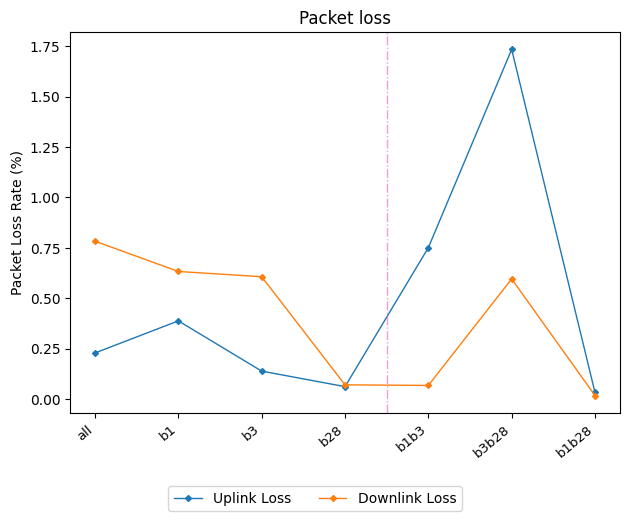

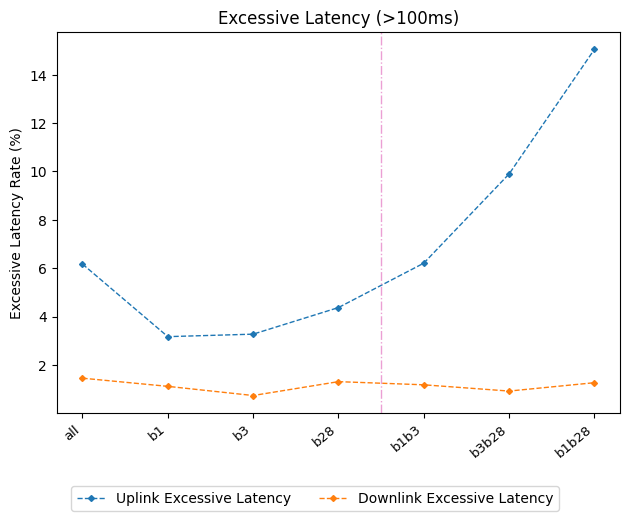

In [3]:
# /home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm03/#01/analysis/dwnlnk_udp_loss_statistics.csv
# /home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm03/#01/analysis/dwnlnk_udp_ex-latency_statistics.csv
# /home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm03/#01/analysis/uplnk_udp_loss_statistics.csv
# /home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm03/#01/analysis/uplnk_udp_ex-latency_statistics.csv

print(dset.keys())
ul_loss = [[[], []] for i in range(len(dset))]
ul_excslat = [[[], []] for i in range(len(dset))]
dl_loss = [[[], []] for i in range(len(dset))]
dl_excslat = [[[], []] for i in range(len(dset))]

for i, (key, item) in enumerate(dset.items()):
    for _round in item['rounds']:
        df1 = pd.read_csv(os.path.join(item['root'], _round, 'analysis', 'uplnk_udp_loss_statistics.csv'))
        df2 = pd.read_csv(os.path.join(item['root'], _round, 'analysis', 'uplnk_udp_ex-latency_statistics.csv'))
        df3 = pd.read_csv(os.path.join(item['root'], _round, 'analysis', 'dwnlnk_udp_loss_statistics.csv'))
        df4 = pd.read_csv(os.path.join(item['root'], _round, 'analysis', 'dwnlnk_udp_ex-latency_statistics.csv'))
        ul_loss[i][0].append(df1['total_packet_loss'].iloc[0])
        ul_loss[i][1].append(df1['total_packet_sent'].iloc[0])
        ul_excslat[i][0].append(df2['total_excessive_latency'].iloc[0])
        ul_excslat[i][1].append(df2['total_packet_recv'].iloc[0])
        dl_loss[i][0].append(df3['total_packet_loss'].iloc[0])
        dl_loss[i][1].append(df3['total_packet_sent'].iloc[0])
        dl_excslat[i][0].append(df4['total_excessive_latency'].iloc[0])
        dl_excslat[i][1].append(df4['total_packet_recv'].iloc[0])
for i in range(len(dset)):
    ul_loss[i] = round(sum(ul_loss[i][0]) / sum(ul_loss[i][1]) * 100, 3)
    ul_excslat[i] = round(sum(ul_excslat[i][0]) / sum(ul_excslat[i][1]) * 100, 3)
    dl_loss[i] = round(sum(dl_loss[i][0]) / sum(dl_loss[i][1]) * 100, 3)
    dl_excslat[i] = round(sum(dl_excslat[i][0]) / sum(dl_excslat[i][1]) * 100, 3)
print("UL Loss:", ul_loss)
print("UL Excs:", ul_excslat)
print("DL Loss:", dl_loss)
print("DL Excs:", dl_excslat)

# Plotting
x = np.arange(len(dset))  # the label locations

# Plot 1
fig, ax = plt.subplots()
# ax2 = ax.twinx()
ax.plot(x, ul_loss, c='tab:blue', linewidth=1, marker='D', markersize=3, label='Uplink Loss')
ax.plot(x, dl_loss, c='tab:orange', linewidth=1, marker='D', markersize=3, label='Downlink Loss')
# ax2.plot(x, ul_excslat, c='tab:blue', linestyle='--', linewidth=1, marker='D', markersize=3, label='Uplink Excessive Latency')
# ax2.plot(x, dl_excslat, c='tab:orange', linestyle='--', linewidth=1, marker='D', markersize=3, label='Downlink Excessive Latency')
ax.axvline((x[3] + x[4]) / 2, c='tab:pink', alpha=0.7, linestyle='-.', linewidth=1)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Packet Loss Rate (%)')
# ax2.set_ylabel('Excessive Latency Rate (%)')
# ax.set_title('Packet loss & Excessive latency')
ax.set_title('Packet loss')

axbox = ax.get_position()
fig.legend(
    # handles=handles, labels=labels,
    loc='lower center',
    bbox_to_anchor=[0, axbox.y0-0.2,1,1],
    ncol=2,
)

ax.set_xticks(x, dset.keys())
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")
fig.tight_layout()

plt.show()

# Plot 2
fig, ax2 = plt.subplots()
# ax2 = ax.twinx()
# ax.plot(x, ul_loss, c='tab:blue', linewidth=1, marker='D', markersize=3, label='Uplink Loss')
# ax.plot(x, dl_loss, c='tab:orange', linewidth=1, marker='D', markersize=3, label='Downlink Loss')
ax2.plot(x, ul_excslat, c='tab:blue', linestyle='--', linewidth=1, marker='D', markersize=3, label='Uplink Excessive Latency')
ax2.plot(x, dl_excslat, c='tab:orange', linestyle='--', linewidth=1, marker='D', markersize=3, label='Downlink Excessive Latency')
ax2.axvline((x[3] + x[4]) / 2, c='tab:pink', alpha=0.7, linestyle='-.', linewidth=1)

# Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Packet Loss Rate (%)')
ax2.set_ylabel('Excessive Latency Rate (%)')
# ax.set_title('Packet loss & Excessive latency')
ax2.set_title('Excessive Latency (>100ms)')

axbox = ax2.get_position()
fig.legend(
    # handles=handles, labels=labels,
    loc='lower center',
    bbox_to_anchor=[0, axbox.y0-0.2,1,1],
    ncol=2,
)

ax2.set_xticks(x, dset.keys())
ax2.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")
fig.tight_layout()

plt.show()

#### Handover Occurrence

,lte_handover,SN_addition,SN_removal,endc_SN_change,endc_MN_change,endc_MNSN_change,lte2endc_MN_change,endc2lte_MN_change,scg_failure,radio_link_failure,nas_recovery,succ_handoff,fail_handoff,total,experiment_time(sec)
all,12.0,23.0,17.0,23.0,61.0,1.0,0.0,2.0,2.0,5.0,0.0,139.0,7.0,146.0,1133.990386
b1,55.0,8.0,5.0,12.0,27.0,0.0,0.0,2.0,5.0,3.0,0.0,109.0,8.0,117.0,1135.2481189999999
b3,52.0,5.0,5.0,9.0,22.0,0.0,0.0,0.0,5.0,4.0,0.0,93.0,9.0,102.0,1138.833261
b28,38.0,21.0,12.0,21.0,47.0,0.0,0.0,10.0,4.0,0.0,0.0,149.0,4.0,153.0,1138.412403
b1b3,56.0,13.0,16.0,14.0,24.0,0.0,0.0,0.0,2.0,0.0,0.0,123.0,2.0,125.0,1131.25746
b3b28,51.0,14.0,14.0,16.0,21.0,0.0,0.0,1.0,3.0,3.0,0.0,117.0,6.0,123.0,1132.6243650000001
b1b28,31.0,22.0,21.0,19.0,38.0,0.0,0.0,1.0,1.0,0.0,0.0,132.0,1.0,133.0,1129.532853
+-------+--------------+-------------+------------+----------------+----------------+------------------+--------------------+--------------------+-------------+--------------------+--------------+-------

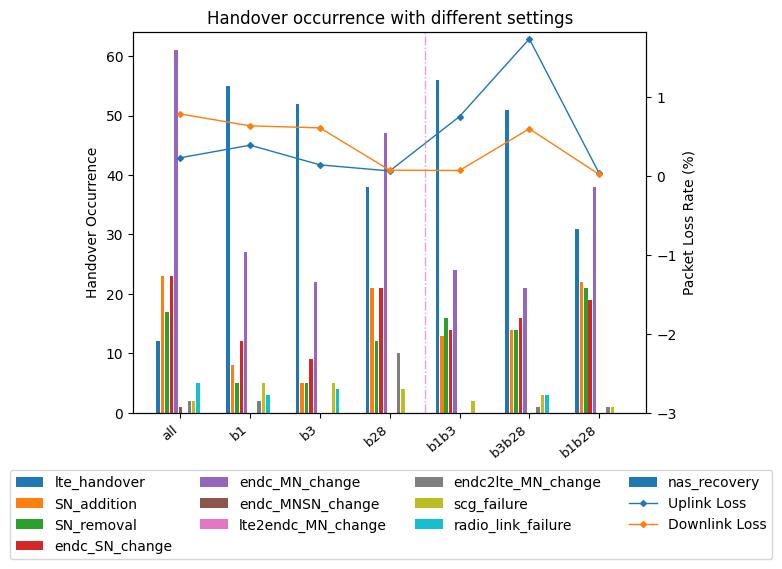

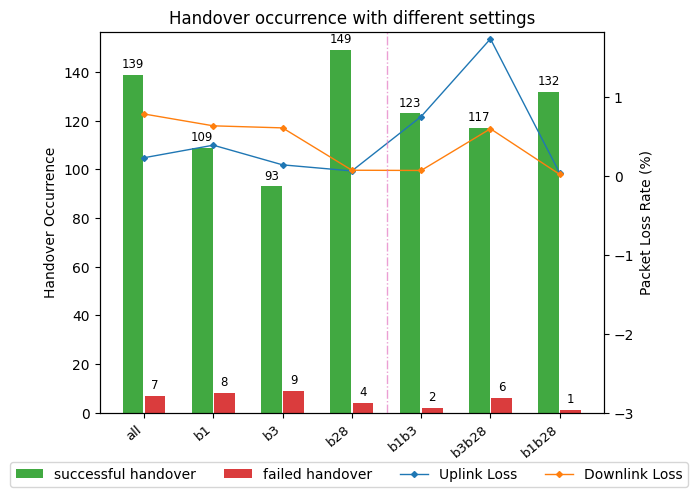

lte_handover
[12.0, 55.0, 52.0, 38.0, 56.0, 51.0, 31.0]
SN_addition
[23.0, 8.0, 5.0, 21.0, 13.0, 14.0, 22.0]
SN_removal
[17.0, 5.0, 5.0, 12.0, 16.0, 14.0, 21.0]
endc_SN_change
[23.0, 12.0, 9.0, 21.0, 14.0, 16.0, 19.0]
endc_MN_change
[61.0, 27.0, 22.0, 47.0, 24.0, 21.0, 38.0]
endc_MNSN_change
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
lte2endc_MN_change
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
endc2lte_MN_change
[2.0, 2.0, 0.0, 10.0, 0.0, 1.0, 1.0]
scg_failure
[2.0, 5.0, 5.0, 4.0, 2.0, 3.0, 1.0]
radio_link_failure
[5.0, 3.0, 4.0, 0.0, 0.0, 3.0, 0.0]
nas_recovery
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


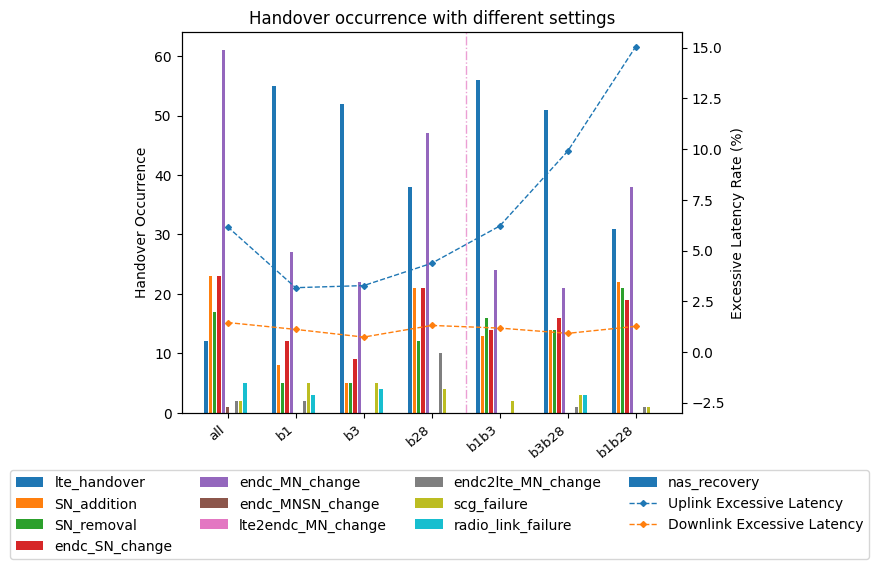

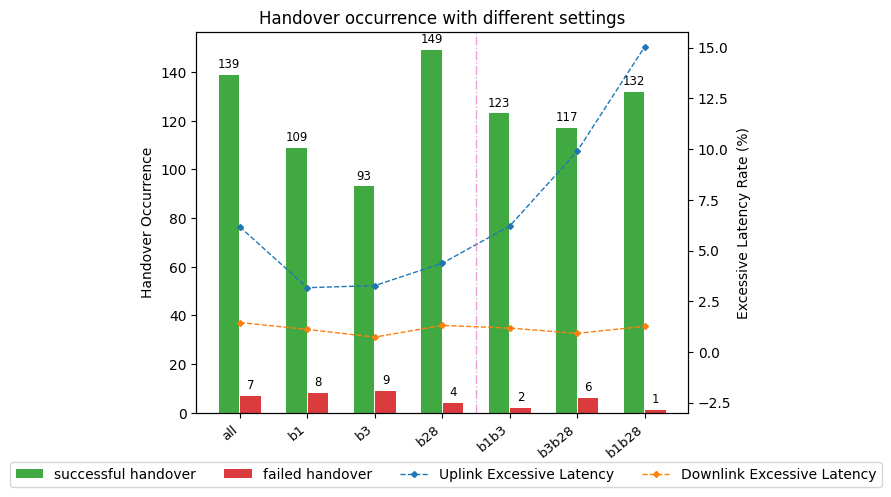

In [4]:
# /home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm03/#01/analysis/udp-loss-classify-50p/dwnlnk_ho_statistics.csv

header = ',lte_handover,SN_addition,SN_removal,endc_SN_change,endc_MN_change,endc_MNSN_change,lte2endc_MN_change,endc2lte_MN_change,scg_failure,radio_link_failure,nas_recovery,succ_handoff,fail_handoff,total,experiment_time(sec)'.split(',')
myTable = PrettyTable(header)
mydata = []
for key, item in dset.items():
    myrow = [key] + [0]*(len(header)-1)
    for _round in item['rounds']:
        df = pd.read_csv(os.path.join(item['root'], _round, 'analysis', 'udp-loss-classify-50p', 'dwnlnk_ho_statistics.csv'))
        tmp = list(df.iloc[0].array)
        for i, value in enumerate(tmp):
            myrow[i+1] += value
    mydata.append(myrow)
    myTable.add_row(myrow)

print(','.join(header))
for myrow in mydata:
    print(','.join([str(s) for s in myrow]))

print(myTable)

ho_types = "lte_handover,SN_addition,SN_removal,endc_SN_change,endc_MN_change,endc_MNSN_change,lte2endc_MN_change,endc2lte_MN_change,scg_failure,radio_link_failure,nas_recovery".split(',')
cmap = bpy_color_palette(len(ho_types), 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
color_dict = {ho_type : color for color, ho_type in zip(color_list, ho_types)}

# ho_times = [[]]*11  # duplicate values occur
ho_times_list = [[] for i in range(len(ho_types))]
for myrow in mydata:
    for i, value in enumerate(myrow[1:12]):
        ho_times_list[i].append(value)

# Plotting
x = np.arange(len(mydata))  # the label locations
width = 0.05  # the width of the bars
space = 0.7

# Plot 1
fig, ax = plt.subplots()
for i, (ho_type, ho_times, color) in enumerate(zip(ho_types, ho_times_list, color_list)):
    print(ho_type)
    print(ho_times)
    # ax.bar(x + space * (i-5) / len(ho_types), ho_times, width, color=color, label=ho_type)
    ax.bar(x + space * (i-5) / len(ho_types), ho_times, width, label=ho_type)

ax2 = ax.twinx()
ax2.plot(x, ul_loss, c='tab:blue', linewidth=1, marker='D', markersize=3, label='Uplink Loss')
ax2.plot(x, dl_loss, c='tab:orange', linewidth=1, marker='D', markersize=3, label='Downlink Loss')
ax2.axvline((x[3] + x[4]) / 2, c='tab:pink', alpha=0.7, linestyle='-.', linewidth=1)
ax2.set_ylim(-3)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_ylabel('Packet Loss Rate (%)')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Handover Occurrence')
ax.set_title('Handover occurrence with different settings')

axbox = ax.get_position()
fig.legend(
    # handles=handles, labels=labels,
    loc='lower center',
    bbox_to_anchor=[0, axbox.y0-0.3,1,1],
    ncol=4,
)

ax.set_xticks(x, dset.keys())
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")
fig.tight_layout()

plt.show()

# Plot 2
overall_ho_times_list = [[], []]
for myrow in mydata:
    for i, value in enumerate(myrow[12:14]):
        overall_ho_times_list[i].append(value)

x = np.arange(len(mydata))  # the label locations
width = 0.3  # the width of the bars
space = 0.32

fig, ax = plt.subplots()
# for i, (ho_type, ho_times, color) in enumerate(zip(ho_types, ho_times_list, color_list)):
#     print(ho_type)
#     print(ho_times)
#     # ax.bar(x + space * (i-5) / len(ho_types), ho_times, width, color=color, label=ho_type)
#     ax.bar(x + space * (i-5) / len(ho_types), ho_times, width, label=ho_type)

rects1 = ax.bar(x - space/2, overall_ho_times_list[0], width, color='tab:green', alpha=0.9, label='successful handover')
rects2 = ax.bar(x + space/2, overall_ho_times_list[1], width, color='tab:red', alpha=0.9, label='failed handover')

ax2 = ax.twinx()
ax2.plot(x, ul_loss, c='tab:blue', linewidth=1, marker='D', markersize=3, label='Uplink Loss')
ax2.plot(x, dl_loss, c='tab:orange', linewidth=1, marker='D', markersize=3, label='Downlink Loss')
ax2.axvline((x[3] + x[4]) / 2, c='tab:pink', alpha=0.7, linestyle='-.', linewidth=1)
ax2.set_ylim(-3)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_ylabel('Packet Loss Rate (%)')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Handover Occurrence')
ax.set_title('Handover occurrence with different settings')

axbox = ax.get_position()
fig.legend(
    # handles=handles, labels=labels,
    loc='lower center',
    bbox_to_anchor=[0, axbox.y0-0.15,1,1],
    ncol=4,
)

ax.set_xticks(x, dset.keys())
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax.bar_label(rects1, padding=3, fontsize=8.5)
ax.bar_label(rects2, padding=3, fontsize=8.5)

fig.tight_layout()

plt.show()

# Plot 3
width = 0.05  # the width of the bars
space = 0.7

fig, ax = plt.subplots()
for i, (ho_type, ho_times, color) in enumerate(zip(ho_types, ho_times_list, color_list)):
    print(ho_type)
    print(ho_times)
    # ax.bar(x + space * (i-5) / len(ho_types), ho_times, width, color=color, label=ho_type)
    ax.bar(x + space * (i-5) / len(ho_types), ho_times, width, label=ho_type)

ax2 = ax.twinx()
ax2.plot(x, ul_excslat, c='tab:blue', linestyle='--', linewidth=1, marker='D', markersize=3, label='Uplink Excessive Latency')
ax2.plot(x, dl_excslat, c='tab:orange', linestyle='--', linewidth=1, marker='D', markersize=3, label='Downlink Excessive Latency')
ax2.axvline((x[3] + x[4]) / 2, c='tab:pink', alpha=0.7, linestyle='-.', linewidth=1)
ax2.set_ylim(-3)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_ylabel('Excessive Latency Rate (%)')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Handover Occurrence')
ax.set_title('Handover occurrence with different settings')

axbox = ax.get_position()
fig.legend(
    # handles=handles, labels=labels,
    loc='lower center',
    bbox_to_anchor=[0, axbox.y0-0.3,1,1],
    ncol=4,
)

ax.set_xticks(x, dset.keys())
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")
fig.tight_layout()

plt.show()

# Plot 4
overall_ho_times_list = [[], []]
for myrow in mydata:
    for i, value in enumerate(myrow[12:14]):
        overall_ho_times_list[i].append(value)

x = np.arange(len(mydata))  # the label locations
width = 0.3  # the width of the bars
space = 0.32

fig, ax = plt.subplots()
# for i, (ho_type, ho_times, color) in enumerate(zip(ho_types, ho_times_list, color_list)):
#     print(ho_type)
#     print(ho_times)
#     # ax.bar(x + space * (i-5) / len(ho_types), ho_times, width, color=color, label=ho_type)
#     ax.bar(x + space * (i-5) / len(ho_types), ho_times, width, label=ho_type)

rects1 = ax.bar(x - space/2, overall_ho_times_list[0], width, color='tab:green', alpha=0.9, label='successful handover')
rects2 = ax.bar(x + space/2, overall_ho_times_list[1], width, color='tab:red', alpha=0.9, label='failed handover')

ax2 = ax.twinx()
ax2.plot(x, ul_excslat, c='tab:blue', linestyle='--', linewidth=1, marker='D', markersize=3, label='Uplink Excessive Latency')
ax2.plot(x, dl_excslat, c='tab:orange', linestyle='--', linewidth=1, marker='D', markersize=3, label='Downlink Excessive Latency')
ax2.axvline((x[3] + x[4]) / 2, c='tab:pink', alpha=0.7, linestyle='-.', linewidth=1)
ax2.set_ylim(-3)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_ylabel('Excessive Latency Rate (%)')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Handover Occurrence')
ax.set_title('Handover occurrence with different settings')

axbox = ax.get_position()
fig.legend(
    # handles=handles, labels=labels,
    loc='lower center',
    bbox_to_anchor=[0, axbox.y0-0.15,1,1],
    ncol=4,
)

ax.set_xticks(x, dset.keys())
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax.bar_label(rects1, padding=3, fontsize=8.5)
ax.bar_label(rects2, padding=3, fontsize=8.5)

fig.tight_layout()

plt.show()

[63, 25, 19, 54, 43, 44, 62]
[72, 79, 74, 95, 75, 67, 64]
[4, 5, 0, 0, 5, 6, 6]


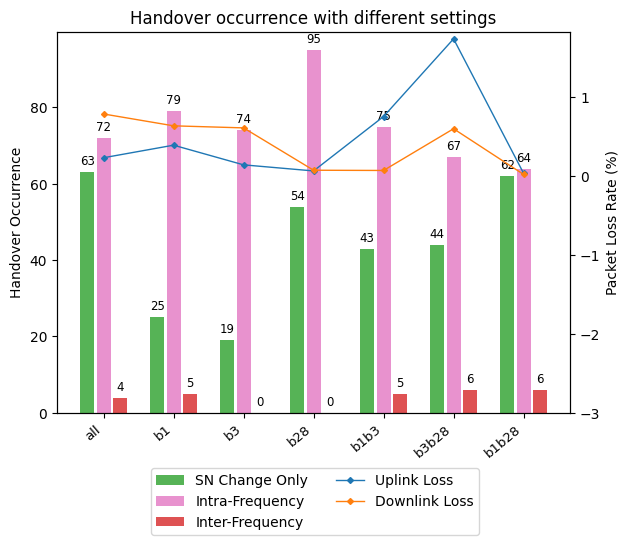

In [5]:
sn_change_list = [0]*len(dset)
intra_freq_list = [0]*len(dset)
inter_freq_list = [0]*len(dset)

for i, (key, item) in enumerate(dset.items()):
    for _round in item['rounds']:
        df = pd.read_csv(os.path.join(item['root'], _round, 'analysis', 'udp-loss-classify-50p', 'dwnlnk_ho_info.csv'))
        df = df[df['handoff_state'] == 'start']
        sn_change_list[i] += len(df[df['handoff_type.1'] == 'SN_change_only'])
        intra_freq_list[i] += len(df[df['handoff_type.1'] == 'Intra_frequency'])
        inter_freq_list[i] += len(df[df['handoff_type.1'] == 'Inter_frequency'])

print(sn_change_list)
print(intra_freq_list)
print(inter_freq_list)

# Plot 2
overall_ho_times_list = [[], []]
for myrow in mydata:
    for i, value in enumerate(myrow[12:14]):
        overall_ho_times_list[i].append(value)

x = np.arange(len(mydata))  # the label locations
width = 0.2  # the width of the bars
space = 0.7

fig, ax = plt.subplots()
# for i, (ho_type, ho_times, color) in enumerate(zip(ho_types, ho_times_list, color_list)):
#     print(ho_type)
#     print(ho_times)
#     # ax.bar(x + space * (i-5) / len(ho_types), ho_times, width, color=color, label=ho_type)
#     ax.bar(x + space * (i-5) / len(ho_types), ho_times, width, label=ho_type)

# ax.bar(x - space/2, overall_ho_times_list[0], width, color='tab:green', alpha=0.9, label='successful handover')
# ax.bar(x + space/2, overall_ho_times_list[1], width, color='tab:red', alpha=0.9, label='failed handover')

rects1 = ax.bar(x - space/3, sn_change_list, width, color='tab:green', alpha=0.8, label='SN Change Only')
rects2 = ax.bar(x          , intra_freq_list, width, color='tab:pink', alpha=0.8, label='Intra-Frequency')
rects3 = ax.bar(x + space/3, inter_freq_list, width, color='tab:red', alpha=0.8, label='Inter-Frequency')

ax2 = ax.twinx()
ax2.plot(x, ul_loss, c='tab:blue', linewidth=1, marker='D', markersize=3, label='Uplink Loss')
ax2.plot(x, dl_loss, c='tab:orange', linewidth=1, marker='D', markersize=3, label='Downlink Loss')
# ax2.axvline((x[3] + x[4]) / 2, c='tab:pink', alpha=0.7, linestyle='-.', linewidth=1)
ax2.set_ylim(-3)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_ylabel('Packet Loss Rate (%)')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Handover Occurrence')
ax.set_title('Handover occurrence with different settings')

axbox = ax.get_position()
fig.legend(
    # handles=handles, labels=labels,
    loc='lower center',
    bbox_to_anchor=[0, axbox.y0-0.25,1,1],
    ncol=2,
)

ax.set_xticks(x, dset.keys())
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax.bar_label(rects1, padding=3, fontsize=8.5)
ax.bar_label(rects2, padding=3, fontsize=8.5)
ax.bar_label(rects3, padding=3, fontsize=8.5)

fig.tight_layout()

plt.show()

#### Box Plot: Latency

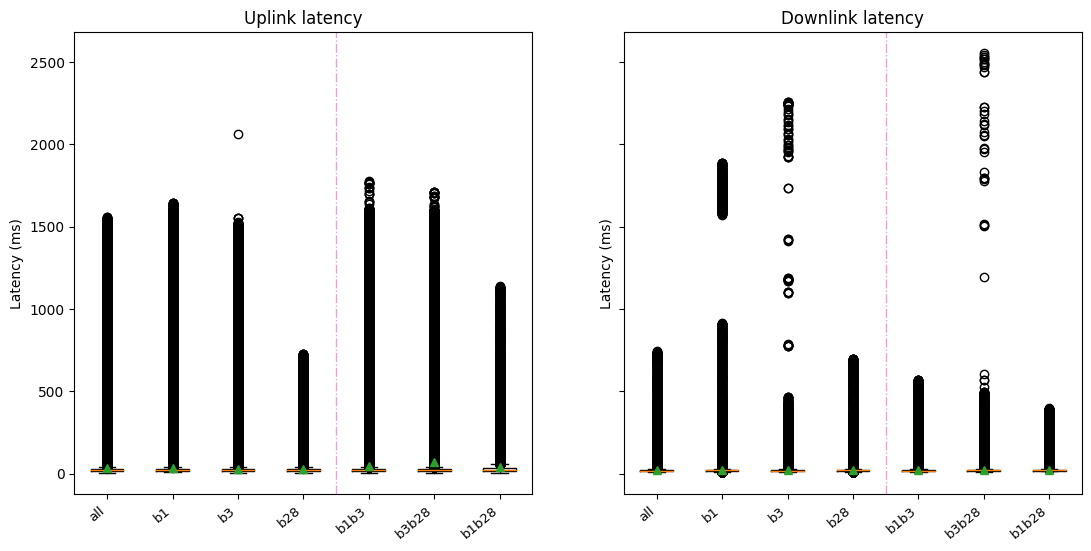

Length of list: 565703
-8.132500000000004 48.7175
Length of resulting list: 505838
Length of list: 562546
3.275625 31.054125
Length of resulting list: 543116
Length of list: 565439
-5.13600000000001 49.80000000000001
Length of resulting list: 534538
Length of list: 564006
5.677999999999992 34.45400000000001
Length of resulting list: 542693
Length of list: 568624
-5.225499999999993 46.58449999999999
Length of resulting list: 535606
Length of list: 565934
2.5580000000000105 35.05399999999999
Length of resulting list: 549244
Length of list: 568867
-9.451499999999996 52.930499999999995
Length of resulting list: 523204
Length of list: 568807
6.308000000000012 32.08399999999999
Length of resulting list: 540815
Length of list: 561400
-7.967499999999999 47.7305
Length of resulting list: 510647
Length of list: 565251
5.100500000000006 29.010499999999993
Length of resulting list: 542016
Length of list: 556477
-10.22000000000001 52.912000000000006
Length of resulting list: 481742
Length of list: 

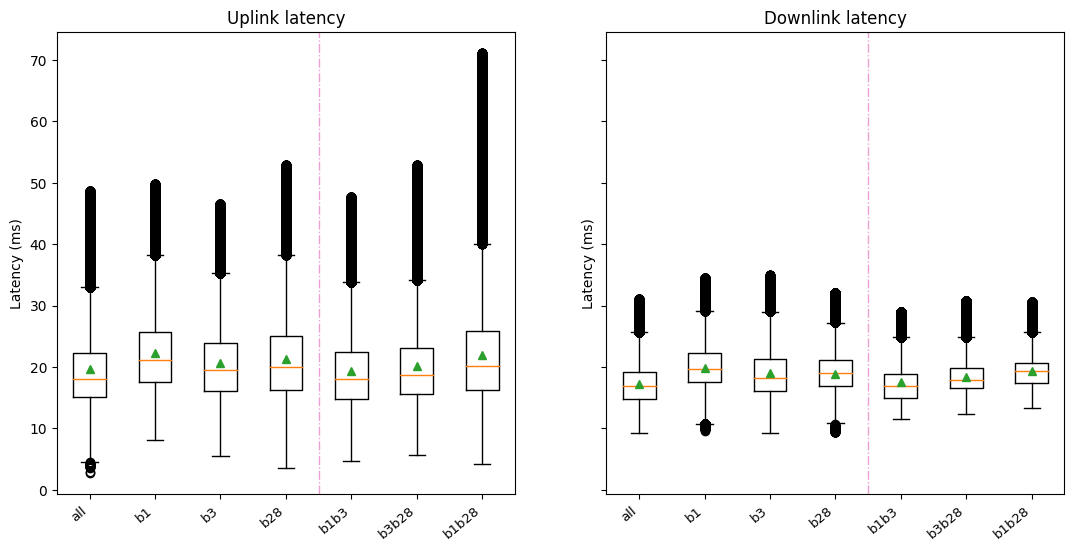

In [6]:
def del_outliers(num_list):
    _num_list = sorted(num_list)
    # print(_num_list)
    print("Length of list:", len(_num_list))

    upper_q = np.percentile(_num_list, 75)
    lower_q = np.percentile(_num_list, 25)
    # iqr = (upper_q - lower_q) * 1.5
    iqr = (upper_q - lower_q) * 2.5
    q_set = (lower_q - iqr, upper_q + iqr)
    print(q_set[0], q_set[1])

    result_list = []
    ret_list = []
    for i, x in enumerate(_num_list):
        if x >= q_set[0] and x <= q_set[1]:
            result_list.append(x)
            ret_list.append(i)
    # print(result_list)
    print("Length of resulting list:", len(result_list))
    return result_list, ret_list

# /home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm03/#01/analysis/dwnlnk_udp_latency.csv
# /home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm03/#01/analysis/uplnk_udp_latency.csv

ul_latency = [[] for i in range(len(dset))]
dl_latency = [[] for i in range(len(dset))]
for i, (key, item) in enumerate(dset.items()):
    for _round in item['rounds']:
        df1 = pd.read_csv(os.path.join(item['root'], _round, 'analysis', 'uplnk_udp_latency.csv'))
        df2 = pd.read_csv(os.path.join(item['root'], _round, 'analysis', 'dwnlnk_udp_latency.csv'))
        ul_latency[i] = [*ul_latency[i], *list(df1['latency'].array * 1000)]
        dl_latency[i] = [*dl_latency[i], *list(df2['latency'].array * 1000)]

# Plotting
# x = np.arange(len(dset))  # the label locations

# Plot 1
fig, (ax, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize =(13, 6))
ax.boxplot(ul_latency, showmeans=True)
# ax.plot(list(range(1, 10)), [mean(lst) for lst in ul_latency], c='tab:green', linestyle='--', linewidth=1)
ax2.boxplot(dl_latency, showmeans=True)
# ax2.plot(list(range(1, 10)), [mean(lst) for lst in dl_latency], c='tab:green', linestyle='--', linewidth=1)

ax.axvline(4.5, c='tab:pink', alpha=0.7, linestyle='-.', linewidth=1)
ax2.axvline(4.5, c='tab:pink', alpha=0.7, linestyle='-.', linewidth=1)

ax.set_xticks(list(range(1, len(dset)+1)), dset.keys())
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")
ax2.set_xticks(list(range(1, len(dset)+1)), dset.keys())
ax2.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

# fig.suptitle('Latency', fontsize=14)
ax.set_title('Uplink latency')
ax.set_ylabel('Latency (ms)')
ax2.set_title('Downlink latency')
ax2.set_ylabel('Latency (ms)')

plt.show()

# Plot 2
for i in range(len(dset)):
    ul_latency[i], _ = del_outliers(ul_latency[i])
    dl_latency[i], _ = del_outliers(dl_latency[i])

fig, (ax, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize =(13, 6))
ax.boxplot(ul_latency, showmeans=True)
# ax.plot(list(range(1,10)), [mean(lst) for lst in ul_latency], c='tab:green', linestyle='--', linewidth=1)
ax2.boxplot(dl_latency, showmeans=True)
# ax2.plot(list(range(1,10)), [mean(lst) for lst in dl_latency], c='tab:green', linestyle='--', linewidth=1)

ax.axvline(4.5, c='tab:pink', alpha=0.7, linestyle='-.', linewidth=1)
ax2.axvline(4.5, c='tab:pink', alpha=0.7, linestyle='-.', linewidth=1)

ax.set_xticks(list(range(1, len(dset)+1)), dset.keys())
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")
ax2.set_xticks(list(range(1, len(dset)+1)), dset.keys())
ax2.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

# fig.suptitle('Latency', fontsize=14)
ax.set_title('Uplink latency')
ax.set_ylabel('Latency (ms)')
ax2.set_title('Downlink latency')
ax2.set_ylabel('Latency (ms)')

plt.show()

#### Handover Interruption Time

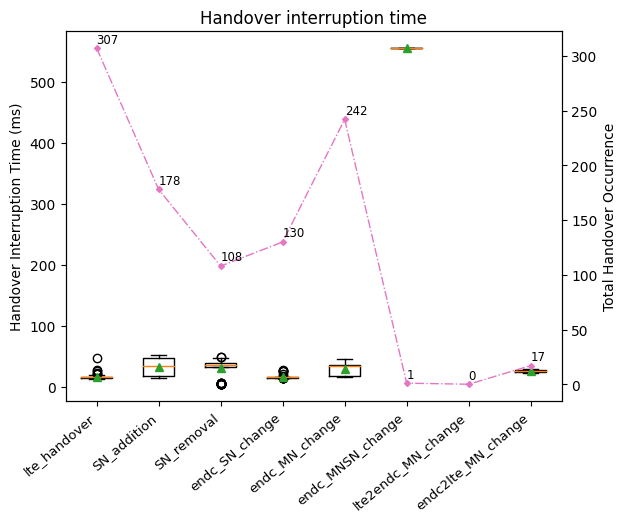

In [7]:
# /home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm03/#01/analysis/diag_log_ho-info.csv

ho_types = "lte_handover,SN_addition,SN_removal,endc_SN_change,endc_MN_change,endc_MNSN_change,lte2endc_MN_change,endc2lte_MN_change".split(',')
ho_duration_list = [[] for i in range(len(ho_types))]

for j, (key, item) in enumerate(dset.items()):
    for _round in item['rounds']:
        df = pd.read_csv(os.path.join(item['root'], _round, 'analysis', 'diag_log_ho-info.csv'))
        df = df[df['handoff_state'] == 'start']
        for i, ho_type in enumerate(ho_types):
            ho_duration_list[i] = [*ho_duration_list[i], *list(df[df['handoff_type'] == ho_type]['handoff_duration'].array * 1000)]

# total_ho_duration_list = [sum(lst) / 1000 for lst in ho_duration_list]
total_ho_occurrence_list = [len(lst) for lst in ho_duration_list]

# Plotting
# x = np.arange(len(dset))  # the label locations

fig, ax = plt.subplots()
ax.boxplot(ho_duration_list, showmeans=True)

ax.set_xticks(list(range(1, 9)), ho_types)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax.set_title('Handover interruption time')
ax.set_ylabel('Handover Interruption Time (ms)')

ax2 = ax.twinx()
ax2.plot(list(range(1, 9)), total_ho_occurrence_list, c='tab:pink', linestyle='-.', linewidth=1, marker='D', markersize=3)
ax2.set_ylabel('Total Handover Occurrence')
for i, txt in enumerate(total_ho_occurrence_list):
    ax2.annotate(str(total_ho_occurrence_list[i]), (list(range(1, 9))[i], total_ho_occurrence_list[i]+5), size=8.5)

plt.show()

#### Handover Classification: Bar Chart

/tmp/ipykernel_31622/1901893984.py:70: RuntimeWarning: invalid value encountered in long_scalars
  before_event_ul_ho_loss[i] = round(sum(before_event_ul_ho_loss[i][0]) / sum(before_event_ul_ho_loss[i][1]) * 100, 3)
/tmp/ipykernel_31622/1901893984.py:71: RuntimeWarning: invalid value encountered in long_scalars
  during_event_ul_ho_loss[i] = round(sum(during_event_ul_ho_loss[i][0]) / sum(during_event_ul_ho_loss[i][1]) * 100, 3)
/tmp/ipykernel_31622/1901893984.py:72: RuntimeWarning: invalid value encountered in long_scalars
  after_event_ul_ho_loss[i]  = round(sum(after_event_ul_ho_loss[i][0]) / sum(after_event_ul_ho_loss[i][1]) * 100, 3)
/tmp/ipykernel_31622/1901893984.py:76: RuntimeWarning: invalid value encountered in long_scalars
  before_event_ul_rlf_loss[i] = round(sum(before_event_ul_rlf_loss[i][0]) / sum(before_event_ul_rlf_loss[i][1]) * 100, 3)
/tmp/ipykernel_31622/1901893984.py:77: RuntimeWarning: invalid value encountered in long_scalars
  after_event_ul_rlf_loss[i]  = round(

[1.846, 6.254, 0.199, 0.029, 0.43, 14.072, nan, 0.023]
[1.38, 4.35, 0.152, 0.0, 0.682, 0.0, nan, 0.0]
[0.94, 1.248, 1.249, 0.111, 0.388, 7.2, nan, 0.021]
0.476
[0.14, 15.248, nan]
[0.0, 0.788, nan]
0.476


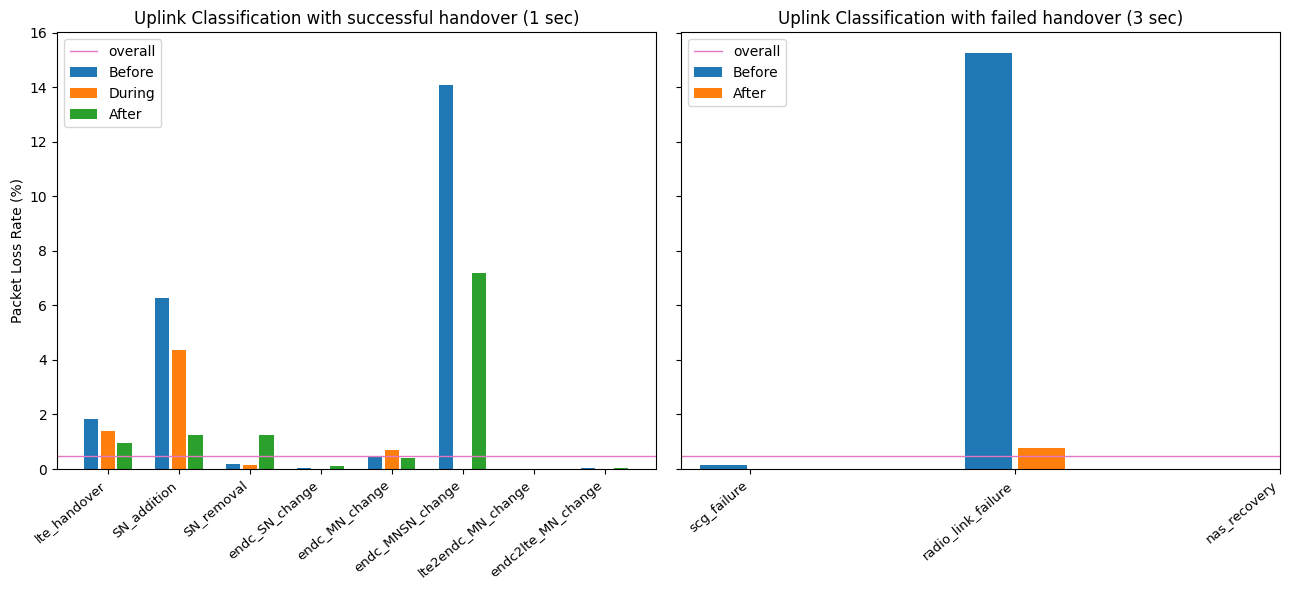

In [8]:
# /home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm03/#01/analysis/udp-excslat-classify-50p/dwnlnk_excslat_ho_classify_1.csv
# /home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm03/#01/analysis/udp-excslat-classify-50p/dwnlnk_excslat_ho_classify_3.csv

ho_types = "lte_handover,SN_addition,SN_removal,endc_SN_change,endc_MN_change,endc_MNSN_change,lte2endc_MN_change,endc2lte_MN_change".split(',')
rlf_types = "scg_failure,radio_link_failure,nas_recovery".split(',')

# print(dset.keys())
before_event_ul_ho_loss  = [[[], []] for i in range(len(ho_types))]
during_event_ul_ho_loss  = [[[], []] for i in range(len(ho_types))]
after_event_ul_ho_loss   = [[[], []] for i in range(len(ho_types))]
total_ul_ho_loss  = [[], []]
before_event_ul_rlf_loss = [[[], []] for i in range(len(rlf_types))]
after_event_ul_rlf_loss  = [[[], []] for i in range(len(rlf_types))]
total_ul_rlf_loss = [[], []]

# before_event_ul_ho_excslat  = [[[], []] for i in range(len(ho_types))]
# during_event_ul_ho_excslat  = [[[], []] for i in range(len(ho_types))]
# after_event_ul_ho_excslat   = [[[], []] for i in range(len(ho_types))]
# total_ul_ho_excslat  = [[], []]
# before_event_ul_rlf_excslat = [[[], []] for i in range(len(rlf_types))]
# after_event_ul_rlf_excslat  = [[[], []] for i in range(len(rlf_types))]
# total_ul_rlf_excslat = [[], []]

# before_event_dl_ho_loss  = [[[], []] for i in range(len(ho_types))]
# during_event_dl_ho_loss  = [[[], []] for i in range(len(ho_types))]
# after_event_dl_ho_loss   = [[[], []] for i in range(len(ho_types))]
# total_dl_ho_loss  = [[], []]
# before_event_dl_rlf_loss = [[[], []] for i in range(len(rlf_types))]
# after_event_dl_rlf_loss  = [[[], []] for i in range(len(rlf_types))]
# total_dl_rlf_loss = [[], []]

# before_event_dl_ho_excslat  = [[[], []] for i in range(len(ho_types))]
# during_event_dl_ho_excslat  = [[[], []] for i in range(len(ho_types))]
# after_event_dl_ho_excslat   = [[[], []] for i in range(len(ho_types))]
# total_dl_ho_excslat  = [[], []]
# before_event_dl_rlf_excslat = [[[], []] for i in range(len(rlf_types))]
# after_event_dl_rlf_excslat  = [[[], []] for i in range(len(rlf_types))]
# total_dl_rlf_excslat = [[], []]

for j, (key, item) in enumerate(dset.items()):
    for _round in item['rounds']:
        df1 = pd.read_csv(os.path.join(item['root'], _round, 'analysis', 'udp-loss-classify-50p', 'uplnk_loss_ho_classify_1.csv'))
        df2 = pd.read_csv(os.path.join(item['root'], _round, 'analysis', 'udp-loss-classify-50p', 'uplnk_loss_ho_classify_3.csv'))
        # df3 = pd.read_csv(os.path.join(item['root'], _round, 'analysis', 'udp-loss-classify-50p', 'dwnlnk_loss_ho_classify_1.csv'))
        # df4 = pd.read_csv(os.path.join(item['root'], _round, 'analysis', 'udp-loss-classify-50p', 'dwnlnk_loss_ho_classify_3.csv'))
        # df5 = pd.read_csv(os.path.join(item['root'], _round, 'analysis', 'udp-excslat-classify-50p', 'uplnk_excslat_ho_classify_1.csv'))
        # df6 = pd.read_csv(os.path.join(item['root'], _round, 'analysis', 'udp-excslat-classify-50p', 'uplnk_excslat_ho_classify_3.csv'))
        # df7 = pd.read_csv(os.path.join(item['root'], _round, 'analysis', 'udp-excslat-classify-50p', 'dwnlnk_excslat_ho_classify_1.csv'))
        # df8 = pd.read_csv(os.path.join(item['root'], _round, 'analysis', 'udp-excslat-classify-50p', 'dwnlnk_excslat_ho_classify_3.csv'))
        
        for i, ho_type in enumerate(ho_types):
            before_event_ul_ho_loss[i][0].append(df1['packet_loss_num'].iloc[3*i])
            before_event_ul_ho_loss[i][1].append(df1['total_packet_num'].iloc[3*i])
            during_event_ul_ho_loss[i][0].append(df1['packet_loss_num'].iloc[3*i + 1])
            during_event_ul_ho_loss[i][1].append(df1['total_packet_num'].iloc[3*i + 1])
            after_event_ul_ho_loss[i][0].append(df1['packet_loss_num'].iloc[3*i + 2])
            after_event_ul_ho_loss[i][1].append(df1['total_packet_num'].iloc[3*i + 2])
        total_ul_ho_loss[0].append(df1['packet_loss_num'].iloc[37])
        total_ul_ho_loss[1].append(df1['total_packet_num'].iloc[37])

        for i, ho_type in enumerate(rlf_types):
            before_event_ul_rlf_loss[i][0].append(df2['packet_loss_num'].iloc[24 + 2*i])
            before_event_ul_rlf_loss[i][1].append(df2['total_packet_num'].iloc[24 + 2*i])
            after_event_ul_rlf_loss[i][0].append(df2['packet_loss_num'].iloc[24 + 2*i + 1])
            after_event_ul_rlf_loss[i][1].append(df2['total_packet_num'].iloc[24 + 2*i + 1])
        total_ul_rlf_loss[0].append(df2['packet_loss_num'].iloc[37])
        total_ul_rlf_loss[1].append(df2['total_packet_num'].iloc[37])

for i in range(len(ho_types)):
    before_event_ul_ho_loss[i] = round(sum(before_event_ul_ho_loss[i][0]) / sum(before_event_ul_ho_loss[i][1]) * 100, 3)
    during_event_ul_ho_loss[i] = round(sum(during_event_ul_ho_loss[i][0]) / sum(during_event_ul_ho_loss[i][1]) * 100, 3)
    after_event_ul_ho_loss[i]  = round(sum(after_event_ul_ho_loss[i][0]) / sum(after_event_ul_ho_loss[i][1]) * 100, 3)
total_ul_ho_loss = round(sum(total_ul_ho_loss[0]) / sum(total_ul_ho_loss[1]) * 100, 3)

for i in range(len(rlf_types)):
    before_event_ul_rlf_loss[i] = round(sum(before_event_ul_rlf_loss[i][0]) / sum(before_event_ul_rlf_loss[i][1]) * 100, 3)
    after_event_ul_rlf_loss[i]  = round(sum(after_event_ul_rlf_loss[i][0]) / sum(after_event_ul_rlf_loss[i][1]) * 100, 3)
total_ul_rlf_loss = round(sum(total_ul_rlf_loss[0]) / sum(total_ul_rlf_loss[1]) * 100, 3)

print(before_event_ul_ho_loss)
print(during_event_ul_ho_loss)
print(after_event_ul_ho_loss)
print(total_ul_ho_loss)

print(before_event_ul_rlf_loss)
print(after_event_ul_rlf_loss)
print(total_ul_rlf_loss)

x = np.arange(len(ho_types))  # the label locations
width = 0.2  # the width of the bars
space = 0.7

fig, (ax, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize =(13, 6))
rects1 = ax.bar(x - space/3, before_event_ul_ho_loss, width, label='Before')
rects2 = ax.bar(x          , during_event_ul_ho_loss, width, label='During')
rects3 = ax.bar(x + space/3, after_event_ul_ho_loss, width, label='After')
ax.axhline(total_ul_ho_loss, c = 'tab:pink', linewidth=1, label='overall')

x2 = np.arange(len(rlf_types))  # the label locations
width = 0.18  # the width of the bars
space = 0.2
rects4 = ax2.bar(x2 - space/2, before_event_ul_rlf_loss, width, label='Before')
rects5 = ax2.bar(x2 + space/2, after_event_ul_rlf_loss, width, label='After')
ax2.axhline(total_ul_ho_loss, c = 'tab:pink', linewidth=1, label='overall')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Packet Loss Rate (%)')
ax.set_title('Uplink Classification with successful handover (1 sec)')
ax2.set_title('Uplink Classification with failed handover (3 sec)')
ax.legend()
ax2.legend()

ax.set_xticks(x, ho_types)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")
ax2.set_xticks(x2, rlf_types)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")
fig.tight_layout()

plt.show()

/tmp/ipykernel_31622/350249972.py:70: RuntimeWarning: invalid value encountered in long_scalars
  before_event_ul_ho_excslat[i] = round(sum(before_event_ul_ho_excslat[i][0]) / sum(before_event_ul_ho_excslat[i][1]) * 100, 3)
/tmp/ipykernel_31622/350249972.py:71: RuntimeWarning: invalid value encountered in long_scalars
  during_event_ul_ho_excslat[i] = round(sum(during_event_ul_ho_excslat[i][0]) / sum(during_event_ul_ho_excslat[i][1]) * 100, 3)
/tmp/ipykernel_31622/350249972.py:72: RuntimeWarning: invalid value encountered in long_scalars
  after_event_ul_ho_excslat[i]  = round(sum(after_event_ul_ho_excslat[i][0]) / sum(after_event_ul_ho_excslat[i][1]) * 100, 3)
/tmp/ipykernel_31622/350249972.py:76: RuntimeWarning: invalid value encountered in long_scalars
  before_event_ul_rlf_excslat[i] = round(sum(before_event_ul_rlf_excslat[i][0]) / sum(before_event_ul_rlf_excslat[i][1]) * 100, 3)
/tmp/ipykernel_31622/350249972.py:77: RuntimeWarning: invalid value encountered in long_scalars
  after

[8.843, 21.034, 32.438, 7.527, 9.409, 85.928, nan, 8.639]
[14.286, 18.474, 32.928, 9.257, 10.997, 69.424, nan, 6.897]
[15.005, 18.417, 39.808, 13.89, 18.392, 97.6, nan, 8.728]
6.83
[41.15, 34.877, nan]
[31.159, 21.861, nan]
6.83


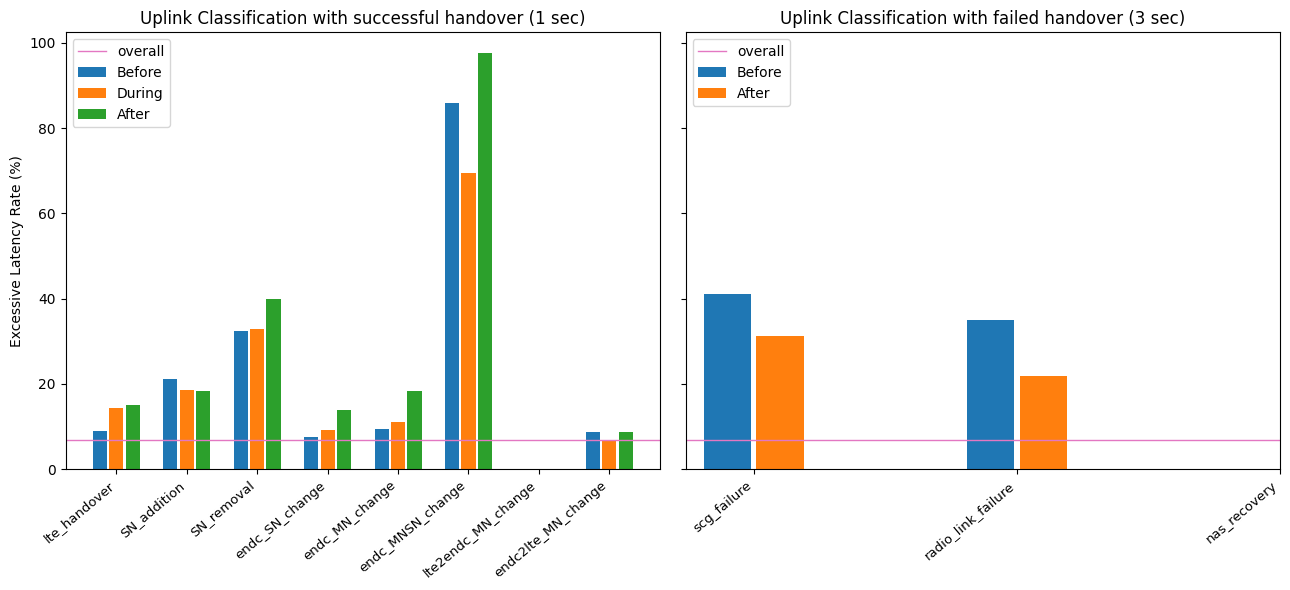

In [9]:
# /home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm03/#01/analysis/udp-excslat-classify-50p/dwnlnk_excslat_ho_classify_1.csv
# /home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm03/#01/analysis/udp-excslat-classify-50p/dwnlnk_excslat_ho_classify_3.csv

ho_types = "lte_handover,SN_addition,SN_removal,endc_SN_change,endc_MN_change,endc_MNSN_change,lte2endc_MN_change,endc2lte_MN_change".split(',')
rlf_types = "scg_failure,radio_link_failure,nas_recovery".split(',')

# print(dset.keys())
# before_event_ul_ho_loss  = [[[], []] for i in range(len(ho_types))]
# during_event_ul_ho_loss  = [[[], []] for i in range(len(ho_types))]
# after_event_ul_ho_loss   = [[[], []] for i in range(len(ho_types))]
# total_ul_ho_loss  = [[], []]
# before_event_ul_rlf_loss = [[[], []] for i in range(len(rlf_types))]
# after_event_ul_rlf_loss  = [[[], []] for i in range(len(rlf_types))]
# total_ul_rlf_loss = [[], []]

before_event_ul_ho_excslat  = [[[], []] for i in range(len(ho_types))]
during_event_ul_ho_excslat  = [[[], []] for i in range(len(ho_types))]
after_event_ul_ho_excslat   = [[[], []] for i in range(len(ho_types))]
total_ul_ho_excslat  = [[], []]
before_event_ul_rlf_excslat = [[[], []] for i in range(len(rlf_types))]
after_event_ul_rlf_excslat  = [[[], []] for i in range(len(rlf_types))]
total_ul_rlf_excslat = [[], []]

# before_event_dl_ho_loss  = [[[], []] for i in range(len(ho_types))]
# during_event_dl_ho_loss  = [[[], []] for i in range(len(ho_types))]
# after_event_dl_ho_loss   = [[[], []] for i in range(len(ho_types))]
# total_dl_ho_loss  = [[], []]
# before_event_dl_rlf_loss = [[[], []] for i in range(len(rlf_types))]
# after_event_dl_rlf_loss  = [[[], []] for i in range(len(rlf_types))]
# total_dl_rlf_loss = [[], []]

# before_event_dl_ho_excslat  = [[[], []] for i in range(len(ho_types))]
# during_event_dl_ho_excslat  = [[[], []] for i in range(len(ho_types))]
# after_event_dl_ho_excslat   = [[[], []] for i in range(len(ho_types))]
# total_dl_ho_excslat  = [[], []]
# before_event_dl_rlf_excslat = [[[], []] for i in range(len(rlf_types))]
# after_event_dl_rlf_excslat  = [[[], []] for i in range(len(rlf_types))]
# total_dl_rlf_excslat = [[], []]

for j, (key, item) in enumerate(dset.items()):
    for _round in item['rounds']:
        # df1 = pd.read_csv(os.path.join(item['root'], _round, 'analysis', 'udp-loss-classify-50p', 'uplnk_loss_ho_classify_1.csv'))
        # df2 = pd.read_csv(os.path.join(item['root'], _round, 'analysis', 'udp-loss-classify-50p', 'uplnk_loss_ho_classify_3.csv'))
        # df3 = pd.read_csv(os.path.join(item['root'], _round, 'analysis', 'udp-loss-classify-50p', 'dwnlnk_loss_ho_classify_1.csv'))
        # df4 = pd.read_csv(os.path.join(item['root'], _round, 'analysis', 'udp-loss-classify-50p', 'dwnlnk_loss_ho_classify_3.csv'))
        df5 = pd.read_csv(os.path.join(item['root'], _round, 'analysis', 'udp-excslat-classify-50p', 'uplnk_excslat_ho_classify_1.csv'))
        df6 = pd.read_csv(os.path.join(item['root'], _round, 'analysis', 'udp-excslat-classify-50p', 'uplnk_excslat_ho_classify_3.csv'))
        # df7 = pd.read_csv(os.path.join(item['root'], _round, 'analysis', 'udp-excslat-classify-50p', 'dwnlnk_excslat_ho_classify_1.csv'))
        # df8 = pd.read_csv(os.path.join(item['root'], _round, 'analysis', 'udp-excslat-classify-50p', 'dwnlnk_excslat_ho_classify_3.csv'))
        
        for i, ho_type in enumerate(ho_types):
            before_event_ul_ho_excslat[i][0].append(df5['packet_loss_num'].iloc[3*i])
            before_event_ul_ho_excslat[i][1].append(df5['total_packet_num'].iloc[3*i])
            during_event_ul_ho_excslat[i][0].append(df5['packet_loss_num'].iloc[3*i + 1])
            during_event_ul_ho_excslat[i][1].append(df5['total_packet_num'].iloc[3*i + 1])
            after_event_ul_ho_excslat[i][0].append(df5['packet_loss_num'].iloc[3*i + 2])
            after_event_ul_ho_excslat[i][1].append(df5['total_packet_num'].iloc[3*i + 2])
        total_ul_ho_excslat[0].append(df5['packet_loss_num'].iloc[37])
        total_ul_ho_excslat[1].append(df5['total_packet_num'].iloc[37])

        for i, ho_type in enumerate(rlf_types):
            before_event_ul_rlf_excslat[i][0].append(df6['packet_loss_num'].iloc[24 + 2*i])
            before_event_ul_rlf_excslat[i][1].append(df6['total_packet_num'].iloc[24 + 2*i])
            after_event_ul_rlf_excslat[i][0].append(df6['packet_loss_num'].iloc[24 + 2*i + 1])
            after_event_ul_rlf_excslat[i][1].append(df6['total_packet_num'].iloc[24 + 2*i + 1])
        total_ul_rlf_excslat[0].append(df6['packet_loss_num'].iloc[37])
        total_ul_rlf_excslat[1].append(df6['total_packet_num'].iloc[37])

for i in range(len(ho_types)):
    before_event_ul_ho_excslat[i] = round(sum(before_event_ul_ho_excslat[i][0]) / sum(before_event_ul_ho_excslat[i][1]) * 100, 3)
    during_event_ul_ho_excslat[i] = round(sum(during_event_ul_ho_excslat[i][0]) / sum(during_event_ul_ho_excslat[i][1]) * 100, 3)
    after_event_ul_ho_excslat[i]  = round(sum(after_event_ul_ho_excslat[i][0]) / sum(after_event_ul_ho_excslat[i][1]) * 100, 3)
total_ul_ho_excslat = round(sum(total_ul_ho_excslat[0]) / sum(total_ul_ho_excslat[1]) * 100, 3)

for i in range(len(rlf_types)):
    before_event_ul_rlf_excslat[i] = round(sum(before_event_ul_rlf_excslat[i][0]) / sum(before_event_ul_rlf_excslat[i][1]) * 100, 3)
    after_event_ul_rlf_excslat[i]  = round(sum(after_event_ul_rlf_excslat[i][0]) / sum(after_event_ul_rlf_excslat[i][1]) * 100, 3)
total_ul_rlf_excslat = round(sum(total_ul_rlf_excslat[0]) / sum(total_ul_rlf_excslat[1]) * 100, 3)

print(before_event_ul_ho_excslat)
print(during_event_ul_ho_excslat)
print(after_event_ul_ho_excslat)
print(total_ul_ho_excslat)

print(before_event_ul_rlf_excslat)
print(after_event_ul_rlf_excslat)
print(total_ul_rlf_excslat)

x = np.arange(len(ho_types))  # the label locations
width = 0.2  # the width of the bars
space = 0.7

fig, (ax, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize =(13, 6))
rects1 = ax.bar(x - space/3, before_event_ul_ho_excslat, width, label='Before')
rects2 = ax.bar(x          , during_event_ul_ho_excslat, width, label='During')
rects3 = ax.bar(x + space/3, after_event_ul_ho_excslat, width, label='After')
ax.axhline(total_ul_ho_excslat, c = 'tab:pink', linewidth=1, label='overall')

x2 = np.arange(len(rlf_types))  # the label locations
width = 0.18  # the width of the bars
space = 0.2
rects4 = ax2.bar(x2 - space/2, before_event_ul_rlf_excslat, width, label='Before')
rects5 = ax2.bar(x2 + space/2, after_event_ul_rlf_excslat, width, label='After')
ax2.axhline(total_ul_ho_excslat, c = 'tab:pink', linewidth=1, label='overall')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Excessive Latency Rate (%)')
ax.set_title('Uplink Classification with successful handover (1 sec)')
ax2.set_title('Uplink Classification with failed handover (3 sec)')
ax.legend()
ax2.legend()

ax.set_xticks(x, ho_types)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")
ax2.set_xticks(x2, rlf_types)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")
fig.tight_layout()

plt.show()

/tmp/ipykernel_31622/903286326.py:70: RuntimeWarning: invalid value encountered in long_scalars
  before_event_dl_ho_loss[i] = round(sum(before_event_dl_ho_loss[i][0]) / sum(before_event_dl_ho_loss[i][1]) * 100, 3)
/tmp/ipykernel_31622/903286326.py:71: RuntimeWarning: invalid value encountered in long_scalars
  during_event_dl_ho_loss[i] = round(sum(during_event_dl_ho_loss[i][0]) / sum(during_event_dl_ho_loss[i][1]) * 100, 3)
/tmp/ipykernel_31622/903286326.py:72: RuntimeWarning: invalid value encountered in long_scalars
  after_event_dl_ho_loss[i]  = round(sum(after_event_dl_ho_loss[i][0]) / sum(after_event_dl_ho_loss[i][1]) * 100, 3)
/tmp/ipykernel_31622/903286326.py:76: RuntimeWarning: invalid value encountered in long_scalars
  before_event_dl_rlf_loss[i] = round(sum(before_event_dl_rlf_loss[i][0]) / sum(before_event_dl_rlf_loss[i][1]) * 100, 3)
/tmp/ipykernel_31622/903286326.py:77: RuntimeWarning: invalid value encountered in long_scalars
  after_event_dl_rlf_loss[i]  = round(sum(a

[0.57, 13.422, 0.915, 0.015, 0.32, 101.198, nan, 0.0]
[0.623, 7.113, 1.141, 0.0, 0.512, 106.475, nan, 0.0]
[0.268, 3.676, 0.825, 0.228, 0.44, 42.6, nan, 0.186]
0.397
[1.382, 31.556, nan]
[2.899, 69.782, nan]
0.397


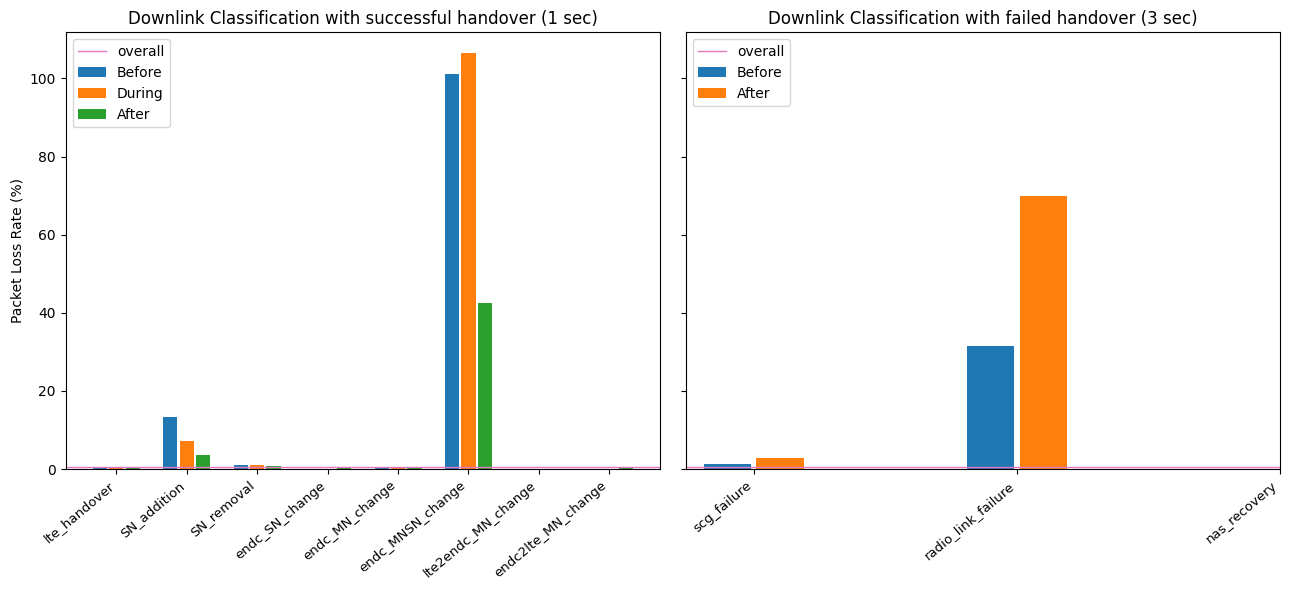

In [10]:
# /home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm03/#01/analysis/udp-excslat-classify-50p/dwnlnk_excslat_ho_classify_1.csv
# /home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm03/#01/analysis/udp-excslat-classify-50p/dwnlnk_excslat_ho_classify_3.csv

ho_types = "lte_handover,SN_addition,SN_removal,endc_SN_change,endc_MN_change,endc_MNSN_change,lte2endc_MN_change,endc2lte_MN_change".split(',')
rlf_types = "scg_failure,radio_link_failure,nas_recovery".split(',')

# print(dset.keys())
# before_event_ul_ho_loss  = [[[], []] for i in range(len(ho_types))]
# during_event_ul_ho_loss  = [[[], []] for i in range(len(ho_types))]
# after_event_ul_ho_loss   = [[[], []] for i in range(len(ho_types))]
# total_ul_ho_loss  = [[], []]
# before_event_ul_rlf_loss = [[[], []] for i in range(len(rlf_types))]
# after_event_ul_rlf_loss  = [[[], []] for i in range(len(rlf_types))]
# total_ul_rlf_loss = [[], []]

# before_event_ul_ho_excslat  = [[[], []] for i in range(len(ho_types))]
# during_event_ul_ho_excslat  = [[[], []] for i in range(len(ho_types))]
# after_event_ul_ho_excslat   = [[[], []] for i in range(len(ho_types))]
# total_ul_ho_excslat  = [[], []]
# before_event_ul_rlf_excslat = [[[], []] for i in range(len(rlf_types))]
# after_event_ul_rlf_excslat  = [[[], []] for i in range(len(rlf_types))]
# total_ul_rlf_excslat = [[], []]

before_event_dl_ho_loss  = [[[], []] for i in range(len(ho_types))]
during_event_dl_ho_loss  = [[[], []] for i in range(len(ho_types))]
after_event_dl_ho_loss   = [[[], []] for i in range(len(ho_types))]
total_dl_ho_loss  = [[], []]
before_event_dl_rlf_loss = [[[], []] for i in range(len(rlf_types))]
after_event_dl_rlf_loss  = [[[], []] for i in range(len(rlf_types))]
total_dl_rlf_loss = [[], []]

# before_event_dl_ho_excslat  = [[[], []] for i in range(len(ho_types))]
# during_event_dl_ho_excslat  = [[[], []] for i in range(len(ho_types))]
# after_event_dl_ho_excslat   = [[[], []] for i in range(len(ho_types))]
# total_dl_ho_excslat  = [[], []]
# before_event_dl_rlf_excslat = [[[], []] for i in range(len(rlf_types))]
# after_event_dl_rlf_excslat  = [[[], []] for i in range(len(rlf_types))]
# total_dl_rlf_excslat = [[], []]

for j, (key, item) in enumerate(dset.items()):
    for _round in item['rounds']:
        # df1 = pd.read_csv(os.path.join(item['root'], _round, 'analysis', 'udp-loss-classify-50p', 'uplnk_loss_ho_classify_1.csv'))
        # df2 = pd.read_csv(os.path.join(item['root'], _round, 'analysis', 'udp-loss-classify-50p', 'uplnk_loss_ho_classify_3.csv'))
        df3 = pd.read_csv(os.path.join(item['root'], _round, 'analysis', 'udp-loss-classify-50p', 'dwnlnk_loss_ho_classify_1.csv'))
        df4 = pd.read_csv(os.path.join(item['root'], _round, 'analysis', 'udp-loss-classify-50p', 'dwnlnk_loss_ho_classify_3.csv'))
        # df5 = pd.read_csv(os.path.join(item['root'], _round, 'analysis', 'udp-excslat-classify-50p', 'uplnk_excslat_ho_classify_1.csv'))
        # df6 = pd.read_csv(os.path.join(item['root'], _round, 'analysis', 'udp-excslat-classify-50p', 'uplnk_excslat_ho_classify_3.csv'))
        # df7 = pd.read_csv(os.path.join(item['root'], _round, 'analysis', 'udp-excslat-classify-50p', 'dwnlnk_excslat_ho_classify_1.csv'))
        # df8 = pd.read_csv(os.path.join(item['root'], _round, 'analysis', 'udp-excslat-classify-50p', 'dwnlnk_excslat_ho_classify_3.csv'))
        
        for i, ho_type in enumerate(ho_types):
            before_event_dl_ho_loss[i][0].append(df3['packet_loss_num'].iloc[3*i])
            before_event_dl_ho_loss[i][1].append(df3['total_packet_num'].iloc[3*i])
            during_event_dl_ho_loss[i][0].append(df3['packet_loss_num'].iloc[3*i + 1])
            during_event_dl_ho_loss[i][1].append(df3['total_packet_num'].iloc[3*i + 1])
            after_event_dl_ho_loss[i][0].append(df3['packet_loss_num'].iloc[3*i + 2])
            after_event_dl_ho_loss[i][1].append(df3['total_packet_num'].iloc[3*i + 2])
        total_dl_ho_loss[0].append(df3['packet_loss_num'].iloc[37])
        total_dl_ho_loss[1].append(df3['total_packet_num'].iloc[37])

        for i, ho_type in enumerate(rlf_types):
            before_event_dl_rlf_loss[i][0].append(df4['packet_loss_num'].iloc[24 + 2*i])
            before_event_dl_rlf_loss[i][1].append(df4['total_packet_num'].iloc[24 + 2*i])
            after_event_dl_rlf_loss[i][0].append(df4['packet_loss_num'].iloc[24 + 2*i + 1])
            after_event_dl_rlf_loss[i][1].append(df4['total_packet_num'].iloc[24 + 2*i + 1])
        total_dl_rlf_loss[0].append(df4['packet_loss_num'].iloc[37])
        total_dl_rlf_loss[1].append(df4['total_packet_num'].iloc[37])

for i in range(len(ho_types)):
    before_event_dl_ho_loss[i] = round(sum(before_event_dl_ho_loss[i][0]) / sum(before_event_dl_ho_loss[i][1]) * 100, 3)
    during_event_dl_ho_loss[i] = round(sum(during_event_dl_ho_loss[i][0]) / sum(during_event_dl_ho_loss[i][1]) * 100, 3)
    after_event_dl_ho_loss[i]  = round(sum(after_event_dl_ho_loss[i][0]) / sum(after_event_dl_ho_loss[i][1]) * 100, 3)
total_dl_ho_loss = round(sum(total_dl_ho_loss[0]) / sum(total_dl_ho_loss[1]) * 100, 3)

for i in range(len(rlf_types)):
    before_event_dl_rlf_loss[i] = round(sum(before_event_dl_rlf_loss[i][0]) / sum(before_event_dl_rlf_loss[i][1]) * 100, 3)
    after_event_dl_rlf_loss[i]  = round(sum(after_event_dl_rlf_loss[i][0]) / sum(after_event_dl_rlf_loss[i][1]) * 100, 3)
total_dl_rlf_loss = round(sum(total_dl_rlf_loss[0]) / sum(total_dl_rlf_loss[1]) * 100, 3)

print(before_event_dl_ho_loss)
print(during_event_dl_ho_loss)
print(after_event_dl_ho_loss)
print(total_dl_ho_loss)

print(before_event_dl_rlf_loss)
print(after_event_dl_rlf_loss)
print(total_dl_rlf_loss)

x = np.arange(len(ho_types))  # the label locations
width = 0.2  # the width of the bars
space = 0.7

fig, (ax, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize =(13, 6))
rects1 = ax.bar(x - space/3, before_event_dl_ho_loss, width, label='Before')
rects2 = ax.bar(x          , during_event_dl_ho_loss, width, label='During')
rects3 = ax.bar(x + space/3, after_event_dl_ho_loss, width, label='After')
ax.axhline(total_ul_ho_loss, c = 'tab:pink', linewidth=1, label='overall')

x2 = np.arange(len(rlf_types))  # the label locations
width = 0.18  # the width of the bars
space = 0.2
rects4 = ax2.bar(x2 - space/2, before_event_dl_rlf_loss, width, label='Before')
rects5 = ax2.bar(x2 + space/2, after_event_dl_rlf_loss, width, label='After')
ax2.axhline(total_ul_ho_loss, c = 'tab:pink', linewidth=1, label='overall')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Packet Loss Rate (%)')
ax.set_title('Downlink Classification with successful handover (1 sec)')
ax2.set_title('Downlink Classification with failed handover (3 sec)')
ax.legend()
ax2.legend()

ax.set_xticks(x, ho_types)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")
ax2.set_xticks(x2, rlf_types)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")
fig.tight_layout()

plt.show()

/tmp/ipykernel_31622/2248541147.py:70: RuntimeWarning: invalid value encountered in long_scalars
  before_event_dl_ho_excslat[i] = round(sum(before_event_dl_ho_excslat[i][0]) / sum(before_event_dl_ho_excslat[i][1]) * 100, 3)
/tmp/ipykernel_31622/2248541147.py:71: RuntimeWarning: invalid value encountered in long_scalars
  during_event_dl_ho_excslat[i] = round(sum(during_event_dl_ho_excslat[i][0]) / sum(during_event_dl_ho_excslat[i][1]) * 100, 3)
/tmp/ipykernel_31622/2248541147.py:72: RuntimeWarning: invalid value encountered in long_scalars
  after_event_dl_ho_excslat[i]  = round(sum(after_event_dl_ho_excslat[i][0]) / sum(after_event_dl_ho_excslat[i][1]) * 100, 3)
/tmp/ipykernel_31622/2248541147.py:76: RuntimeWarning: invalid value encountered in long_scalars
  before_event_dl_rlf_excslat[i] = round(sum(before_event_dl_rlf_excslat[i][0]) / sum(before_event_dl_rlf_excslat[i][1]) * 100, 3)
/tmp/ipykernel_31622/2248541147.py:77: RuntimeWarning: invalid value encountered in long_scalars
  

[1.4, 5.26, 3.361, 2.944, 1.859, 0.299, nan, 1.719]
[2.715, 4.543, 6.92, 8.114, 0.455, 0.0, nan, 0.0]
[4.396, 9.382, 3.77, 4.878, 8.236, 0.0, nan, 11.313]
1.132
[0.759, 4.081, nan]
[0.0, 6.78, nan]
1.132


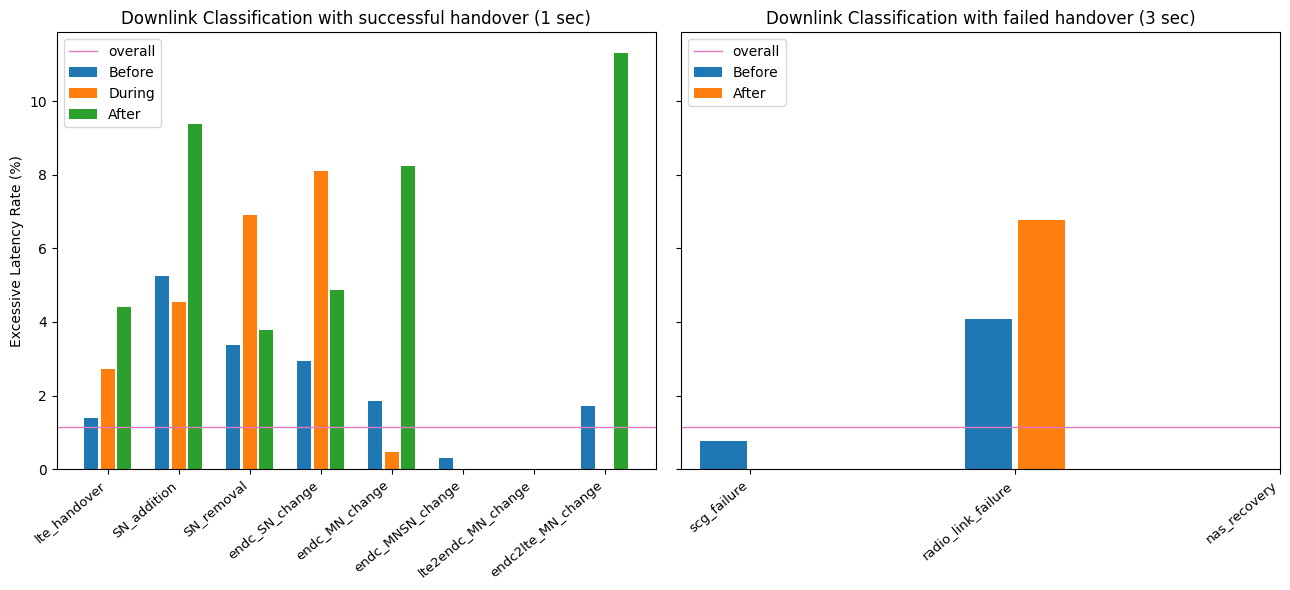

In [13]:
# /home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm03/#01/analysis/udp-excslat-classify-50p/dwnlnk_excslat_ho_classify_1.csv
# /home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm03/#01/analysis/udp-excslat-classify-50p/dwnlnk_excslat_ho_classify_3.csv

ho_types = "lte_handover,SN_addition,SN_removal,endc_SN_change,endc_MN_change,endc_MNSN_change,lte2endc_MN_change,endc2lte_MN_change".split(',')
rlf_types = "scg_failure,radio_link_failure,nas_recovery".split(',')

# print(dset.keys())
# before_event_ul_ho_loss  = [[[], []] for i in range(len(ho_types))]
# during_event_ul_ho_loss  = [[[], []] for i in range(len(ho_types))]
# after_event_ul_ho_loss   = [[[], []] for i in range(len(ho_types))]
# total_ul_ho_loss  = [[], []]
# before_event_ul_rlf_loss = [[[], []] for i in range(len(rlf_types))]
# after_event_ul_rlf_loss  = [[[], []] for i in range(len(rlf_types))]
# total_ul_rlf_loss = [[], []]

# before_event_ul_ho_excslat  = [[[], []] for i in range(len(ho_types))]
# during_event_ul_ho_excslat  = [[[], []] for i in range(len(ho_types))]
# after_event_ul_ho_excslat   = [[[], []] for i in range(len(ho_types))]
# total_ul_ho_excslat  = [[], []]
# before_event_ul_rlf_excslat = [[[], []] for i in range(len(rlf_types))]
# after_event_ul_rlf_excslat  = [[[], []] for i in range(len(rlf_types))]
# total_ul_rlf_excslat = [[], []]

# before_event_dl_ho_loss  = [[[], []] for i in range(len(ho_types))]
# during_event_dl_ho_loss  = [[[], []] for i in range(len(ho_types))]
# after_event_dl_ho_loss   = [[[], []] for i in range(len(ho_types))]
# total_dl_ho_loss  = [[], []]
# before_event_dl_rlf_loss = [[[], []] for i in range(len(rlf_types))]
# after_event_dl_rlf_loss  = [[[], []] for i in range(len(rlf_types))]
# total_dl_rlf_loss = [[], []]

before_event_dl_ho_excslat  = [[[], []] for i in range(len(ho_types))]
during_event_dl_ho_excslat  = [[[], []] for i in range(len(ho_types))]
after_event_dl_ho_excslat   = [[[], []] for i in range(len(ho_types))]
total_dl_ho_excslat  = [[], []]
before_event_dl_rlf_excslat = [[[], []] for i in range(len(rlf_types))]
after_event_dl_rlf_excslat  = [[[], []] for i in range(len(rlf_types))]
total_dl_rlf_excslat = [[], []]

for j, (key, item) in enumerate(dset.items()):
    for _round in item['rounds']:
        # df1 = pd.read_csv(os.path.join(item['root'], _round, 'analysis', 'udp-loss-classify-50p', 'uplnk_loss_ho_classify_1.csv'))
        # df2 = pd.read_csv(os.path.join(item['root'], _round, 'analysis', 'udp-loss-classify-50p', 'uplnk_loss_ho_classify_3.csv'))
        # df3 = pd.read_csv(os.path.join(item['root'], _round, 'analysis', 'udp-loss-classify-50p', 'dwnlnk_loss_ho_classify_1.csv'))
        # df4 = pd.read_csv(os.path.join(item['root'], _round, 'analysis', 'udp-loss-classify-50p', 'dwnlnk_loss_ho_classify_3.csv'))
        # df5 = pd.read_csv(os.path.join(item['root'], _round, 'analysis', 'udp-excslat-classify-50p', 'uplnk_excslat_ho_classify_1.csv'))
        # df6 = pd.read_csv(os.path.join(item['root'], _round, 'analysis', 'udp-excslat-classify-50p', 'uplnk_excslat_ho_classify_3.csv'))
        df7 = pd.read_csv(os.path.join(item['root'], _round, 'analysis', 'udp-excslat-classify-50p', 'dwnlnk_excslat_ho_classify_1.csv'))
        df8 = pd.read_csv(os.path.join(item['root'], _round, 'analysis', 'udp-excslat-classify-50p', 'dwnlnk_excslat_ho_classify_3.csv'))
        
        for i, ho_type in enumerate(ho_types):
            before_event_dl_ho_excslat[i][0].append(df7['packet_loss_num'].iloc[3*i])
            before_event_dl_ho_excslat[i][1].append(df7['total_packet_num'].iloc[3*i])
            during_event_dl_ho_excslat[i][0].append(df7['packet_loss_num'].iloc[3*i + 1])
            during_event_dl_ho_excslat[i][1].append(df7['total_packet_num'].iloc[3*i + 1])
            after_event_dl_ho_excslat[i][0].append(df7['packet_loss_num'].iloc[3*i + 2])
            after_event_dl_ho_excslat[i][1].append(df7['total_packet_num'].iloc[3*i + 2])
        total_dl_ho_excslat[0].append(df7['packet_loss_num'].iloc[37])
        total_dl_ho_excslat[1].append(df7['total_packet_num'].iloc[37])

        for i, ho_type in enumerate(rlf_types):
            before_event_dl_rlf_excslat[i][0].append(df8['packet_loss_num'].iloc[24 + 2*i])
            before_event_dl_rlf_excslat[i][1].append(df8['total_packet_num'].iloc[24 + 2*i])
            after_event_dl_rlf_excslat[i][0].append(df8['packet_loss_num'].iloc[24 + 2*i + 1])
            after_event_dl_rlf_excslat[i][1].append(df8['total_packet_num'].iloc[24 + 2*i + 1])
        total_dl_rlf_excslat[0].append(df8['packet_loss_num'].iloc[37])
        total_dl_rlf_excslat[1].append(df8['total_packet_num'].iloc[37])

for i in range(len(ho_types)):
    before_event_dl_ho_excslat[i] = round(sum(before_event_dl_ho_excslat[i][0]) / sum(before_event_dl_ho_excslat[i][1]) * 100, 3)
    during_event_dl_ho_excslat[i] = round(sum(during_event_dl_ho_excslat[i][0]) / sum(during_event_dl_ho_excslat[i][1]) * 100, 3)
    after_event_dl_ho_excslat[i]  = round(sum(after_event_dl_ho_excslat[i][0]) / sum(after_event_dl_ho_excslat[i][1]) * 100, 3)
total_dl_ho_excslat = round(sum(total_dl_ho_excslat[0]) / sum(total_dl_ho_excslat[1]) * 100, 3)

for i in range(len(rlf_types)):
    before_event_dl_rlf_excslat[i] = round(sum(before_event_dl_rlf_excslat[i][0]) / sum(before_event_dl_rlf_excslat[i][1]) * 100, 3)
    after_event_dl_rlf_excslat[i]  = round(sum(after_event_dl_rlf_excslat[i][0]) / sum(after_event_dl_rlf_excslat[i][1]) * 100, 3)
total_dl_rlf_excslat = round(sum(total_dl_rlf_excslat[0]) / sum(total_dl_rlf_excslat[1]) * 100, 3)

print(before_event_dl_ho_excslat)
print(during_event_dl_ho_excslat)
print(after_event_dl_ho_excslat)
print(total_dl_ho_excslat)

print(before_event_dl_rlf_excslat)
print(after_event_dl_rlf_excslat)
print(total_dl_rlf_excslat)

x = np.arange(len(ho_types))  # the label locations
width = 0.2  # the width of the bars
space = 0.7

fig, (ax, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize =(13, 6))
rects1 = ax.bar(x - space/3, before_event_dl_ho_excslat, width, label='Before')
rects2 = ax.bar(x          , during_event_dl_ho_excslat, width, label='During')
rects3 = ax.bar(x + space/3, after_event_dl_ho_excslat, width, label='After')
ax.axhline(total_dl_ho_excslat, c = 'tab:pink', linewidth=1, label='overall')

x2 = np.arange(len(rlf_types))  # the label locations
width = 0.18  # the width of the bars
space = 0.2
rects4 = ax2.bar(x2 - space/2, before_event_dl_rlf_excslat, width, label='Before')
rects5 = ax2.bar(x2 + space/2, after_event_dl_rlf_excslat, width, label='After')
ax2.axhline(total_dl_ho_excslat, c = 'tab:pink', linewidth=1, label='overall')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Excessive Latency Rate (%)')
ax.set_title('Downlink Classification with successful handover (1 sec)')
ax2.set_title('Downlink Classification with failed handover (3 sec)')
ax.legend()
ax2.legend()

ax.set_xticks(x, ho_types)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")
ax2.set_xticks(x2, rlf_types)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")
fig.tight_layout()

plt.show()

#### Handover Classification: Line Plot
##### Downlink Loss

[[0.623, 0.127, 0.19, 0.239, 0.257, 0.24, 0.227, 0.225, 0.203, 0.461, 0.426, 0.255, 0.197, 0.165, 0.145, 0.131, 0.12, 0.111, 0.105, 0.1], [7.113, 6.741, 7.122, 7.139, 6.989, 6.636, 6.394, 6.198, 5.925, 5.618, 5.34, 3.428, 2.691, 2.34, 2.131, 1.991, 1.895, 1.823, 1.762, 1.712], [1.141, 1.627, 1.255, 1.126, 1.621, 1.424, 1.258, 1.133, 1.033, 0.953, 0.887, 0.558, 0.427, 0.351, 0.306, 0.273, 0.25, 0.231, 0.215, 0.203], [0.0, 0.025, 0.081, 0.062, 0.064, 0.061, 0.069, 0.117, 0.129, 0.119, 0.115, 0.074, 0.055, 0.045, 0.039, 0.035, 0.033, 0.032, 0.031, 0.029], [0.512, 0.382, 0.393, 0.401, 0.452, 0.467, 0.475, 0.49, 0.449, 0.407, 0.382, 0.251, 0.195, 0.166, 0.149, 0.138, 0.15, 0.147, 0.155, 0.165], [106.475, 106.349, 106.695, 106.574, 106.49, 99.743, 93.394, 88.046, 83.696, 79.755, 76.169, 52.543, 40.104, 32.542, 27.314, 23.533, 20.671, 18.43, 16.628, 15.146], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.135, 0.1, 0.08, 0.068

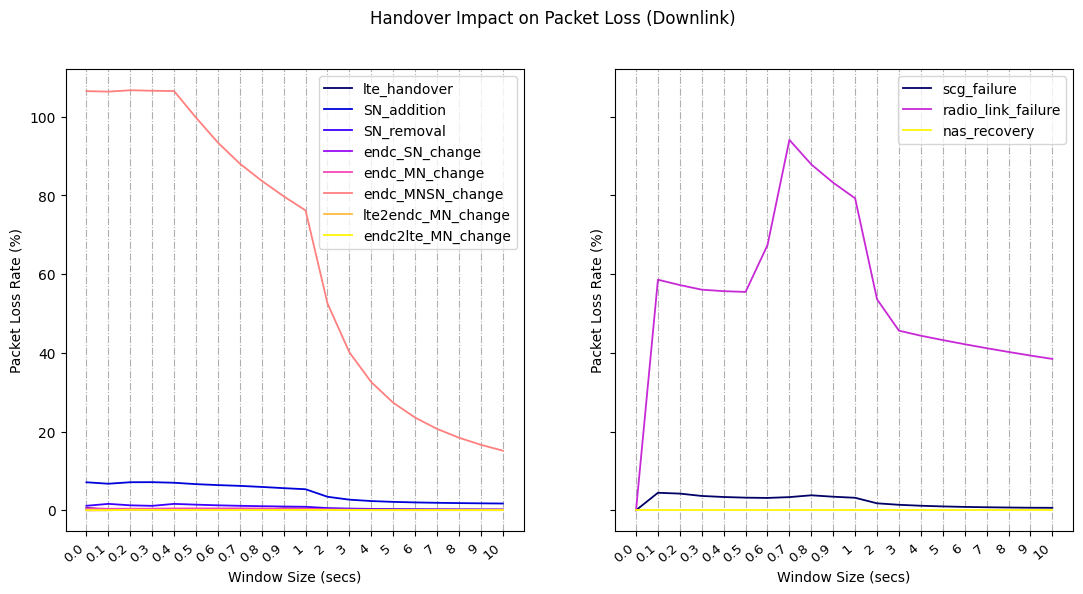

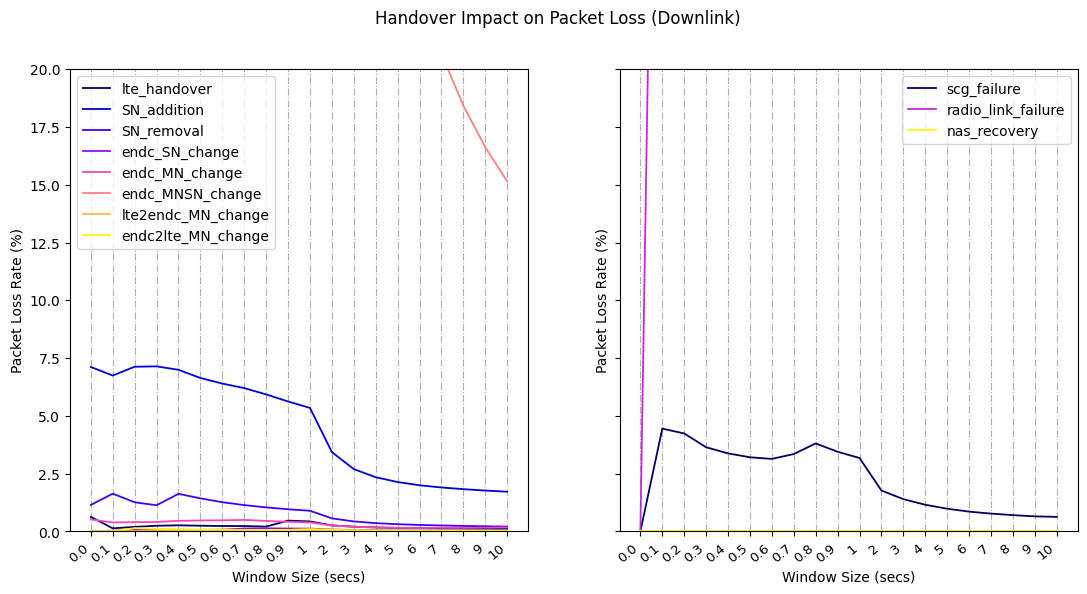

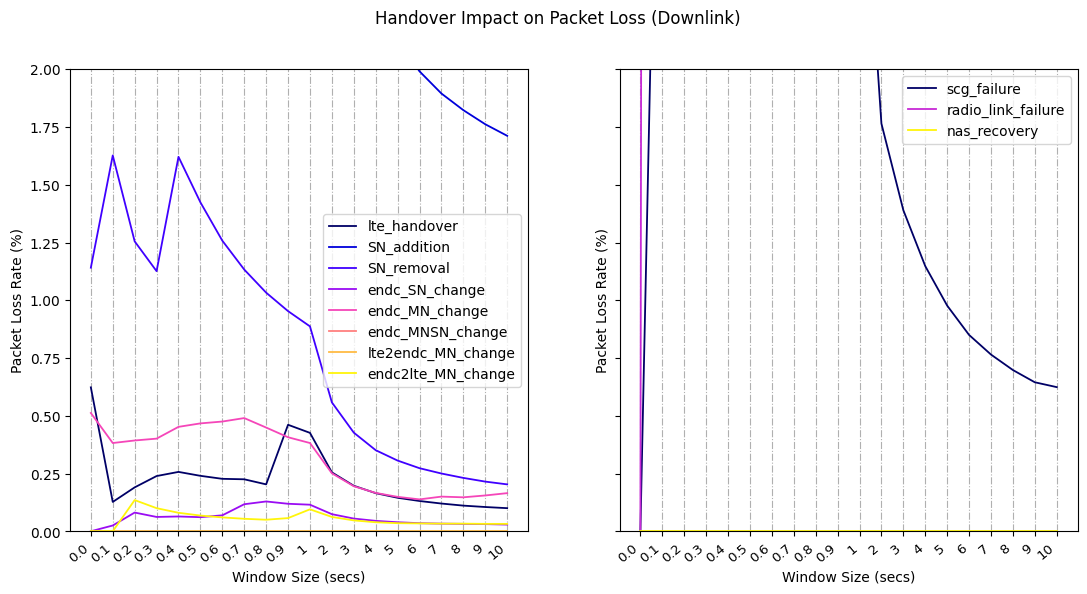

In [48]:
# df = pd.read_csv("/home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm03/#01/analysis/udp-loss-classify-50p/dwnlnk_loss_ho_classify_total.csv")
# df = pd.read_csv("/home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm04/#01/analysis/udp-loss-classify-50p/dwnlnk_loss_ho_classify_total.csv")
# df = pd.read_csv("/home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm05/#01/analysis/udp-loss-classify-50p/dwnlnk_loss_ho_classify_total.csv")
# df = pd.read_csv("/home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm06/#01/analysis/udp-loss-classify-50p/dwnlnk_loss_ho_classify_total.csv")
# df = pd.read_csv("/home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm07/#01/analysis/udp-loss-classify-50p/dwnlnk_loss_ho_classify_total.csv")
# df = pd.read_csv("/home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm08/#01/analysis/udp-loss-classify-50p/dwnlnk_loss_ho_classify_total.csv")

ho_types = "lte_handover,SN_addition,SN_removal,endc_SN_change,endc_MN_change,endc_MNSN_change,lte2endc_MN_change,endc2lte_MN_change".split(',')
rlf_types = "scg_failure,radio_link_failure,nas_recovery".split(',')

wsize = [s/10 for s in range(10)] + list(range(1, 11))
wsize_str = ['0{}'.format(s) for s in range(10)] + [str(s) for s in range(1, 11)]

yy = []
for i, ho_type in enumerate(ho_types + rlf_types):
    yy.append([])
    for k, (ws, tt) in enumerate(zip(wsize, wsize_str)):
        _packet_num = 0
        _loss_num = 0
        for j, (key, item) in enumerate(dset.items()):
            for _round in item['rounds']:
                df = pd.read_csv(os.path.join(item['root'], _round, 'analysis', 'udp-loss-classify-50p', 'dwnlnk_loss_ho_classify_{}.csv'.format(tt)))
                if i < 8:
                    _packet_num += int(df[df['type'] == 'before_{}'.format(ho_type)]['total_packet_num']) + int(df[df['type'] == 'during_{}'.format(ho_type)]['total_packet_num']) + int(df[df['type'] == 'after_{}'.format(ho_type)]['total_packet_num'])
                    _loss_num += int(df[df['type'] == 'before_{}'.format(ho_type)]['packet_loss_num']) + int(df[df['type'] == 'during_{}'.format(ho_type)]['packet_loss_num']) + int(df[df['type'] == 'after_{}'.format(ho_type)]['packet_loss_num'])
                else:
                    _packet_num += int(df[df['type'] == 'before_{}'.format(ho_type)]['total_packet_num']) + int(df[df['type'] == 'after_{}'.format(ho_type)]['total_packet_num'])
                    _loss_num += int(df[df['type'] == 'before_{}'.format(ho_type)]['packet_loss_num']) + int(df[df['type'] == 'after_{}'.format(ho_type)]['packet_loss_num'])
        yy[i].append(round(_loss_num / (_packet_num + 1e-9) * 100, 3))
print(yy)


### Plotting
labels = [str(s) for s in wsize]
x = np.arange(len(labels))

fig, (ax, ax2) = plt.subplots(1, 2, sharey=True, figsize =(13, 6))
fig.suptitle('Handover Impact on Packet Loss (Downlink)')

cmap = bpy_color_palette(8, 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
color_dict = {_type : color for color, _type in zip(color_list, ho_types)}

for i, ho_type in enumerate(ho_types):
    ax.plot(x, yy[i], color_list[i], linewidth=1.3, label=ho_type)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xticks(x, labels)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax.set_xlabel('Window Size (secs)')
ax.set_ylabel('Packet Loss Rate (%)')
# ax.set_title('Handover Impact on Packet Loss')
ax.grid(axis='x', linestyle='-.')
ax.legend()

cmap = bpy_color_palette(3, 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
color_dict = {_type : color for color, _type in zip(color_list, ho_types)}

for i, rlf_type in enumerate(rlf_types):
    ax2.plot(x, yy[i+8], color_list[i], linewidth=1.3, label=rlf_type)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_xticks(x, labels)
ax2.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax2.set_xlabel('Window Size (secs)')
ax2.set_ylabel('Packet Loss Rate (%)')
# ax2.set_title('Handover Impact on Packet Loss')
ax2.grid(axis='x', linestyle='-.')
ax2.legend()

plt.show()

### Plotting
labels = [str(s) for s in wsize]
x = np.arange(len(labels))

fig, (ax, ax2) = plt.subplots(1, 2, sharey=True, figsize =(13, 6))
fig.suptitle('Handover Impact on Packet Loss (Downlink)')

cmap = bpy_color_palette(8, 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
color_dict = {_type : color for color, _type in zip(color_list, ho_types)}

for i, ho_type in enumerate(ho_types):
    ax.plot(x, yy[i], color_list[i], linewidth=1.3, label=ho_type)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xticks(x, labels)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax.set_xlabel('Window Size (secs)')
ax.set_ylabel('Packet Loss Rate (%)')
# ax.set_title('Handover Impact on Packet Loss')
ax.grid(axis='x', linestyle='-.')
ax.legend()

cmap = bpy_color_palette(3, 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
color_dict = {_type : color for color, _type in zip(color_list, ho_types)}

for i, rlf_type in enumerate(rlf_types):
    ax2.plot(x, yy[i+8], color_list[i], linewidth=1.3, label=rlf_type)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_xticks(x, labels)
ax2.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax2.set_xlabel('Window Size (secs)')
ax2.set_ylabel('Packet Loss Rate (%)')
# ax2.set_title('Handover Impact on Packet Loss')
ax2.grid(axis='x', linestyle='-.')
ax2.legend()

ax.set_ylim(0, 20)

plt.show()

### Plotting
labels = [str(s) for s in wsize]
x = np.arange(len(labels))

fig, (ax, ax2) = plt.subplots(1, 2, sharey=True, figsize =(13, 6))
fig.suptitle('Handover Impact on Packet Loss (Downlink)')

cmap = bpy_color_palette(8, 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
color_dict = {_type : color for color, _type in zip(color_list, ho_types)}

for i, ho_type in enumerate(ho_types):
    ax.plot(x, yy[i], color_list[i], linewidth=1.3, label=ho_type)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xticks(x, labels)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax.set_xlabel('Window Size (secs)')
ax.set_ylabel('Packet Loss Rate (%)')
# ax.set_title('Handover Impact on Packet Loss')
ax.grid(axis='x', linestyle='-.')
ax.legend()

cmap = bpy_color_palette(3, 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
color_dict = {_type : color for color, _type in zip(color_list, ho_types)}

for i, rlf_type in enumerate(rlf_types):
    ax2.plot(x, yy[i+8], color_list[i], linewidth=1.3, label=rlf_type)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_xticks(x, labels)
ax2.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax2.set_xlabel('Window Size (secs)')
ax2.set_ylabel('Packet Loss Rate (%)')
# ax2.set_title('Handover Impact on Packet Loss')
ax2.grid(axis='x', linestyle='-.')
ax2.legend()

ax.set_ylim(0, 2)

plt.show()

##### Uplink Loss

[[1.38, 1.231, 1.24, 1.259, 1.342, 1.369, 1.378, 1.372, 1.37, 1.389, 1.41, 1.591, 1.519, 1.391, 1.246, 1.18, 1.144, 1.123, 1.114, 1.099], [4.35, 3.021, 3.352, 3.035, 2.559, 2.268, 2.47, 2.408, 2.401, 2.224, 2.138, 1.385, 1.085, 0.942, 0.859, 0.803, 0.765, 0.736, 0.713, 0.693], [0.152, 0.297, 0.255, 0.382, 0.388, 0.547, 0.55, 0.507, 0.48, 0.448, 0.595, 0.414, 0.323, 0.273, 0.237, 0.213, 0.197, 0.182, 0.17, 0.16], [0.0, 0.008, 0.043, 0.065, 0.062, 0.055, 0.07, 0.067, 0.06, 0.058, 0.068, 0.053, 0.043, 0.039, 0.034, 0.031, 0.029, 0.028, 0.027, 0.026], [0.682, 0.549, 0.596, 0.555, 0.536, 0.528, 0.531, 0.525, 0.493, 0.45, 0.413, 0.264, 0.214, 0.187, 0.171, 0.159, 0.174, 0.175, 0.183, 0.195], [0.0, 0.0, 0.0, 0.519, 5.752, 5.398, 5.581, 8.628, 8.202, 7.815, 7.464, 5.149, 3.93, 3.178, 2.667, 2.298, 2.018, 1.8, 1.624, 1.479], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.057, 0.034, 0.05, 0.04, 0.034, 0.03, 0.027, 0.025, 0.023, 0.02

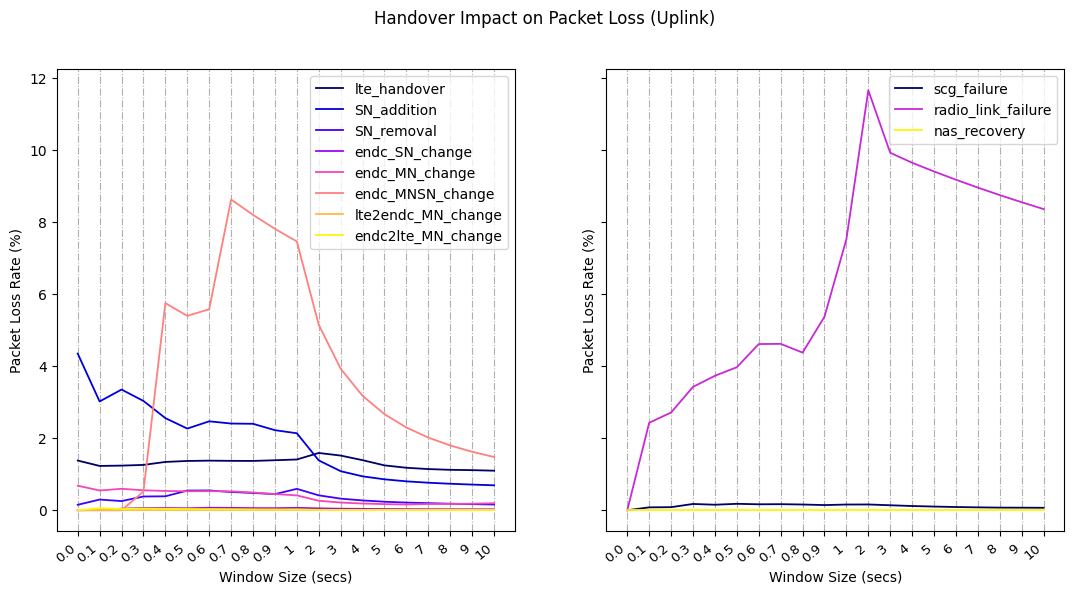

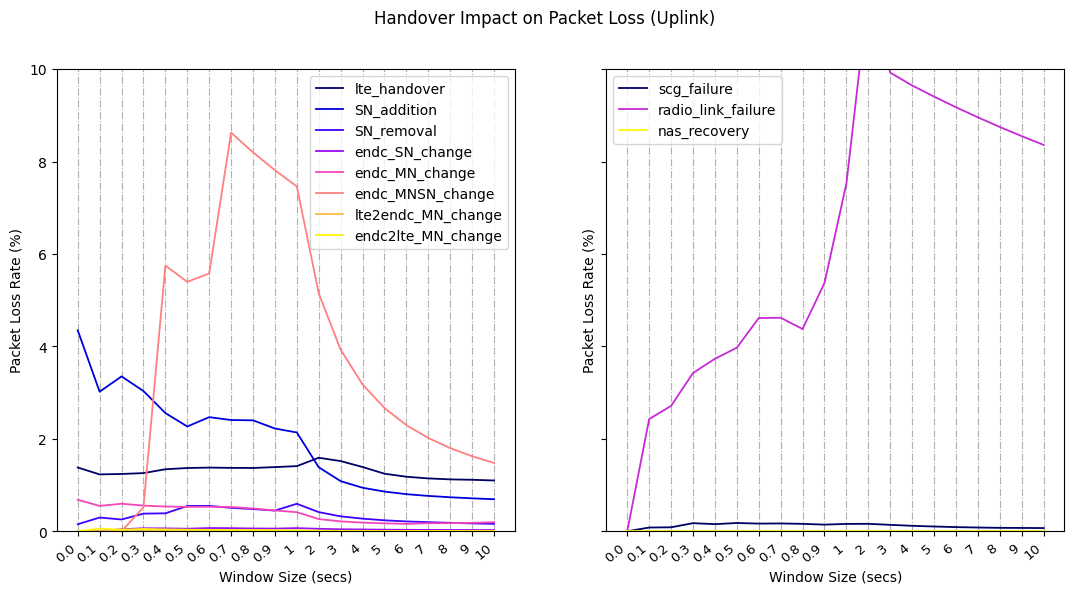

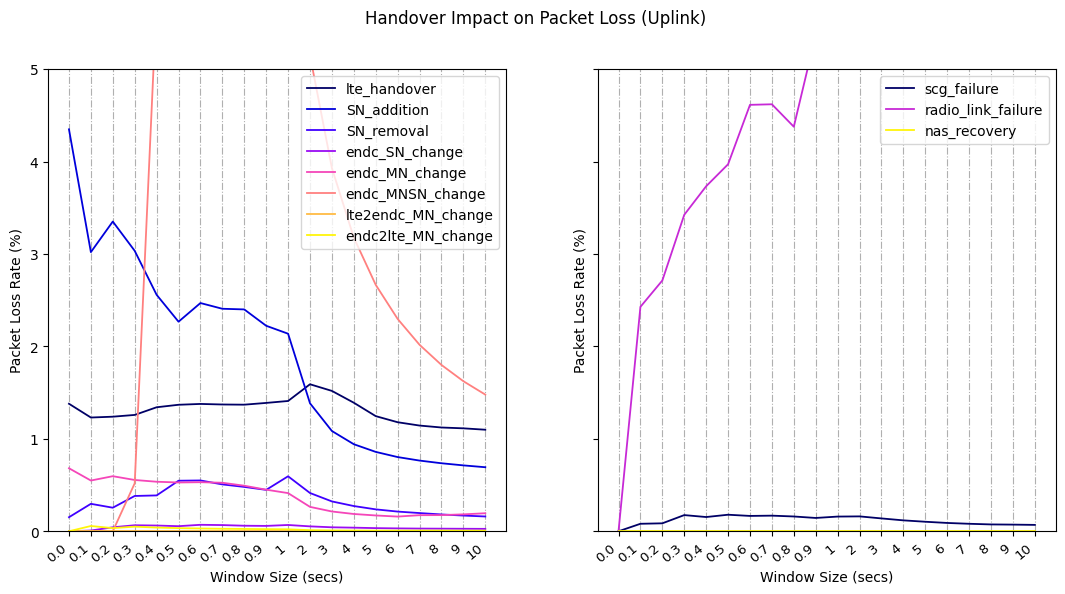

In [49]:
# df = pd.read_csv("/home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm03/#01/analysis/udp-loss-classify-50p/dwnlnk_loss_ho_classify_total.csv")
# df = pd.read_csv("/home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm04/#01/analysis/udp-loss-classify-50p/dwnlnk_loss_ho_classify_total.csv")
# df = pd.read_csv("/home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm05/#01/analysis/udp-loss-classify-50p/dwnlnk_loss_ho_classify_total.csv")
# df = pd.read_csv("/home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm06/#01/analysis/udp-loss-classify-50p/dwnlnk_loss_ho_classify_total.csv")
# df = pd.read_csv("/home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm07/#01/analysis/udp-loss-classify-50p/dwnlnk_loss_ho_classify_total.csv")
# df = pd.read_csv("/home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm08/#01/analysis/udp-loss-classify-50p/dwnlnk_loss_ho_classify_total.csv")

ho_types = "lte_handover,SN_addition,SN_removal,endc_SN_change,endc_MN_change,endc_MNSN_change,lte2endc_MN_change,endc2lte_MN_change".split(',')
rlf_types = "scg_failure,radio_link_failure,nas_recovery".split(',')

wsize = [s/10 for s in range(10)] + list(range(1, 11))
wsize_str = ['0{}'.format(s) for s in range(10)] + [str(s) for s in range(1, 11)]

yy = []
for i, ho_type in enumerate(ho_types + rlf_types):
    yy.append([])
    for k, (ws, tt) in enumerate(zip(wsize, wsize_str)):
        _packet_num = 0
        _loss_num = 0
        for j, (key, item) in enumerate(dset.items()):
            for _round in item['rounds']:
                df = pd.read_csv(os.path.join(item['root'], _round, 'analysis', 'udp-loss-classify-50p', 'uplnk_loss_ho_classify_{}.csv'.format(tt)))
                if i < 8:
                    _packet_num += int(df[df['type'] == 'before_{}'.format(ho_type)]['total_packet_num']) + int(df[df['type'] == 'during_{}'.format(ho_type)]['total_packet_num']) + int(df[df['type'] == 'after_{}'.format(ho_type)]['total_packet_num'])
                    _loss_num += int(df[df['type'] == 'before_{}'.format(ho_type)]['packet_loss_num']) + int(df[df['type'] == 'during_{}'.format(ho_type)]['packet_loss_num']) + int(df[df['type'] == 'after_{}'.format(ho_type)]['packet_loss_num'])
                else:
                    _packet_num += int(df[df['type'] == 'before_{}'.format(ho_type)]['total_packet_num']) + int(df[df['type'] == 'after_{}'.format(ho_type)]['total_packet_num'])
                    _loss_num += int(df[df['type'] == 'before_{}'.format(ho_type)]['packet_loss_num']) + int(df[df['type'] == 'after_{}'.format(ho_type)]['packet_loss_num'])
        yy[i].append(round(_loss_num / (_packet_num + 1e-9) * 100, 3))
print(yy)


### Plotting
labels = [str(s) for s in wsize]
x = np.arange(len(labels))

fig, (ax, ax2) = plt.subplots(1, 2, sharey=True, figsize =(13, 6))
fig.suptitle('Handover Impact on Packet Loss (Uplink)')

cmap = bpy_color_palette(8, 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
color_dict = {_type : color for color, _type in zip(color_list, ho_types)}

for i, ho_type in enumerate(ho_types):
    ax.plot(x, yy[i], color_list[i], linewidth=1.3, label=ho_type)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xticks(x, labels)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax.set_xlabel('Window Size (secs)')
ax.set_ylabel('Packet Loss Rate (%)')
# ax.set_title('Handover Impact on Packet Loss')
ax.grid(axis='x', linestyle='-.')
ax.legend()

cmap = bpy_color_palette(3, 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
color_dict = {_type : color for color, _type in zip(color_list, ho_types)}

for i, rlf_type in enumerate(rlf_types):
    ax2.plot(x, yy[i+8], color_list[i], linewidth=1.3, label=rlf_type)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_xticks(x, labels)
ax2.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax2.set_xlabel('Window Size (secs)')
ax2.set_ylabel('Packet Loss Rate (%)')
# ax2.set_title('Handover Impact on Packet Loss')
ax2.grid(axis='x', linestyle='-.')
ax2.legend()

plt.show()

### Plotting
labels = [str(s) for s in wsize]
x = np.arange(len(labels))

fig, (ax, ax2) = plt.subplots(1, 2, sharey=True, figsize =(13, 6))
fig.suptitle('Handover Impact on Packet Loss (Uplink)')

cmap = bpy_color_palette(8, 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
color_dict = {_type : color for color, _type in zip(color_list, ho_types)}

for i, ho_type in enumerate(ho_types):
    ax.plot(x, yy[i], color_list[i], linewidth=1.3, label=ho_type)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xticks(x, labels)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax.set_xlabel('Window Size (secs)')
ax.set_ylabel('Packet Loss Rate (%)')
# ax.set_title('Handover Impact on Packet Loss')
ax.grid(axis='x', linestyle='-.')
ax.legend()

cmap = bpy_color_palette(3, 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
color_dict = {_type : color for color, _type in zip(color_list, ho_types)}

for i, rlf_type in enumerate(rlf_types):
    ax2.plot(x, yy[i+8], color_list[i], linewidth=1.3, label=rlf_type)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_xticks(x, labels)
ax2.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax2.set_xlabel('Window Size (secs)')
ax2.set_ylabel('Packet Loss Rate (%)')
# ax2.set_title('Handover Impact on Packet Loss')
ax2.grid(axis='x', linestyle='-.')
ax2.legend()

ax.set_ylim(0, 10)

plt.show()

### Plotting
labels = [str(s) for s in wsize]
x = np.arange(len(labels))

fig, (ax, ax2) = plt.subplots(1, 2, sharey=True, figsize =(13, 6))
fig.suptitle('Handover Impact on Packet Loss (Uplink)')

cmap = bpy_color_palette(8, 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
color_dict = {_type : color for color, _type in zip(color_list, ho_types)}

for i, ho_type in enumerate(ho_types):
    ax.plot(x, yy[i], color_list[i], linewidth=1.3, label=ho_type)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xticks(x, labels)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax.set_xlabel('Window Size (secs)')
ax.set_ylabel('Packet Loss Rate (%)')
# ax.set_title('Handover Impact on Packet Loss')
ax.grid(axis='x', linestyle='-.')
ax.legend()

cmap = bpy_color_palette(3, 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
color_dict = {_type : color for color, _type in zip(color_list, ho_types)}

for i, rlf_type in enumerate(rlf_types):
    ax2.plot(x, yy[i+8], color_list[i], linewidth=1.3, label=rlf_type)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_xticks(x, labels)
ax2.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax2.set_xlabel('Window Size (secs)')
ax2.set_ylabel('Packet Loss Rate (%)')
# ax2.set_title('Handover Impact on Packet Loss')
ax2.grid(axis='x', linestyle='-.')
ax2.legend()

ax.set_ylim(0, 5)

plt.show()

##### Downlink Excessive Latency

[[2.715, 2.667, 2.085, 2.096, 2.198, 2.48, 2.533, 2.581, 2.892, 2.808, 2.84, 2.077, 1.693, 1.446, 1.3, 1.188, 1.097, 1.028, 0.988, 0.946], [4.543, 4.325, 3.804, 4.091, 4.064, 4.628, 6.217, 7.73, 8.903, 9.144, 8.574, 7.85, 6.163, 5.36, 4.881, 4.559, 4.34, 4.176, 4.036, 3.921], [6.92, 5.014, 4.261, 4.126, 3.58, 4.455, 4.686, 4.221, 3.957, 3.79, 3.62, 3.009, 2.299, 1.894, 1.639, 1.466, 1.339, 1.28, 1.195, 1.13], [8.114, 3.562, 3.558, 3.252, 3.226, 3.408, 3.795, 4.275, 4.246, 4.152, 3.904, 2.9, 2.13, 1.736, 1.516, 1.381, 1.301, 1.24, 1.19, 1.145], [0.455, 2.006, 2.147, 1.894, 1.931, 2.634, 4.279, 4.986, 5.293, 5.142, 4.991, 4.416, 3.423, 2.92, 2.62, 2.431, 2.304, 2.2, 2.114, 2.042], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.114, 0.104, 0.099, 0.094, 0.09, 0.062, 0.047, 0.038, 0.032, 0.028, 0.024, 0.022, 0.02, 0.018], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.673, 0.796, 3.098, 7.454, 6.6, 5.937, 5.422, 6.438, 6.586, 4.074, 3.0

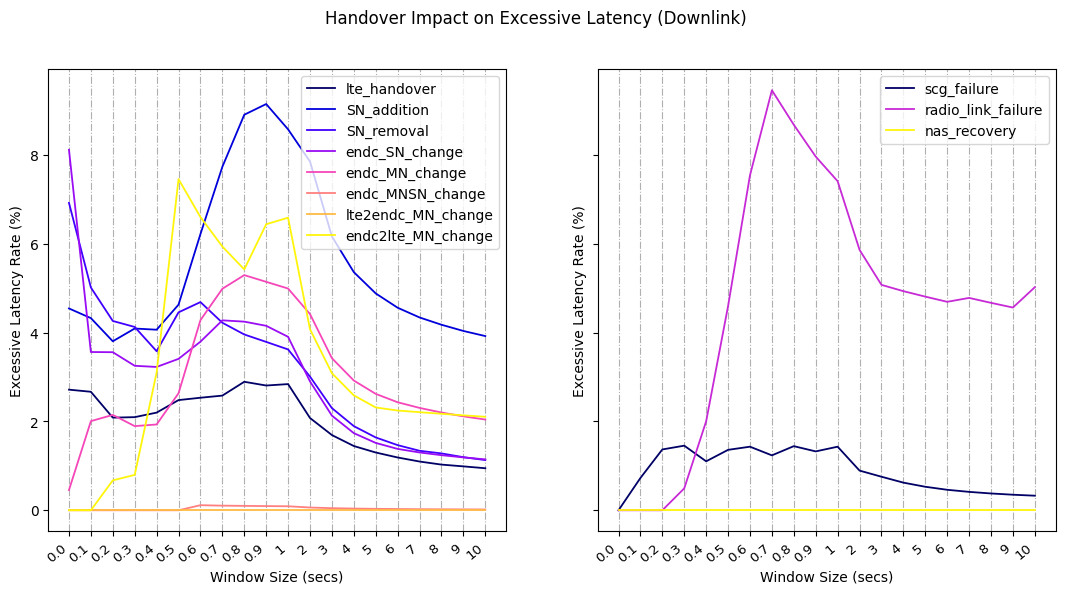

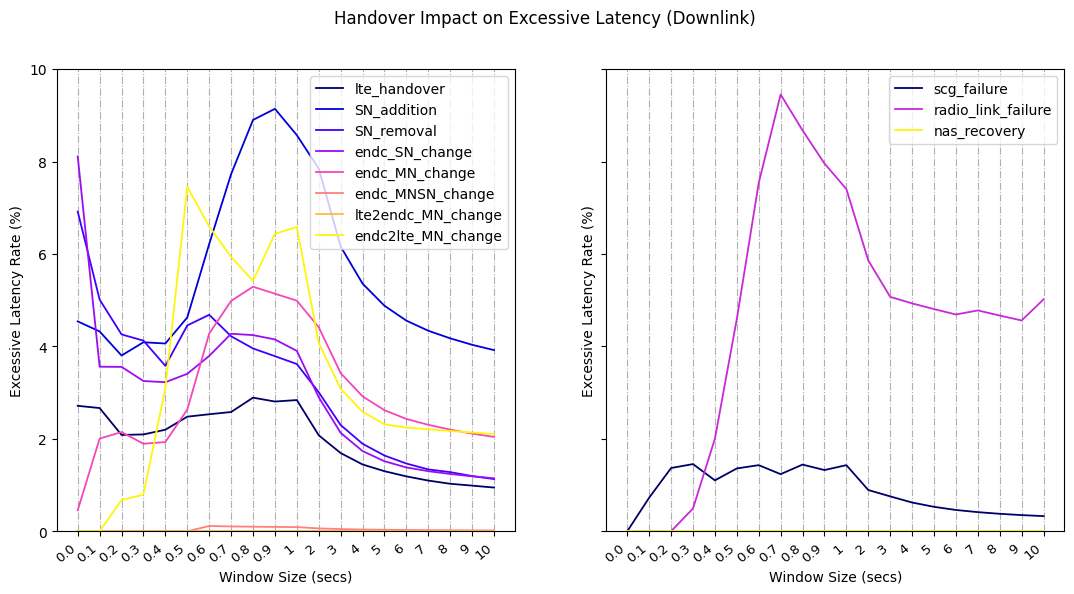

In [50]:
# df = pd.read_csv("/home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm03/#01/analysis/udp-loss-classify-50p/dwnlnk_loss_ho_classify_total.csv")
# df = pd.read_csv("/home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm04/#01/analysis/udp-loss-classify-50p/dwnlnk_loss_ho_classify_total.csv")
# df = pd.read_csv("/home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm05/#01/analysis/udp-loss-classify-50p/dwnlnk_loss_ho_classify_total.csv")
# df = pd.read_csv("/home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm06/#01/analysis/udp-loss-classify-50p/dwnlnk_loss_ho_classify_total.csv")
# df = pd.read_csv("/home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm07/#01/analysis/udp-loss-classify-50p/dwnlnk_loss_ho_classify_total.csv")
# df = pd.read_csv("/home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm08/#01/analysis/udp-loss-classify-50p/dwnlnk_loss_ho_classify_total.csv")

ho_types = "lte_handover,SN_addition,SN_removal,endc_SN_change,endc_MN_change,endc_MNSN_change,lte2endc_MN_change,endc2lte_MN_change".split(',')
rlf_types = "scg_failure,radio_link_failure,nas_recovery".split(',')

wsize = [s/10 for s in range(10)] + list(range(1, 11))
wsize_str = ['0{}'.format(s) for s in range(10)] + [str(s) for s in range(1, 11)]

yy = []
for i, ho_type in enumerate(ho_types + rlf_types):
    yy.append([])
    for k, (ws, tt) in enumerate(zip(wsize, wsize_str)):
        _packet_num = 0
        _loss_num = 0
        for j, (key, item) in enumerate(dset.items()):
            for _round in item['rounds']:
                df = pd.read_csv(os.path.join(item['root'], _round, 'analysis', 'udp-excslat-classify-50p', 'dwnlnk_excslat_ho_classify_{}.csv'.format(tt)))
                if i < 8:
                    _packet_num += int(df[df['type'] == 'before_{}'.format(ho_type)]['total_packet_num']) + int(df[df['type'] == 'during_{}'.format(ho_type)]['total_packet_num']) + int(df[df['type'] == 'after_{}'.format(ho_type)]['total_packet_num'])
                    _loss_num += int(df[df['type'] == 'before_{}'.format(ho_type)]['packet_loss_num']) + int(df[df['type'] == 'during_{}'.format(ho_type)]['packet_loss_num']) + int(df[df['type'] == 'after_{}'.format(ho_type)]['packet_loss_num'])
                else:
                    _packet_num += int(df[df['type'] == 'before_{}'.format(ho_type)]['total_packet_num']) + int(df[df['type'] == 'after_{}'.format(ho_type)]['total_packet_num'])
                    _loss_num += int(df[df['type'] == 'before_{}'.format(ho_type)]['packet_loss_num']) + int(df[df['type'] == 'after_{}'.format(ho_type)]['packet_loss_num'])
        yy[i].append(round(_loss_num / (_packet_num + 1e-9) * 100, 3))
print(yy)


### Plotting
labels = [str(s) for s in wsize]
x = np.arange(len(labels))

fig, (ax, ax2) = plt.subplots(1, 2, sharey=True, figsize =(13, 6))
fig.suptitle('Handover Impact on Excessive Latency (Downlink)')

cmap = bpy_color_palette(8, 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
color_dict = {_type : color for color, _type in zip(color_list, ho_types)}

for i, ho_type in enumerate(ho_types):
    ax.plot(x, yy[i], color_list[i], linewidth=1.3, label=ho_type)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xticks(x, labels)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax.set_xlabel('Window Size (secs)')
ax.set_ylabel('Excessive Latency Rate (%)')
# ax.set_title('Handover Impact on Packet Loss')
ax.grid(axis='x', linestyle='-.')
ax.legend()

cmap = bpy_color_palette(3, 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
color_dict = {_type : color for color, _type in zip(color_list, ho_types)}

for i, rlf_type in enumerate(rlf_types):
    ax2.plot(x, yy[i+8], color_list[i], linewidth=1.3, label=rlf_type)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_xticks(x, labels)
ax2.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax2.set_xlabel('Window Size (secs)')
ax2.set_ylabel('Excessive Latency Rate (%)')
# ax2.set_title('Handover Impact on Packet Loss')
ax2.grid(axis='x', linestyle='-.')
ax2.legend()

plt.show()

### Plotting
labels = [str(s) for s in wsize]
x = np.arange(len(labels))

fig, (ax, ax2) = plt.subplots(1, 2, sharey=True, figsize =(13, 6))
fig.suptitle('Handover Impact on Excessive Latency (Downlink)')

cmap = bpy_color_palette(8, 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
color_dict = {_type : color for color, _type in zip(color_list, ho_types)}

for i, ho_type in enumerate(ho_types):
    ax.plot(x, yy[i], color_list[i], linewidth=1.3, label=ho_type)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xticks(x, labels)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax.set_xlabel('Window Size (secs)')
ax.set_ylabel('Excessive Latency Rate (%)')
# ax.set_title('Handover Impact on Packet Loss')
ax.grid(axis='x', linestyle='-.')
ax.legend()

cmap = bpy_color_palette(3, 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
color_dict = {_type : color for color, _type in zip(color_list, ho_types)}

for i, rlf_type in enumerate(rlf_types):
    ax2.plot(x, yy[i+8], color_list[i], linewidth=1.3, label=rlf_type)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_xticks(x, labels)
ax2.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax2.set_xlabel('Window Size (secs)')
ax2.set_ylabel('Excessive Latency Rate (%)')
# ax2.set_title('Handover Impact on Packet Loss')
ax2.grid(axis='x', linestyle='-.')
ax2.legend()

ax.set_ylim(0, 10)

plt.show()

# ### Plotting
# labels = [str(s) for s in wsize]
# x = np.arange(len(labels))

# fig, (ax, ax2) = plt.subplots(1, 2, sharey=True, figsize =(13, 6))
# fig.suptitle('Handover Impact on Excessive Latency (Downlink)')

# cmap = bpy_color_palette(8, 0.2)
# color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
# color_dict = {_type : color for color, _type in zip(color_list, ho_types)}

# for i, ho_type in enumerate(ho_types):
#     ax.plot(x, yy[i], color_list[i], linewidth=1.3, label=ho_type)

# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_xticks(x, labels)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

# ax.set_xlabel('Window Size (secs)')
# ax.set_ylabel('Excessive Latency Rate (%)')
# # ax.set_title('Handover Impact on Packet Loss')
# ax.grid(axis='x', linestyle='-.')
# ax.legend()

# cmap = bpy_color_palette(3, 0.2)
# color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
# color_dict = {_type : color for color, _type in zip(color_list, ho_types)}

# for i, rlf_type in enumerate(rlf_types):
#     ax2.plot(x, yy[i+8], color_list[i], linewidth=1.3, label=rlf_type)

# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax2.set_xticks(x, labels)
# ax2.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

# ax2.set_xlabel('Window Size (secs)')
# ax2.set_ylabel('Excessive Latency Rate (%)')
# # ax2.set_title('Handover Impact on Packet Loss')
# ax2.grid(axis='x', linestyle='-.')
# ax2.legend()

# ax.set_ylim(0, 2)

# plt.show()

##### Uplink Excessive Latency

[[14.286, 12.472, 12.471, 12.609, 12.626, 12.672, 12.579, 12.486, 12.299, 12.05, 11.829, 9.694, 8.337, 7.331, 6.655, 6.101, 5.669, 5.425, 5.192, 4.977], [18.474, 20.855, 18.324, 18.323, 19.122, 19.44, 19.412, 19.634, 18.93, 19.063, 18.834, 13.946, 11.111, 9.753, 9.031, 8.444, 8.044, 7.744, 7.487, 7.278], [32.928, 33.055, 34.745, 35.459, 35.782, 35.927, 36.049, 35.98, 36.081, 35.806, 35.241, 31.071, 27.678, 25.369, 23.929, 22.811, 21.887, 21.034, 20.248, 19.575], [9.257, 8.855, 9.078, 9.16, 10.005, 10.589, 10.795, 10.882, 10.841, 10.673, 10.539, 9.642, 8.224, 7.298, 6.485, 6.004, 5.711, 5.486, 5.264, 5.065], [10.997, 10.982, 11.321, 12.371, 13.958, 14.763, 14.597, 14.475, 14.22, 14.081, 13.878, 12.217, 11.052, 10.234, 9.703, 9.374, 9.361, 9.393, 9.387, 9.285], [69.424, 64.286, 99.791, 95.675, 94.1, 94.473, 94.305, 91.268, 91.7, 91.149, 87.05, 60.05, 45.833, 37.06, 31.105, 26.8, 23.541, 20.989, 18.936, 17.249], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

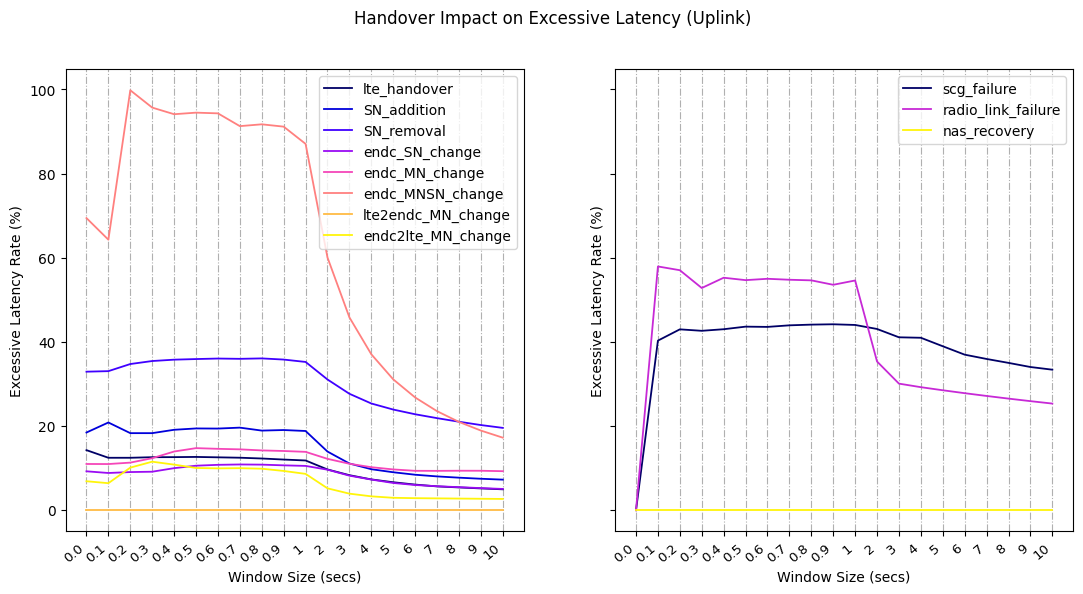

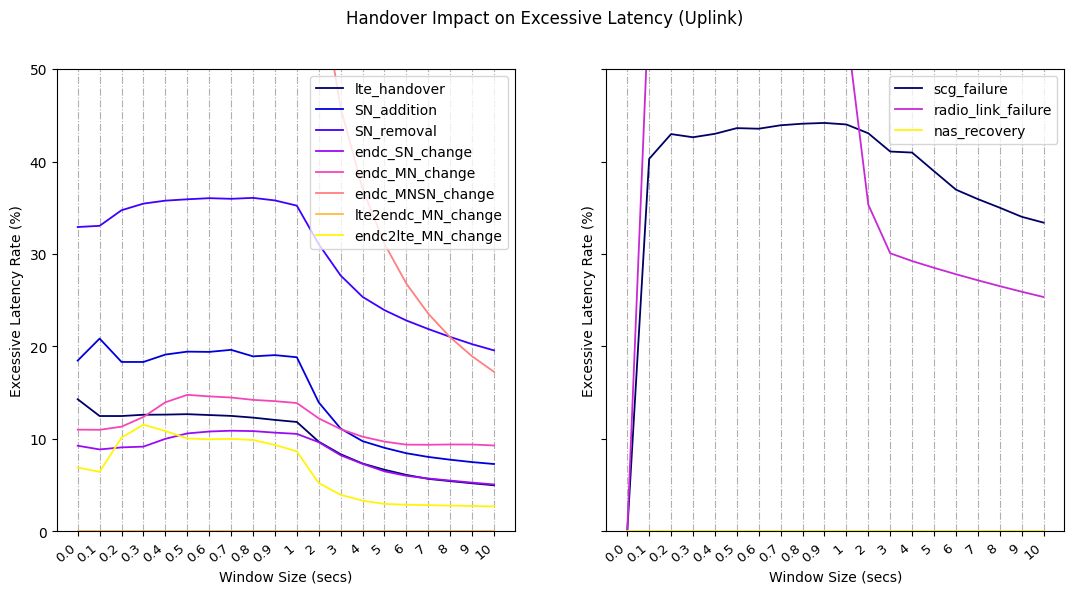

In [51]:
# df = pd.read_csv("/home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm03/#01/analysis/udp-loss-classify-50p/dwnlnk_loss_ho_classify_total.csv")
# df = pd.read_csv("/home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm04/#01/analysis/udp-loss-classify-50p/dwnlnk_loss_ho_classify_total.csv")
# df = pd.read_csv("/home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm05/#01/analysis/udp-loss-classify-50p/dwnlnk_loss_ho_classify_total.csv")
# df = pd.read_csv("/home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm06/#01/analysis/udp-loss-classify-50p/dwnlnk_loss_ho_classify_total.csv")
# df = pd.read_csv("/home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm07/#01/analysis/udp-loss-classify-50p/dwnlnk_loss_ho_classify_total.csv")
# df = pd.read_csv("/home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm08/#01/analysis/udp-loss-classify-50p/dwnlnk_loss_ho_classify_total.csv")

ho_types = "lte_handover,SN_addition,SN_removal,endc_SN_change,endc_MN_change,endc_MNSN_change,lte2endc_MN_change,endc2lte_MN_change".split(',')
rlf_types = "scg_failure,radio_link_failure,nas_recovery".split(',')

wsize = [s/10 for s in range(10)] + list(range(1, 11))
wsize_str = ['0{}'.format(s) for s in range(10)] + [str(s) for s in range(1, 11)]

yy = []
for i, ho_type in enumerate(ho_types + rlf_types):
    yy.append([])
    for k, (ws, tt) in enumerate(zip(wsize, wsize_str)):
        _packet_num = 0
        _loss_num = 0
        for j, (key, item) in enumerate(dset.items()):
            for _round in item['rounds']:
                df = pd.read_csv(os.path.join(item['root'], _round, 'analysis', 'udp-excslat-classify-50p', 'uplnk_excslat_ho_classify_{}.csv'.format(tt)))
                if i < 8:
                    _packet_num += int(df[df['type'] == 'before_{}'.format(ho_type)]['total_packet_num']) + int(df[df['type'] == 'during_{}'.format(ho_type)]['total_packet_num']) + int(df[df['type'] == 'after_{}'.format(ho_type)]['total_packet_num'])
                    _loss_num += int(df[df['type'] == 'before_{}'.format(ho_type)]['packet_loss_num']) + int(df[df['type'] == 'during_{}'.format(ho_type)]['packet_loss_num']) + int(df[df['type'] == 'after_{}'.format(ho_type)]['packet_loss_num'])
                else:
                    _packet_num += int(df[df['type'] == 'before_{}'.format(ho_type)]['total_packet_num']) + int(df[df['type'] == 'after_{}'.format(ho_type)]['total_packet_num'])
                    _loss_num += int(df[df['type'] == 'before_{}'.format(ho_type)]['packet_loss_num']) + int(df[df['type'] == 'after_{}'.format(ho_type)]['packet_loss_num'])
        yy[i].append(round(_loss_num / (_packet_num + 1e-9) * 100, 3))
print(yy)


### Plotting
labels = [str(s) for s in wsize]
x = np.arange(len(labels))

fig, (ax, ax2) = plt.subplots(1, 2, sharey=True, figsize =(13, 6))
fig.suptitle('Handover Impact on Excessive Latency (Uplink)')

cmap = bpy_color_palette(8, 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
color_dict = {_type : color for color, _type in zip(color_list, ho_types)}

for i, ho_type in enumerate(ho_types):
    ax.plot(x, yy[i], color_list[i], linewidth=1.3, label=ho_type)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xticks(x, labels)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax.set_xlabel('Window Size (secs)')
ax.set_ylabel('Excessive Latency Rate (%)')
# ax.set_title('Handover Impact on Packet Loss')
ax.grid(axis='x', linestyle='-.')
ax.legend()

cmap = bpy_color_palette(3, 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
color_dict = {_type : color for color, _type in zip(color_list, ho_types)}

for i, rlf_type in enumerate(rlf_types):
    ax2.plot(x, yy[i+8], color_list[i], linewidth=1.3, label=rlf_type)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_xticks(x, labels)
ax2.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax2.set_xlabel('Window Size (secs)')
ax2.set_ylabel('Excessive Latency Rate (%)')
# ax2.set_title('Handover Impact on Packet Loss')
ax2.grid(axis='x', linestyle='-.')
ax2.legend()

plt.show()

### Plotting
labels = [str(s) for s in wsize]
x = np.arange(len(labels))

fig, (ax, ax2) = plt.subplots(1, 2, sharey=True, figsize =(13, 6))
fig.suptitle('Handover Impact on Excessive Latency (Uplink)')

cmap = bpy_color_palette(8, 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
color_dict = {_type : color for color, _type in zip(color_list, ho_types)}

for i, ho_type in enumerate(ho_types):
    ax.plot(x, yy[i], color_list[i], linewidth=1.3, label=ho_type)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xticks(x, labels)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax.set_xlabel('Window Size (secs)')
ax.set_ylabel('Excessive Latency Rate (%)')
# ax.set_title('Handover Impact on Packet Loss')
ax.grid(axis='x', linestyle='-.')
ax.legend()

cmap = bpy_color_palette(3, 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
color_dict = {_type : color for color, _type in zip(color_list, ho_types)}

for i, rlf_type in enumerate(rlf_types):
    ax2.plot(x, yy[i+8], color_list[i], linewidth=1.3, label=rlf_type)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_xticks(x, labels)
ax2.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax2.set_xlabel('Window Size (secs)')
ax2.set_ylabel('Excessive Latency Rate (%)')
# ax2.set_title('Handover Impact on Packet Loss')
ax2.grid(axis='x', linestyle='-.')
ax2.legend()

ax.set_ylim(0, 50)

plt.show()

# ### Plotting
# labels = [str(s) for s in wsize]
# x = np.arange(len(labels))

# fig, (ax, ax2) = plt.subplots(1, 2, sharey=True, figsize =(13, 6))
# fig.suptitle('Handover Impact on Excessive Latency (Uplink)')

# cmap = bpy_color_palette(8, 0.2)
# color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
# color_dict = {_type : color for color, _type in zip(color_list, ho_types)}

# for i, ho_type in enumerate(ho_types):
#     ax.plot(x, yy[i], color_list[i], linewidth=1.3, label=ho_type)

# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_xticks(x, labels)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

# ax.set_xlabel('Window Size (secs)')
# ax.set_ylabel('Excessive Latency Rate (%)')
# # ax.set_title('Handover Impact on Packet Loss')
# ax.grid(axis='x', linestyle='-.')
# ax.legend()

# cmap = bpy_color_palette(3, 0.2)
# color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
# color_dict = {_type : color for color, _type in zip(color_list, ho_types)}

# for i, rlf_type in enumerate(rlf_types):
#     ax2.plot(x, yy[i+8], color_list[i], linewidth=1.3, label=rlf_type)

# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax2.set_xticks(x, labels)
# ax2.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

# ax2.set_xlabel('Window Size (secs)')
# ax2.set_ylabel('Excessive Latency Rate (%)')
# # ax2.set_title('Handover Impact on Packet Loss')
# ax2.grid(axis='x', linestyle='-.')
# ax2.legend()

# ax.set_ylim(0, 2)

# plt.show()

#### Handover Classify: During After
##### Downlink Loss

[[0.623, 0.136, 0.166, 0.267, 0.313, 0.319, 0.32, 0.336, 0.306, 0.287, 0.275, 0.178, 0.138, 0.116, 0.103, 0.093, 0.085, 0.079, 0.075, 0.071], [7.113, 6.109, 5.301, 4.581, 4.434, 4.397, 4.393, 4.381, 4.228, 4.008, 3.803, 2.285, 1.751, 1.506, 1.362, 1.267, 1.202, 1.154, 1.113, 1.08], [1.141, 1.89, 1.435, 1.38, 1.335, 1.252, 1.138, 1.046, 0.967, 0.902, 0.848, 0.558, 0.428, 0.351, 0.303, 0.267, 0.24, 0.219, 0.2, 0.186], [0.0, 0.031, 0.125, 0.094, 0.106, 0.1, 0.12, 0.223, 0.249, 0.228, 0.223, 0.149, 0.111, 0.09, 0.079, 0.073, 0.069, 0.066, 0.063, 0.061], [0.512, 0.4, 0.422, 0.433, 0.522, 0.54, 0.532, 0.554, 0.509, 0.463, 0.442, 0.274, 0.213, 0.181, 0.162, 0.149, 0.178, 0.177, 0.196, 0.219], [106.475, 106.402, 106.614, 106.542, 106.485, 96.402, 88.062, 81.051, 75.074, 69.918, 65.424, 39.828, 28.628, 22.476, 18.431, 15.619, 13.552, 11.968, 10.716, 9.701], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.261, 0.195, 0.16, 0.136,

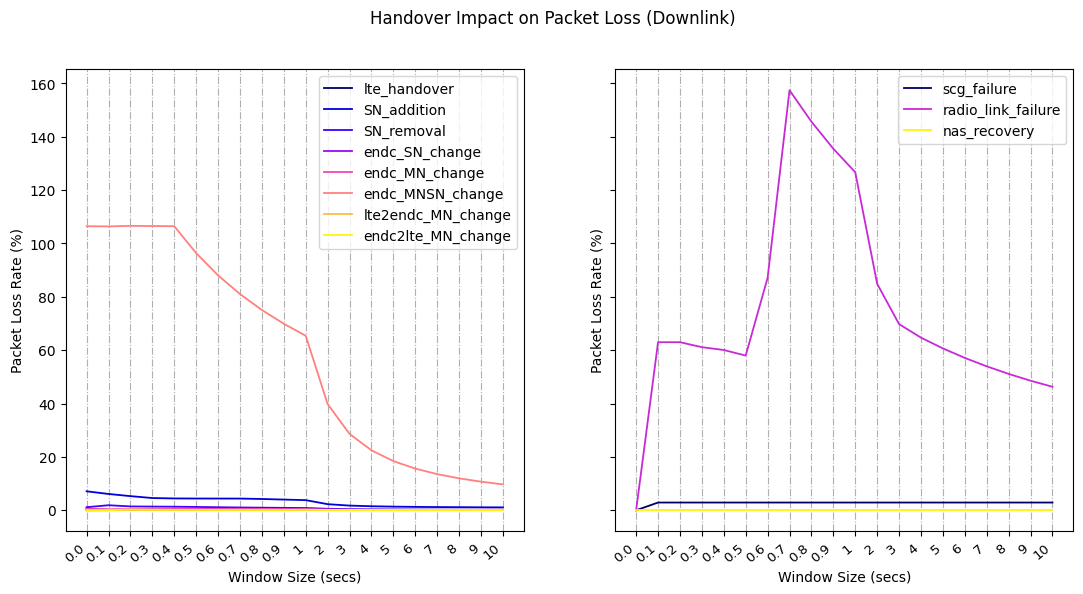

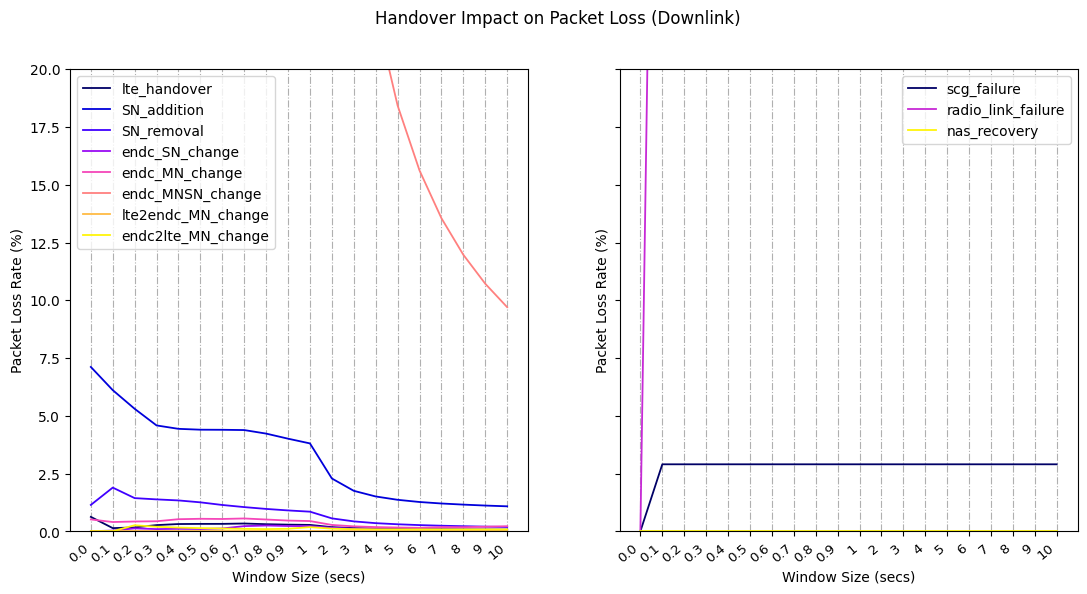

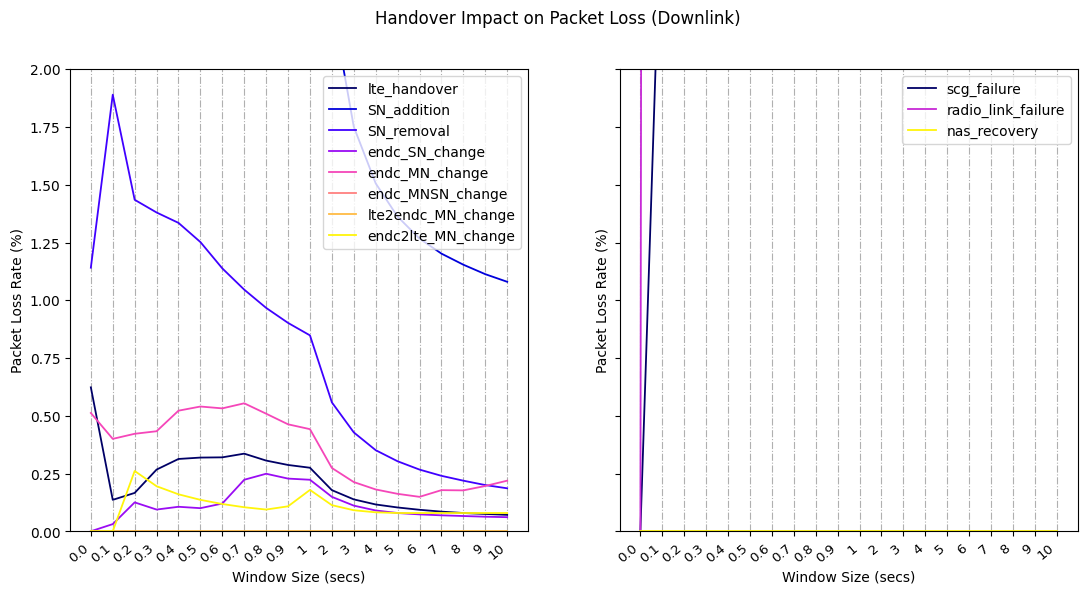

In [53]:
# df = pd.read_csv("/home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm03/#01/analysis/udp-loss-classify-50p/dwnlnk_loss_ho_classify_total.csv")
# df = pd.read_csv("/home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm04/#01/analysis/udp-loss-classify-50p/dwnlnk_loss_ho_classify_total.csv")
# df = pd.read_csv("/home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm05/#01/analysis/udp-loss-classify-50p/dwnlnk_loss_ho_classify_total.csv")
# df = pd.read_csv("/home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm06/#01/analysis/udp-loss-classify-50p/dwnlnk_loss_ho_classify_total.csv")
# df = pd.read_csv("/home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm07/#01/analysis/udp-loss-classify-50p/dwnlnk_loss_ho_classify_total.csv")
# df = pd.read_csv("/home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm08/#01/analysis/udp-loss-classify-50p/dwnlnk_loss_ho_classify_total.csv")

ho_types = "lte_handover,SN_addition,SN_removal,endc_SN_change,endc_MN_change,endc_MNSN_change,lte2endc_MN_change,endc2lte_MN_change".split(',')
rlf_types = "scg_failure,radio_link_failure,nas_recovery".split(',')

wsize = [s/10 for s in range(10)] + list(range(1, 11))
wsize_str = ['0{}'.format(s) for s in range(10)] + [str(s) for s in range(1, 11)]

yy = []
for i, ho_type in enumerate(ho_types + rlf_types):
    yy.append([])
    for k, (ws, tt) in enumerate(zip(wsize, wsize_str)):
        _packet_num = 0
        _loss_num = 0
        for j, (key, item) in enumerate(dset.items()):
            for _round in item['rounds']:
                df = pd.read_csv(os.path.join(item['root'], _round, 'analysis', 'udp-loss-classify-50p', 'dwnlnk_loss_ho_classify_{}.csv'.format(tt)))
                if i < 8:
                    _packet_num += int(df[df['type'] == 'during_{}'.format(ho_type)]['total_packet_num']) + int(df[df['type'] == 'after_{}'.format(ho_type)]['total_packet_num'])
                    _loss_num += int(df[df['type'] == 'during_{}'.format(ho_type)]['packet_loss_num']) + int(df[df['type'] == 'after_{}'.format(ho_type)]['packet_loss_num'])
                else:
                    _packet_num += int(df[df['type'] == 'after_{}'.format(ho_type)]['total_packet_num'])
                    _loss_num += int(df[df['type'] == 'after_{}'.format(ho_type)]['packet_loss_num'])
        yy[i].append(round(_loss_num / (_packet_num + 1e-9) * 100, 3))
print(yy)


### Plotting
labels = [str(s) for s in wsize]
x = np.arange(len(labels))

fig, (ax, ax2) = plt.subplots(1, 2, sharey=True, figsize =(13, 6))
fig.suptitle('Handover Impact on Packet Loss (Downlink)')

cmap = bpy_color_palette(8, 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
color_dict = {_type : color for color, _type in zip(color_list, ho_types)}

for i, ho_type in enumerate(ho_types):
    ax.plot(x, yy[i], color_list[i], linewidth=1.3, label=ho_type)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xticks(x, labels)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax.set_xlabel('Window Size (secs)')
ax.set_ylabel('Packet Loss Rate (%)')
# ax.set_title('Handover Impact on Packet Loss')
ax.grid(axis='x', linestyle='-.')
ax.legend()

cmap = bpy_color_palette(3, 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
color_dict = {_type : color for color, _type in zip(color_list, ho_types)}

for i, rlf_type in enumerate(rlf_types):
    ax2.plot(x, yy[i+8], color_list[i], linewidth=1.3, label=rlf_type)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_xticks(x, labels)
ax2.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax2.set_xlabel('Window Size (secs)')
ax2.set_ylabel('Packet Loss Rate (%)')
# ax2.set_title('Handover Impact on Packet Loss')
ax2.grid(axis='x', linestyle='-.')
ax2.legend()

plt.show()

### Plotting
labels = [str(s) for s in wsize]
x = np.arange(len(labels))

fig, (ax, ax2) = plt.subplots(1, 2, sharey=True, figsize =(13, 6))
fig.suptitle('Handover Impact on Packet Loss (Downlink)')

cmap = bpy_color_palette(8, 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
color_dict = {_type : color for color, _type in zip(color_list, ho_types)}

for i, ho_type in enumerate(ho_types):
    ax.plot(x, yy[i], color_list[i], linewidth=1.3, label=ho_type)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xticks(x, labels)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax.set_xlabel('Window Size (secs)')
ax.set_ylabel('Packet Loss Rate (%)')
# ax.set_title('Handover Impact on Packet Loss')
ax.grid(axis='x', linestyle='-.')
ax.legend()

cmap = bpy_color_palette(3, 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
color_dict = {_type : color for color, _type in zip(color_list, ho_types)}

for i, rlf_type in enumerate(rlf_types):
    ax2.plot(x, yy[i+8], color_list[i], linewidth=1.3, label=rlf_type)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_xticks(x, labels)
ax2.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax2.set_xlabel('Window Size (secs)')
ax2.set_ylabel('Packet Loss Rate (%)')
# ax2.set_title('Handover Impact on Packet Loss')
ax2.grid(axis='x', linestyle='-.')
ax2.legend()

ax.set_ylim(0, 20)

plt.show()

### Plotting
labels = [str(s) for s in wsize]
x = np.arange(len(labels))

fig, (ax, ax2) = plt.subplots(1, 2, sharey=True, figsize =(13, 6))
fig.suptitle('Handover Impact on Packet Loss (Downlink)')

cmap = bpy_color_palette(8, 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
color_dict = {_type : color for color, _type in zip(color_list, ho_types)}

for i, ho_type in enumerate(ho_types):
    ax.plot(x, yy[i], color_list[i], linewidth=1.3, label=ho_type)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xticks(x, labels)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax.set_xlabel('Window Size (secs)')
ax.set_ylabel('Packet Loss Rate (%)')
# ax.set_title('Handover Impact on Packet Loss')
ax.grid(axis='x', linestyle='-.')
ax.legend()

cmap = bpy_color_palette(3, 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
color_dict = {_type : color for color, _type in zip(color_list, ho_types)}

for i, rlf_type in enumerate(rlf_types):
    ax2.plot(x, yy[i+8], color_list[i], linewidth=1.3, label=rlf_type)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_xticks(x, labels)
ax2.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax2.set_xlabel('Window Size (secs)')
ax2.set_ylabel('Packet Loss Rate (%)')
# ax2.set_title('Handover Impact on Packet Loss')
ax2.grid(axis='x', linestyle='-.')
ax2.legend()

ax.set_ylim(0, 2)

plt.show()

##### Uplink Loss

[[1.38, 1.267, 1.256, 1.249, 1.252, 1.179, 1.149, 1.104, 1.054, 0.994, 0.948, 0.837, 0.783, 0.681, 0.626, 0.604, 0.559, 0.518, 0.488, 0.462], [4.35, 2.462, 1.968, 1.396, 1.103, 0.963, 1.401, 1.448, 1.536, 1.399, 1.362, 0.834, 0.638, 0.548, 0.497, 0.462, 0.439, 0.422, 0.408, 0.396], [0.152, 0.162, 0.215, 0.542, 0.568, 0.985, 1.006, 0.931, 0.868, 0.809, 1.17, 0.806, 0.619, 0.516, 0.441, 0.388, 0.349, 0.317, 0.291, 0.27], [0.0, 0.0, 0.0, 0.07, 0.078, 0.069, 0.104, 0.101, 0.091, 0.088, 0.109, 0.082, 0.066, 0.063, 0.055, 0.051, 0.048, 0.046, 0.044, 0.043], [0.682, 0.515, 0.574, 0.542, 0.527, 0.52, 0.522, 0.515, 0.473, 0.431, 0.398, 0.261, 0.204, 0.177, 0.158, 0.147, 0.178, 0.183, 0.199, 0.226], [0.0, 0.0, 0.0, 0.701, 7.531, 6.818, 6.228, 5.732, 5.31, 4.945, 4.627, 2.817, 2.025, 1.58, 1.296, 1.098, 0.953, 0.842, 0.753, 0.682], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.103, 0.065, 0.049, 0.04, 0.034, 0.029, 0.026, 0.024, 0.02

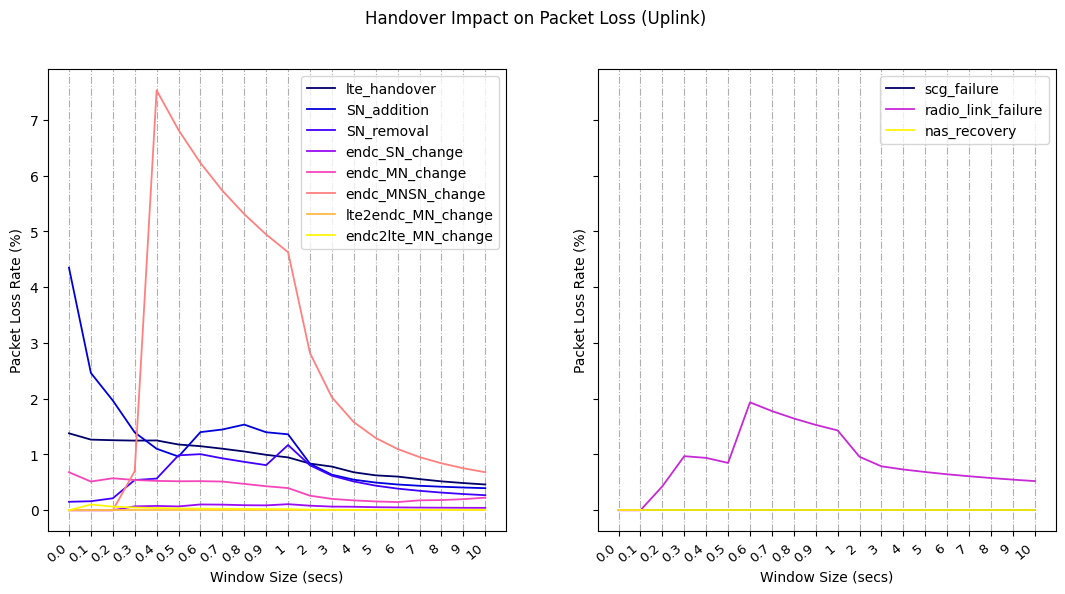

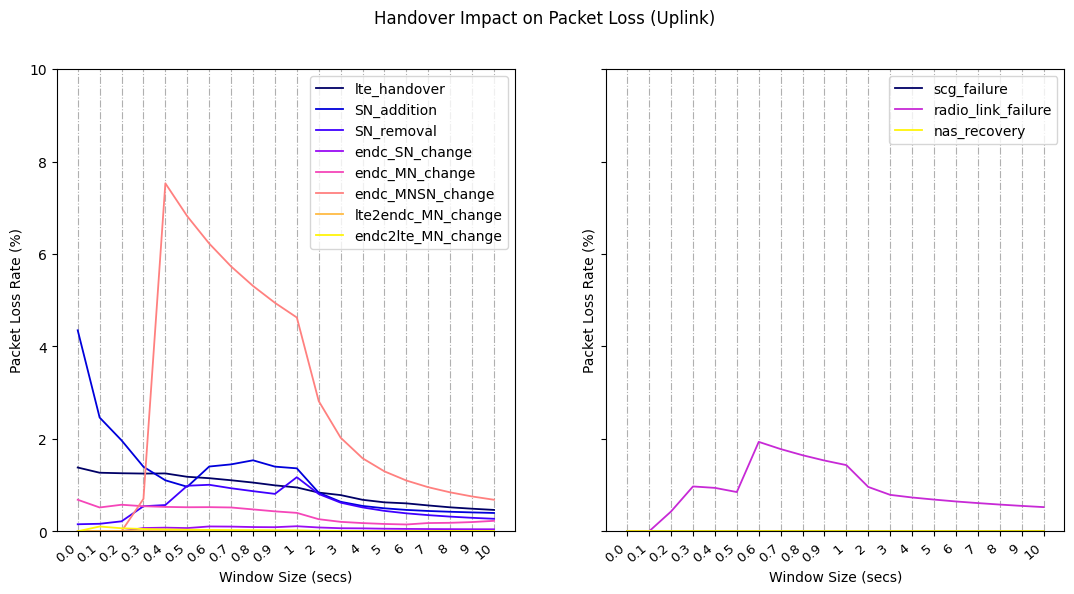

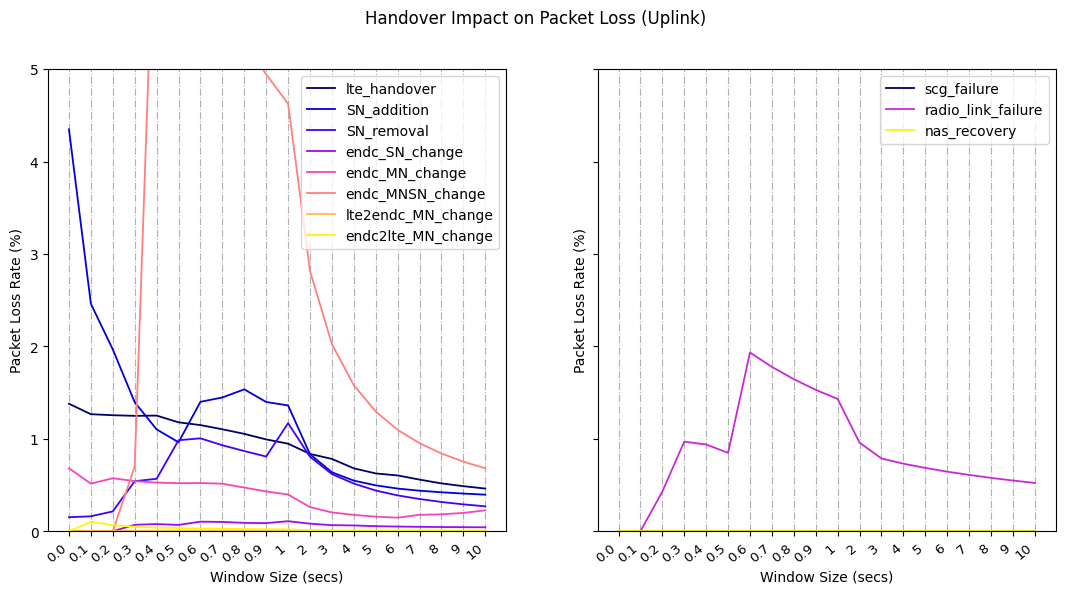

In [54]:
# df = pd.read_csv("/home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm03/#01/analysis/udp-loss-classify-50p/dwnlnk_loss_ho_classify_total.csv")
# df = pd.read_csv("/home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm04/#01/analysis/udp-loss-classify-50p/dwnlnk_loss_ho_classify_total.csv")
# df = pd.read_csv("/home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm05/#01/analysis/udp-loss-classify-50p/dwnlnk_loss_ho_classify_total.csv")
# df = pd.read_csv("/home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm06/#01/analysis/udp-loss-classify-50p/dwnlnk_loss_ho_classify_total.csv")
# df = pd.read_csv("/home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm07/#01/analysis/udp-loss-classify-50p/dwnlnk_loss_ho_classify_total.csv")
# df = pd.read_csv("/home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm08/#01/analysis/udp-loss-classify-50p/dwnlnk_loss_ho_classify_total.csv")

ho_types = "lte_handover,SN_addition,SN_removal,endc_SN_change,endc_MN_change,endc_MNSN_change,lte2endc_MN_change,endc2lte_MN_change".split(',')
rlf_types = "scg_failure,radio_link_failure,nas_recovery".split(',')

wsize = [s/10 for s in range(10)] + list(range(1, 11))
wsize_str = ['0{}'.format(s) for s in range(10)] + [str(s) for s in range(1, 11)]

yy = []
for i, ho_type in enumerate(ho_types + rlf_types):
    yy.append([])
    for k, (ws, tt) in enumerate(zip(wsize, wsize_str)):
        _packet_num = 0
        _loss_num = 0
        for j, (key, item) in enumerate(dset.items()):
            for _round in item['rounds']:
                df = pd.read_csv(os.path.join(item['root'], _round, 'analysis', 'udp-loss-classify-50p', 'uplnk_loss_ho_classify_{}.csv'.format(tt)))
                if i < 8:
                    _packet_num += int(df[df['type'] == 'during_{}'.format(ho_type)]['total_packet_num']) + int(df[df['type'] == 'after_{}'.format(ho_type)]['total_packet_num'])
                    _loss_num += int(df[df['type'] == 'during_{}'.format(ho_type)]['packet_loss_num']) + int(df[df['type'] == 'after_{}'.format(ho_type)]['packet_loss_num'])
                else:
                    _packet_num += int(df[df['type'] == 'after_{}'.format(ho_type)]['total_packet_num'])
                    _loss_num += int(df[df['type'] == 'after_{}'.format(ho_type)]['packet_loss_num'])
        yy[i].append(round(_loss_num / (_packet_num + 1e-9) * 100, 3))
print(yy)


### Plotting
labels = [str(s) for s in wsize]
x = np.arange(len(labels))

fig, (ax, ax2) = plt.subplots(1, 2, sharey=True, figsize =(13, 6))
fig.suptitle('Handover Impact on Packet Loss (Uplink)')

cmap = bpy_color_palette(8, 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
color_dict = {_type : color for color, _type in zip(color_list, ho_types)}

for i, ho_type in enumerate(ho_types):
    ax.plot(x, yy[i], color_list[i], linewidth=1.3, label=ho_type)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xticks(x, labels)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax.set_xlabel('Window Size (secs)')
ax.set_ylabel('Packet Loss Rate (%)')
# ax.set_title('Handover Impact on Packet Loss')
ax.grid(axis='x', linestyle='-.')
ax.legend()

cmap = bpy_color_palette(3, 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
color_dict = {_type : color for color, _type in zip(color_list, ho_types)}

for i, rlf_type in enumerate(rlf_types):
    ax2.plot(x, yy[i+8], color_list[i], linewidth=1.3, label=rlf_type)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_xticks(x, labels)
ax2.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax2.set_xlabel('Window Size (secs)')
ax2.set_ylabel('Packet Loss Rate (%)')
# ax2.set_title('Handover Impact on Packet Loss')
ax2.grid(axis='x', linestyle='-.')
ax2.legend()

plt.show()

### Plotting
labels = [str(s) for s in wsize]
x = np.arange(len(labels))

fig, (ax, ax2) = plt.subplots(1, 2, sharey=True, figsize =(13, 6))
fig.suptitle('Handover Impact on Packet Loss (Uplink)')

cmap = bpy_color_palette(8, 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
color_dict = {_type : color for color, _type in zip(color_list, ho_types)}

for i, ho_type in enumerate(ho_types):
    ax.plot(x, yy[i], color_list[i], linewidth=1.3, label=ho_type)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xticks(x, labels)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax.set_xlabel('Window Size (secs)')
ax.set_ylabel('Packet Loss Rate (%)')
# ax.set_title('Handover Impact on Packet Loss')
ax.grid(axis='x', linestyle='-.')
ax.legend()

cmap = bpy_color_palette(3, 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
color_dict = {_type : color for color, _type in zip(color_list, ho_types)}

for i, rlf_type in enumerate(rlf_types):
    ax2.plot(x, yy[i+8], color_list[i], linewidth=1.3, label=rlf_type)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_xticks(x, labels)
ax2.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax2.set_xlabel('Window Size (secs)')
ax2.set_ylabel('Packet Loss Rate (%)')
# ax2.set_title('Handover Impact on Packet Loss')
ax2.grid(axis='x', linestyle='-.')
ax2.legend()

ax.set_ylim(0, 10)

plt.show()

### Plotting
labels = [str(s) for s in wsize]
x = np.arange(len(labels))

fig, (ax, ax2) = plt.subplots(1, 2, sharey=True, figsize =(13, 6))
fig.suptitle('Handover Impact on Packet Loss (Uplink)')

cmap = bpy_color_palette(8, 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
color_dict = {_type : color for color, _type in zip(color_list, ho_types)}

for i, ho_type in enumerate(ho_types):
    ax.plot(x, yy[i], color_list[i], linewidth=1.3, label=ho_type)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xticks(x, labels)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax.set_xlabel('Window Size (secs)')
ax.set_ylabel('Packet Loss Rate (%)')
# ax.set_title('Handover Impact on Packet Loss')
ax.grid(axis='x', linestyle='-.')
ax.legend()

cmap = bpy_color_palette(3, 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
color_dict = {_type : color for color, _type in zip(color_list, ho_types)}

for i, rlf_type in enumerate(rlf_types):
    ax2.plot(x, yy[i+8], color_list[i], linewidth=1.3, label=rlf_type)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_xticks(x, labels)
ax2.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax2.set_xlabel('Window Size (secs)')
ax2.set_ylabel('Packet Loss Rate (%)')
# ax2.set_title('Handover Impact on Packet Loss')
ax2.grid(axis='x', linestyle='-.')
ax2.legend()

ax.set_ylim(0, 5)

plt.show()

##### Downlink Excessive Latency

[[2.715, 2.611, 2.154, 2.565, 2.807, 3.591, 3.816, 3.959, 4.52, 4.373, 4.366, 3.046, 2.417, 2.065, 1.859, 1.685, 1.561, 1.459, 1.394, 1.332], [4.543, 2.065, 2.549, 3.456, 3.587, 4.42, 6.49, 8.351, 9.727, 9.945, 9.204, 8.146, 6.243, 5.368, 4.855, 4.514, 4.285, 4.113, 3.968, 3.849], [6.92, 3.618, 4.497, 4.191, 3.717, 4.757, 5.065, 4.655, 4.562, 4.253, 3.997, 4.508, 3.458, 2.832, 2.419, 2.128, 1.916, 1.748, 1.603, 1.494], [8.114, 1.376, 2.711, 2.514, 2.857, 3.199, 4.528, 4.877, 4.997, 5.164, 4.942, 4.213, 3.12, 2.546, 2.232, 2.045, 1.934, 1.855, 1.79, 1.731], [0.455, 0.992, 1.552, 1.444, 1.573, 3.048, 6.287, 7.834, 8.476, 8.13, 7.988, 7.444, 5.784, 4.92, 4.393, 4.062, 3.842, 3.659, 3.506, 3.38], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 4.882, 12.241, 10.621, 9.406, 8.518, 10.522, 10.857, 6.639, 5.309, 4.811,

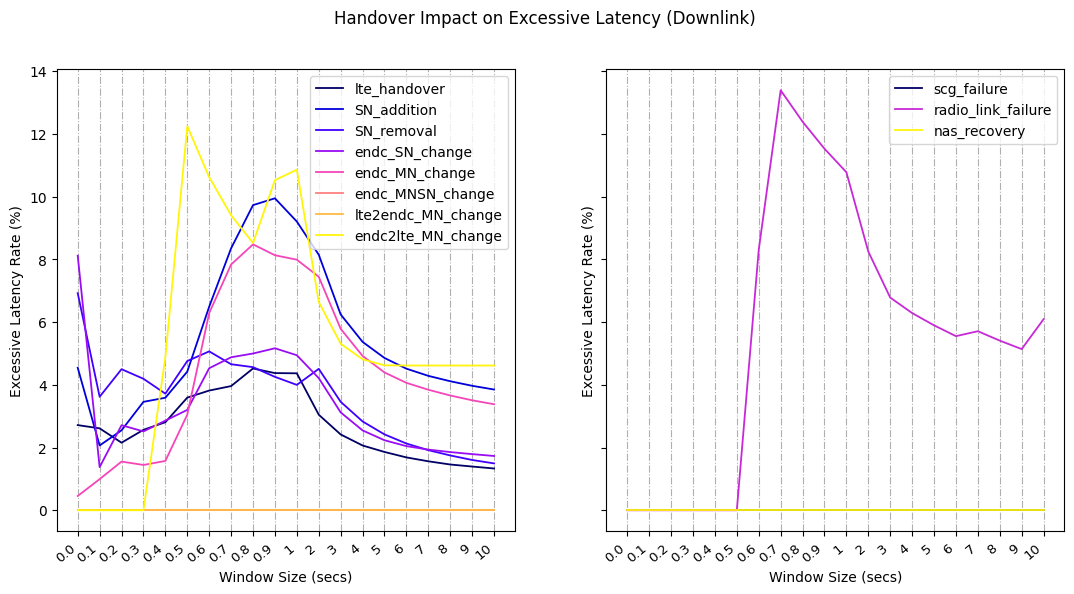

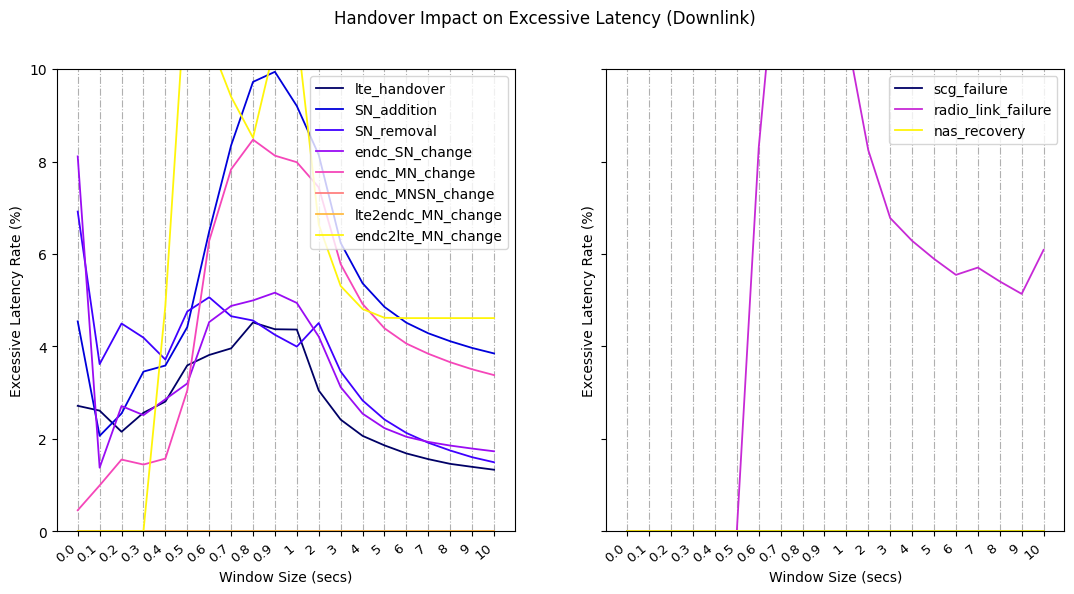

In [55]:
# df = pd.read_csv("/home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm03/#01/analysis/udp-loss-classify-50p/dwnlnk_loss_ho_classify_total.csv")
# df = pd.read_csv("/home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm04/#01/analysis/udp-loss-classify-50p/dwnlnk_loss_ho_classify_total.csv")
# df = pd.read_csv("/home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm05/#01/analysis/udp-loss-classify-50p/dwnlnk_loss_ho_classify_total.csv")
# df = pd.read_csv("/home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm06/#01/analysis/udp-loss-classify-50p/dwnlnk_loss_ho_classify_total.csv")
# df = pd.read_csv("/home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm07/#01/analysis/udp-loss-classify-50p/dwnlnk_loss_ho_classify_total.csv")
# df = pd.read_csv("/home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm08/#01/analysis/udp-loss-classify-50p/dwnlnk_loss_ho_classify_total.csv")

ho_types = "lte_handover,SN_addition,SN_removal,endc_SN_change,endc_MN_change,endc_MNSN_change,lte2endc_MN_change,endc2lte_MN_change".split(',')
rlf_types = "scg_failure,radio_link_failure,nas_recovery".split(',')

wsize = [s/10 for s in range(10)] + list(range(1, 11))
wsize_str = ['0{}'.format(s) for s in range(10)] + [str(s) for s in range(1, 11)]

yy = []
for i, ho_type in enumerate(ho_types + rlf_types):
    yy.append([])
    for k, (ws, tt) in enumerate(zip(wsize, wsize_str)):
        _packet_num = 0
        _loss_num = 0
        for j, (key, item) in enumerate(dset.items()):
            for _round in item['rounds']:
                df = pd.read_csv(os.path.join(item['root'], _round, 'analysis', 'udp-excslat-classify-50p', 'dwnlnk_excslat_ho_classify_{}.csv'.format(tt)))
                if i < 8:
                    _packet_num += int(df[df['type'] == 'during_{}'.format(ho_type)]['total_packet_num']) + int(df[df['type'] == 'after_{}'.format(ho_type)]['total_packet_num'])
                    _loss_num += int(df[df['type'] == 'during_{}'.format(ho_type)]['packet_loss_num']) + int(df[df['type'] == 'after_{}'.format(ho_type)]['packet_loss_num'])
                else:
                    _packet_num += int(df[df['type'] == 'after_{}'.format(ho_type)]['total_packet_num'])
                    _loss_num += int(df[df['type'] == 'after_{}'.format(ho_type)]['packet_loss_num'])
        yy[i].append(round(_loss_num / (_packet_num + 1e-9) * 100, 3))
print(yy)


### Plotting
labels = [str(s) for s in wsize]
x = np.arange(len(labels))

fig, (ax, ax2) = plt.subplots(1, 2, sharey=True, figsize =(13, 6))
fig.suptitle('Handover Impact on Excessive Latency (Downlink)')

cmap = bpy_color_palette(8, 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
color_dict = {_type : color for color, _type in zip(color_list, ho_types)}

for i, ho_type in enumerate(ho_types):
    ax.plot(x, yy[i], color_list[i], linewidth=1.3, label=ho_type)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xticks(x, labels)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax.set_xlabel('Window Size (secs)')
ax.set_ylabel('Excessive Latency Rate (%)')
# ax.set_title('Handover Impact on Packet Loss')
ax.grid(axis='x', linestyle='-.')
ax.legend()

cmap = bpy_color_palette(3, 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
color_dict = {_type : color for color, _type in zip(color_list, ho_types)}

for i, rlf_type in enumerate(rlf_types):
    ax2.plot(x, yy[i+8], color_list[i], linewidth=1.3, label=rlf_type)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_xticks(x, labels)
ax2.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax2.set_xlabel('Window Size (secs)')
ax2.set_ylabel('Excessive Latency Rate (%)')
# ax2.set_title('Handover Impact on Packet Loss')
ax2.grid(axis='x', linestyle='-.')
ax2.legend()

plt.show()

### Plotting
labels = [str(s) for s in wsize]
x = np.arange(len(labels))

fig, (ax, ax2) = plt.subplots(1, 2, sharey=True, figsize =(13, 6))
fig.suptitle('Handover Impact on Excessive Latency (Downlink)')

cmap = bpy_color_palette(8, 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
color_dict = {_type : color for color, _type in zip(color_list, ho_types)}

for i, ho_type in enumerate(ho_types):
    ax.plot(x, yy[i], color_list[i], linewidth=1.3, label=ho_type)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xticks(x, labels)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax.set_xlabel('Window Size (secs)')
ax.set_ylabel('Excessive Latency Rate (%)')
# ax.set_title('Handover Impact on Packet Loss')
ax.grid(axis='x', linestyle='-.')
ax.legend()

cmap = bpy_color_palette(3, 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
color_dict = {_type : color for color, _type in zip(color_list, ho_types)}

for i, rlf_type in enumerate(rlf_types):
    ax2.plot(x, yy[i+8], color_list[i], linewidth=1.3, label=rlf_type)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_xticks(x, labels)
ax2.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax2.set_xlabel('Window Size (secs)')
ax2.set_ylabel('Excessive Latency Rate (%)')
# ax2.set_title('Handover Impact on Packet Loss')
ax2.grid(axis='x', linestyle='-.')
ax2.legend()

ax.set_ylim(0, 10)

plt.show()

# ### Plotting
# labels = [str(s) for s in wsize]
# x = np.arange(len(labels))

# fig, (ax, ax2) = plt.subplots(1, 2, sharey=True, figsize =(13, 6))
# fig.suptitle('Handover Impact on Excessive Latency (Downlink)')

# cmap = bpy_color_palette(8, 0.2)
# color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
# color_dict = {_type : color for color, _type in zip(color_list, ho_types)}

# for i, ho_type in enumerate(ho_types):
#     ax.plot(x, yy[i], color_list[i], linewidth=1.3, label=ho_type)

# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_xticks(x, labels)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

# ax.set_xlabel('Window Size (secs)')
# ax.set_ylabel('Excessive Latency Rate (%)')
# # ax.set_title('Handover Impact on Packet Loss')
# ax.grid(axis='x', linestyle='-.')
# ax.legend()

# cmap = bpy_color_palette(3, 0.2)
# color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
# color_dict = {_type : color for color, _type in zip(color_list, ho_types)}

# for i, rlf_type in enumerate(rlf_types):
#     ax2.plot(x, yy[i+8], color_list[i], linewidth=1.3, label=rlf_type)

# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax2.set_xticks(x, labels)
# ax2.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

# ax2.set_xlabel('Window Size (secs)')
# ax2.set_ylabel('Excessive Latency Rate (%)')
# # ax2.set_title('Handover Impact on Packet Loss')
# ax2.grid(axis='x', linestyle='-.')
# ax2.legend()

# ax.set_ylim(0, 2)

# plt.show()

##### Uplink Excessive Latency

[[14.286, 12.525, 12.79, 13.648, 14.39, 14.966, 15.225, 15.428, 15.369, 15.206, 14.992, 12.725, 11.034, 9.633, 8.611, 7.823, 7.246, 6.945, 6.638, 6.293], [18.474, 22.752, 18.345, 17.585, 18.353, 18.918, 18.953, 19.284, 18.458, 18.66, 18.42, 13.145, 10.253, 8.917, 8.225, 7.657, 7.273, 6.986, 6.742, 6.543], [32.928, 34.971, 38.531, 41.292, 42.701, 42.922, 42.945, 42.477, 41.761, 40.773, 39.313, 27.528, 21.116, 17.295, 14.772, 12.996, 11.703, 10.644, 9.868, 9.144], [9.257, 9.57, 9.986, 9.863, 11.456, 12.72, 13.08, 13.608, 13.873, 13.805, 13.798, 13.875, 11.742, 10.248, 9.214, 8.651, 8.31, 7.968, 7.69, 7.437], [10.997, 11.077, 11.821, 13.809, 16.845, 18.491, 18.541, 18.612, 18.406, 18.364, 18.156, 16.234, 14.463, 13.293, 12.683, 12.388, 12.376, 12.263, 12.224, 12.186], [69.424, 58.841, 99.735, 94.159, 92.259, 92.992, 93.599, 94.108, 94.543, 93.544, 87.532, 53.286, 38.301, 29.895, 24.514, 20.775, 18.025, 15.919, 14.253, 12.903], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

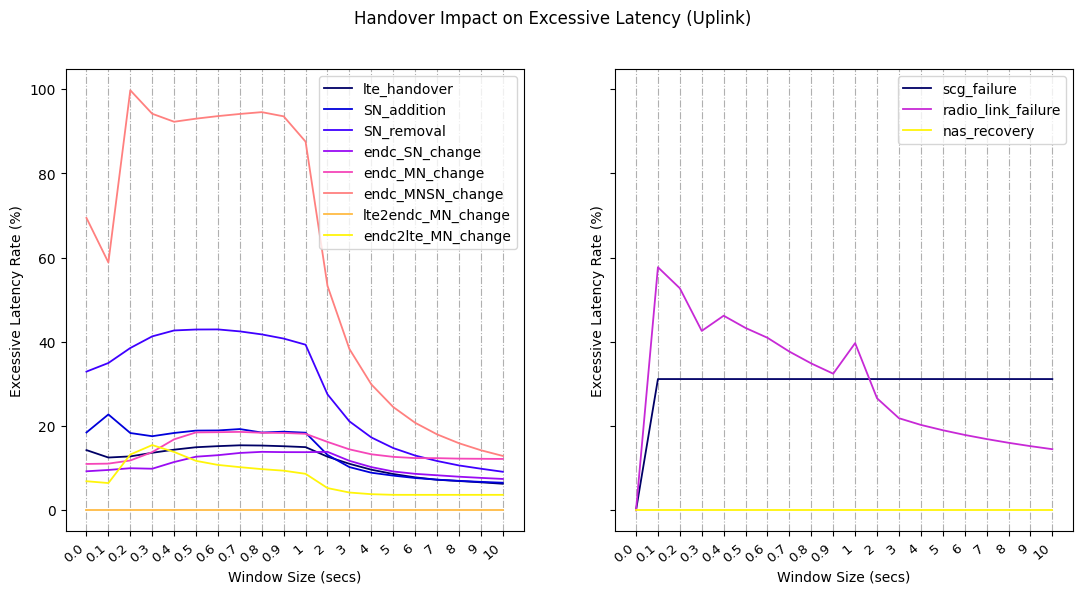

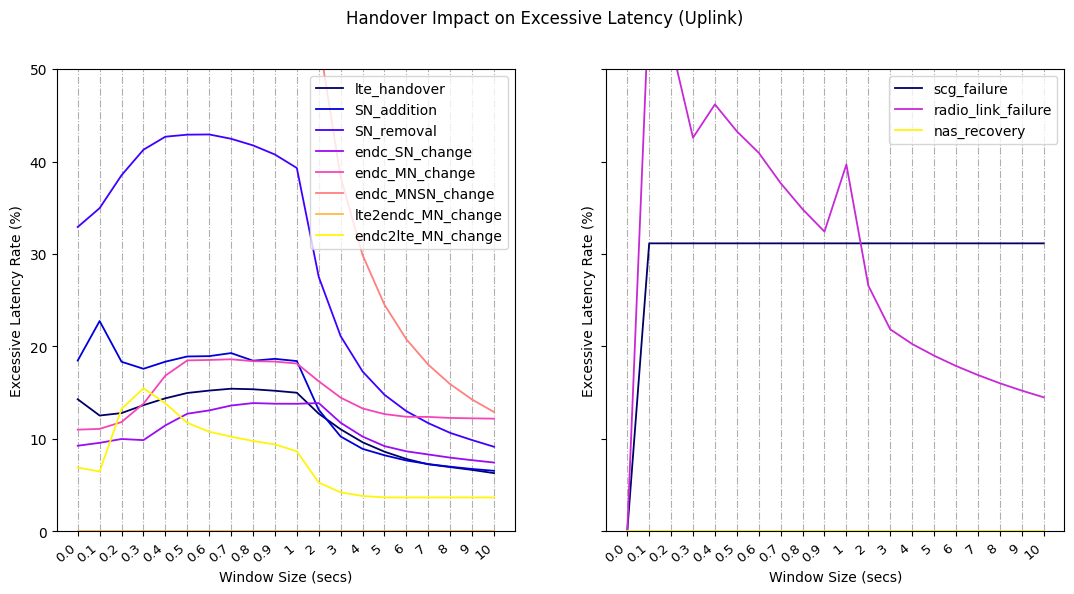

In [56]:
# df = pd.read_csv("/home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm03/#01/analysis/udp-loss-classify-50p/dwnlnk_loss_ho_classify_total.csv")
# df = pd.read_csv("/home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm04/#01/analysis/udp-loss-classify-50p/dwnlnk_loss_ho_classify_total.csv")
# df = pd.read_csv("/home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm05/#01/analysis/udp-loss-classify-50p/dwnlnk_loss_ho_classify_total.csv")
# df = pd.read_csv("/home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm06/#01/analysis/udp-loss-classify-50p/dwnlnk_loss_ho_classify_total.csv")
# df = pd.read_csv("/home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm07/#01/analysis/udp-loss-classify-50p/dwnlnk_loss_ho_classify_total.csv")
# df = pd.read_csv("/home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm08/#01/analysis/udp-loss-classify-50p/dwnlnk_loss_ho_classify_total.csv")

ho_types = "lte_handover,SN_addition,SN_removal,endc_SN_change,endc_MN_change,endc_MNSN_change,lte2endc_MN_change,endc2lte_MN_change".split(',')
rlf_types = "scg_failure,radio_link_failure,nas_recovery".split(',')

wsize = [s/10 for s in range(10)] + list(range(1, 11))
wsize_str = ['0{}'.format(s) for s in range(10)] + [str(s) for s in range(1, 11)]

yy = []
for i, ho_type in enumerate(ho_types + rlf_types):
    yy.append([])
    for k, (ws, tt) in enumerate(zip(wsize, wsize_str)):
        _packet_num = 0
        _loss_num = 0
        for j, (key, item) in enumerate(dset.items()):
            for _round in item['rounds']:
                df = pd.read_csv(os.path.join(item['root'], _round, 'analysis', 'udp-excslat-classify-50p', 'uplnk_excslat_ho_classify_{}.csv'.format(tt)))
                if i < 8:
                    _packet_num += int(df[df['type'] == 'during_{}'.format(ho_type)]['total_packet_num']) + int(df[df['type'] == 'after_{}'.format(ho_type)]['total_packet_num'])
                    _loss_num += int(df[df['type'] == 'during_{}'.format(ho_type)]['packet_loss_num']) + int(df[df['type'] == 'after_{}'.format(ho_type)]['packet_loss_num'])
                else:
                    _packet_num += int(df[df['type'] == 'after_{}'.format(ho_type)]['total_packet_num'])
                    _loss_num += int(df[df['type'] == 'after_{}'.format(ho_type)]['packet_loss_num'])
        yy[i].append(round(_loss_num / (_packet_num + 1e-9) * 100, 3))
print(yy)


### Plotting
labels = [str(s) for s in wsize]
x = np.arange(len(labels))

fig, (ax, ax2) = plt.subplots(1, 2, sharey=True, figsize =(13, 6))
fig.suptitle('Handover Impact on Excessive Latency (Uplink)')

cmap = bpy_color_palette(8, 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
color_dict = {_type : color for color, _type in zip(color_list, ho_types)}

for i, ho_type in enumerate(ho_types):
    ax.plot(x, yy[i], color_list[i], linewidth=1.3, label=ho_type)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xticks(x, labels)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax.set_xlabel('Window Size (secs)')
ax.set_ylabel('Excessive Latency Rate (%)')
# ax.set_title('Handover Impact on Packet Loss')
ax.grid(axis='x', linestyle='-.')
ax.legend()

cmap = bpy_color_palette(3, 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
color_dict = {_type : color for color, _type in zip(color_list, ho_types)}

for i, rlf_type in enumerate(rlf_types):
    ax2.plot(x, yy[i+8], color_list[i], linewidth=1.3, label=rlf_type)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_xticks(x, labels)
ax2.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax2.set_xlabel('Window Size (secs)')
ax2.set_ylabel('Excessive Latency Rate (%)')
# ax2.set_title('Handover Impact on Packet Loss')
ax2.grid(axis='x', linestyle='-.')
ax2.legend()

plt.show()

### Plotting
labels = [str(s) for s in wsize]
x = np.arange(len(labels))

fig, (ax, ax2) = plt.subplots(1, 2, sharey=True, figsize =(13, 6))
fig.suptitle('Handover Impact on Excessive Latency (Uplink)')

cmap = bpy_color_palette(8, 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
color_dict = {_type : color for color, _type in zip(color_list, ho_types)}

for i, ho_type in enumerate(ho_types):
    ax.plot(x, yy[i], color_list[i], linewidth=1.3, label=ho_type)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xticks(x, labels)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax.set_xlabel('Window Size (secs)')
ax.set_ylabel('Excessive Latency Rate (%)')
# ax.set_title('Handover Impact on Packet Loss')
ax.grid(axis='x', linestyle='-.')
ax.legend()

cmap = bpy_color_palette(3, 0.2)
color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
color_dict = {_type : color for color, _type in zip(color_list, ho_types)}

for i, rlf_type in enumerate(rlf_types):
    ax2.plot(x, yy[i+8], color_list[i], linewidth=1.3, label=rlf_type)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_xticks(x, labels)
ax2.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax2.set_xlabel('Window Size (secs)')
ax2.set_ylabel('Excessive Latency Rate (%)')
# ax2.set_title('Handover Impact on Packet Loss')
ax2.grid(axis='x', linestyle='-.')
ax2.legend()

ax.set_ylim(0, 50)

plt.show()

# ### Plotting
# labels = [str(s) for s in wsize]
# x = np.arange(len(labels))

# fig, (ax, ax2) = plt.subplots(1, 2, sharey=True, figsize =(13, 6))
# fig.suptitle('Handover Impact on Excessive Latency (Uplink)')

# cmap = bpy_color_palette(8, 0.2)
# color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
# color_dict = {_type : color for color, _type in zip(color_list, ho_types)}

# for i, ho_type in enumerate(ho_types):
#     ax.plot(x, yy[i], color_list[i], linewidth=1.3, label=ho_type)

# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_xticks(x, labels)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

# ax.set_xlabel('Window Size (secs)')
# ax.set_ylabel('Excessive Latency Rate (%)')
# # ax.set_title('Handover Impact on Packet Loss')
# ax.grid(axis='x', linestyle='-.')
# ax.legend()

# cmap = bpy_color_palette(3, 0.2)
# color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
# color_dict = {_type : color for color, _type in zip(color_list, ho_types)}

# for i, rlf_type in enumerate(rlf_types):
#     ax2.plot(x, yy[i+8], color_list[i], linewidth=1.3, label=rlf_type)

# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax2.set_xticks(x, labels)
# ax2.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

# ax2.set_xlabel('Window Size (secs)')
# ax2.set_ylabel('Excessive Latency Rate (%)')
# # ax2.set_title('Handover Impact on Packet Loss')
# ax2.grid(axis='x', linestyle='-.')
# ax2.legend()

# ax.set_ylim(0, 2)

# plt.show()

#### Time linear observation

lte_handover: 8
SN_addition: 7
SN_removal: 7
endc_SN_change: 5
endc_MN_change: 19
endc_MNSN_change: 0
lte2endc_MN_change: 0
endc2lte_MN_change: 0
---------------------
scg_failure: 0
radio_link_failure: 0
nas_recovery: 0
---------------------
total: 46


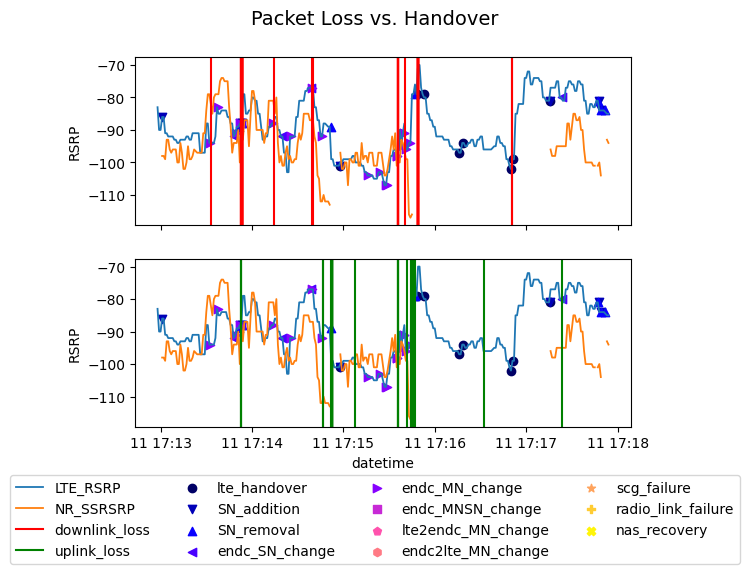

In [32]:
### start() -> stop()
### begin() -> end()
### you could use finish() to clean up and close the program but close() is more used.

def str_to_datetime(ts):
    """
    Convert a timestamp string in microseconds or milliseconds into datetime.datetime

    Args:
        ts (str): timestamp string (e.g., 2022-09-29 16:24:58.252615)
    Returns:
        (datetime.datetime)
    """
    try:
        ts_datetime = dt.datetime.strptime(ts, '%Y-%m-%d %H:%M:%S.%f')
    except:
        ts_datetime = dt.datetime.strptime(ts, '%Y-%m-%d %H:%M:%S')
    return ts_datetime

class LossAnalyzeCimon:
    def __init__(self, date, rsrp_csv, ho_csv, dlloss_csv, dlrecv_csv, ulloss_csv, ulxmit_csv):
        self.date = date
        self.rsrp_df = pd.read_csv(rsrp_csv)
        self.ho_df = pd.read_csv(ho_csv)
        self.dlloss_df = pd.read_csv(dlloss_csv)
        self.dlrecv_df = pd.read_csv(dlrecv_csv)
        self.ulloss_df = pd.read_csv(ulloss_csv)
        self.ulxmit_df = pd.read_csv(ulxmit_csv)
        for df in [self.rsrp_df, self.ho_df, self.dlloss_df, self.dlrecv_df, self.ulloss_df, self.ulxmit_df]:
            df["Timestamp"] = pd.to_datetime(df["Timestamp"])
        # self.rsrp_df["Date"] = pd.to_datetime(self.rsrp_df["Date"])
        # self.ho_df["time"] = pd.to_datetime(self.ho_df["time"])
        # self.dlloss_df["arrival.time"] = pd.to_datetime(self.dlloss_df["arrival.time"])
        # self.dlrecv_df["arrival.time"] = pd.to_datetime(self.dlrecv_df["arrival.time"])
        # self.ulloss_df["arrival.time"] = pd.to_datetime(self.ulloss_df["arrival.time"])
        # self.ulxmit_df["transmit.time"] = pd.to_datetime(self.ulxmit_df["transmit.time"])
        start_time = self.start()
        stop_time = self.stop()
        ###
        self.rsrp_df = self.rsrp_df[(self.rsrp_df["Timestamp"] >= start_time - dt.timedelta(seconds=3)) & (self.rsrp_df["Timestamp"] <= stop_time + dt.timedelta(seconds=3))]
        self.rsrp_df.reset_index(drop=True, inplace=True)
        ###
        if len(self.ho_df):
            start_indices = self.ho_df.index[self.ho_df['Timestamp'] >= start_time]
            stop_indices = self.ho_df.index[self.ho_df['Timestamp'] <= stop_time]
            if len(start_indices) and len(stop_indices):
                start_index = start_indices[0]
                stop_index = stop_indices[-1]
                if self.ho_df.loc[start_index, 'handoff_state'] == 'end':
                    self.ho_df.loc[start_index - 1, 'Timestamp'] = start_time
                    start_index -= 1
                if self.ho_df.loc[stop_index, 'handoff_state'] == 'start':
                    self.ho_df.loc[stop_index + 1, 'Timestamp'] = stop_time
                    stop_index += 1
                self.ho_df = self.ho_df.iloc[start_index : stop_index + 1]
            else:
                self.ho_df = self.ho_df.iloc[0:0]
        # self.ho_df = self.ho_df[self.ho_df['handoff_state'] == 'start']
        self.ho_df = self.ho_df[self.ho_df['handoff_state'] != 'end']
        self.ho_df.reset_index(drop=True, inplace=True)
        ### additional info
        for i in range(len(self.ho_df)):
            self.ho_df.loc[i, "rsrp"] = self.ho_rsrp(self.ho_df.loc[i, "Timestamp"], self.rsrp_df)
    
    def start(self):
        candidate = []
        [candidate.append(df["Timestamp"].iloc[0]) for df in [self.dlloss_df, self.dlrecv_df, self.ulloss_df, self.ulxmit_df] if len(df)]
        # if len(self.dlloss_df):
        #     candidate.append(self.dlloss_df["arrival.time"].iloc[0])
        # if len(self.dlrecv_df):
        #     candidate.append(self.dlrecv_df["arrival.time"].iloc[0])
        # if len(self.ulloss_df):
        #     candidate.append(self.ulloss_df["arrival.time"].iloc[0])
        # if len(self.ulxmit_df):
        #     candidate.append(self.ulxmit_df["transmit.time"].iloc[0])
        return min(candidate) if candidate else dt.datetime.min
    
    def stop(self):
        candidate = []
        [candidate.append(df["Timestamp"].iloc[-1]) for df in [self.dlloss_df, self.dlrecv_df, self.ulloss_df, self.ulxmit_df] if len(df)]
        # if len(self.dlloss_df):
        #     candidate.append(self.dlloss_df["arrival.time"].iloc[-1])
        # if len(self.dlrecv_df):
        #     candidate.append(self.dlrecv_df["arrival.time"].iloc[-1])
        # if len(self.ulloss_df):
        #     candidate.append(self.ulloss_df["arrival.time"].iloc[-1])
        # if len(self.ulxmit_df):
        #     candidate.append(self.ulxmit_df["transmit.time"].iloc[-1])
        return max(candidate) if candidate else dt.datetime.max
    
    @staticmethod
    def ho_rsrp(ts, rsrp_df):
        ### assume cimon (at_log) -> mi -> tx/rx pcap -> stop pcap -> stop mi -> stop cimon (at_log)
        indices_around = rsrp_df.index[rsrp_df['Timestamp'] <= ts]
        return int(rsrp_df.loc[indices_around[-1], "LTE_RSRP"]) if len(indices_around) else '-'
    
    def unified(self, ts):
        if len(ts) == 5:
            ts = "{} {}:00".format(self.date, ts)
        elif len(ts) == 8:
            ts = "{} {}".format(self.date, ts)
        return ts
    
    def plot(self, start_time=None, stop_time=None):
        rsrp_df, ho_df, dlloss_df, dlrecv_df, ulloss_df, ulxmit_df = self.rsrp_df.copy(), self.ho_df.copy(), self.dlloss_df.copy(), self.dlrecv_df.copy(), self.ulloss_df.copy(), self.ulxmit_df.copy()
        if start_time and stop_time:
            start_time = str_to_datetime(self.unified(start_time))
            stop_time = str_to_datetime(self.unified(stop_time))
            rsrp_df = rsrp_df[(rsrp_df["Timestamp"] >= start_time) & (rsrp_df["Timestamp"] <= stop_time)]
            ho_df = ho_df[(ho_df["Timestamp"] >= start_time) & (ho_df["Timestamp"] <= stop_time)]
            dlloss_df = dlloss_df[(dlloss_df["Timestamp"] >= start_time) & (dlloss_df["Timestamp"] <= stop_time)]
            dlrecv_df = dlrecv_df[(dlrecv_df["Timestamp"] >= start_time) & (dlrecv_df["Timestamp"] <= stop_time)]
            ulloss_df = ulloss_df[(ulloss_df["Timestamp"] >= start_time) & (ulloss_df["Timestamp"] <= stop_time)]
            ulxmit_df = ulxmit_df[(ulxmit_df["Timestamp"] >= start_time) & (ulxmit_df["Timestamp"] <= stop_time)]
            for df in [rsrp_df, ho_df, dlloss_df, dlrecv_df, ulloss_df, ulxmit_df]:
                # df = df[(df["Timestamp"] >= start_time) & (df["Timestamp"] <= stop_time)]
                df.reset_index(drop=True, inplace=True)
            
        ### Plotting
        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)
        fig.suptitle('Packet Loss vs. Handover', fontsize=14)

        ### draw RSRP
        time_lte = rsrp_df["Timestamp"].array
        rsrp_lte = rsrp_df["LTE_RSRP"].astype(int).array
        lte_rsrp_plot, = ax1.plot(time_lte, rsrp_lte, 'tab:blue', linewidth=1.3)
        lte_rsrp_plot, = ax2.plot(time_lte, rsrp_lte, 'tab:blue', linewidth=1.3)

        time_nr = []
        rsrp_nr = []
        for i in range(len(rsrp_df)):
            if rsrp_df.loc[i, "NR_SSRSRP"] == '-' and len(rsrp_nr):
                ax1.plot(time_nr, rsrp_nr, 'tab:orange', linewidth=1.3)
                ax2.plot(time_nr, rsrp_nr, 'tab:orange', linewidth=1.3)
                rsrp_nr = []
                time_nr = []
            elif rsrp_df.loc[i, "NR_SSRSRP"] != '-':
                time_nr.append(rsrp_df.loc[i, "Timestamp"])
                rsrp_nr.append(int(rsrp_df.loc[i, "NR_SSRSRP"]))
        nr_rsrp_plot, = ax1.plot(time_nr, rsrp_nr, 'tab:orange', linewidth=1.3)
        nr_rsrp_plot, = ax2.plot(time_nr, rsrp_nr, 'tab:orange', linewidth=1.3)

        ### draw packet loss
        dlloss_plot = [ax1.axvline(dlloss_df.loc[i, "Timestamp"], c = 'r') for i in range(len(dlloss_df))][0]
        ulloss_plot = [ax2.axvline(ulloss_df.loc[i, "Timestamp"], c = 'g') for i in range(len(ulloss_df))][0]

        ### draw handover
        # ho_types = "lte_handover,SN_addition,SN_removal,endc_SN_change,endc_MN_change,endc_MNSN_change,lte2endc_MN_change,endc2lte_MN_change".split(',')
        ho_types = "lte_handover,SN_addition,SN_removal,endc_SN_change,endc_MN_change,endc_MNSN_change,lte2endc_MN_change,endc2lte_MN_change,scg_failure,radio_link_failure,nas_recovery".split(',')

        x = ho_df["Timestamp"].array
        y = ho_df["rsrp"].array
        group = ho_df["handoff_type"].array
        # cmap = bpy_color_palette(8, 0.2)
        cmap = bpy_color_palette(11, 0.2)
        color_list = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
        color_dict = {_type : color for color, _type in zip(color_list, ho_types)}
        # marker_list = ['o', 'v', '^', '<', '>', 's', 'p', 'h']
        marker_list = ['o', 'v', '^', '<', '>', 's', 'p', 'h', '*', 'P', 'X']
        marker_dict = {_type : marker for marker, _type in zip(marker_list, ho_types)}

        ho_plots = [None]*len(ho_types)
        for i, _type in enumerate(ho_types):
            indices = np.where(group == _type)
            ho_plots[i] = ax1.scatter(x[indices], y[indices], marker=marker_dict[_type], c=color_dict[_type])
            ho_plots[i] = ax2.scatter(x[indices], y[indices], marker=marker_dict[_type], c=color_dict[_type])

        ### adjust figure layout
        handles = [lte_rsrp_plot, nr_rsrp_plot, dlloss_plot, ulloss_plot] + ho_plots
        labels = ["LTE_RSRP", "NR_SSRSRP", "downlink_loss", "uplink_loss"] + ho_types

        axbox = ax2.get_position()
        fig.legend(
            handles=handles, labels=labels,
            loc='lower center',
            bbox_to_anchor=[0, axbox.y0-0.3,1,1],
            # ncol=3,
            ncol=4,
        )

        plt.xlabel('datetime')
        ax1.set_ylabel('RSRP')
        ax2.set_ylabel('RSRP')

        ### handover statistics
        summ = 0
        for _type in ho_types[:8]:
            _tmp = ho_df[ho_df["handoff_type"] == _type]
            summ += len(_tmp)
            print("{}: {}".format(_type, len(_tmp)))
        print("---------------------")
        for _type in ho_types[8:]:
            _tmp = ho_df[ho_df["handoff_type"] == _type]
            summ += len(_tmp)
            print("{}: {}".format(_type, len(_tmp)))
        print("---------------------")
        print("total: {}".format(summ))

        ### show figure
        plt.show()

loss_analysis = LossAnalyzeCimon( "2022-10-11",
                                "/home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm04/#01/data/cimon_sm04_2022-10-11_17-08-56_preproc.csv",
                                "/home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm04/#01/analysis/diag_log_ho-info.csv",
                                "/home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm04/#01/analysis/dwnlnk_udp_loss_timestamp.csv",
                                "/home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm04/#01/analysis/clt_dwnlnk_udp_packet_brief.csv",
                                "/home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm04/#01/analysis/uplnk_udp_loss_timestamp.csv",
                                "/home/wmnlab/D/database/2022-10-11/_Bandlock_Udp/sm04/#01/analysis/clt_uplnk_udp_packet_brief.csv" )
loss_analysis.plot()